---
# SURFER model with ATCM
---

**Author** : Amaury Laridon, Victor Couplet

**Content** : In this notebook, we started from the version of the SURFER v3.0 model developt for Couplet et al.(2025) - Tipping interactions and cascades on multimillennial time scales in a  model of reduced complexity. We integrate the AMOC Tipping Calibration Module (ATCM) described in Laridon et al.(2025) - Development and Validation of a Tipping Element Emulator Integrated into a Simplified Climate Model to Study the Future Collapse of the AMOC. 

## Python Packages

In [11]:
import numpy as np
import IPython
import os 
import xarray as xr
import tabulate

from math import floor,log10
from timeit import default_timer as timer
from numba import jit,njit
import cmath

from scipy.integrate import solve_ivp, odeint
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmcrameri.cm as cmc

from netCDF4 import Dataset

%matplotlib ipympl

## Setup

Files containing data necessary for running SURFER are available in the folder SURFER_cascades available on [url_link] In the cell below, please enter the path to where you downloaded the folder SURFER_cascades on your machine. You can also provide the path to a folder where you want the figures to be saved.

In [12]:
base_path = 'C:\\Users\\AL000111\\Documents\\Publication\\Laridon_et_al_2025'
figures_path = os.path.join(base_path, 'figures\\SURFER\\')
data_path = os.path.join(base_path, 'data\\SURFER\\')

## Color interpolator

In [13]:
color_p = ['#00AFD8','#0C4077','#F49B10','#E4201D','#A82113']

colormap=plt.get_cmap('cmc.lipari') 

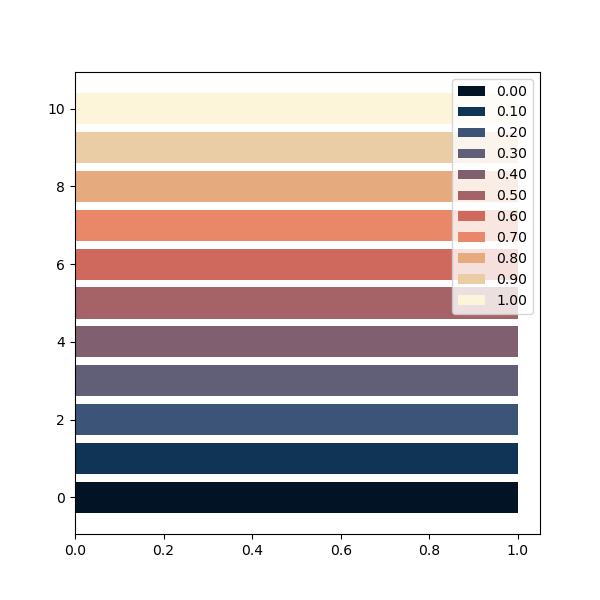

In [14]:


# 1. Choose a colormap
cmap = plt.get_cmap('cmc.lipari')

# 2. Extract single colors by calling the colormap with a value between 0 and 1
# For example, 0.0 is the first color, 0.5 is a mid-point color, and 1.0 is the last color
color_choices = np.linspace(0,1,11)
colors_p = cmap(color_choices)
                

# Optional: Plot these colors as a demonstration
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a bar with these colors

for i in range(0,len(color_choices)):
    ax.barh([i], [1], color=colors_p[i], label='%.2f'%(color_choices[i]))
# ax.barh([2], [1], color=color_05, label='Color at 0.5')
# ax.barh([3], [1], color=color_1, label='Color at 1.0')

# Show legend and plot
ax.legend()
plt.show()


## Emission scenarios 

In the following cell, we define the emissions scenarios that will be used in our experiments. The historical CO$_2$ data is from the Global Carbon Budget (GCB) [(Friedliegstein et al., 2022)](https://essd.copernicus.org/articles/14/4811/2022/), the historical CH$_4$ data is from [Jones et al. (2023)](https://www.nature.com/articles/s41597-023-02041-1). Emissions for the SSP scenarios are taken from the [SSP database](https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=50) hosted by the IIASA.

In [15]:
# Historical emissions

GCB = np.genfromtxt(os.path.join(data_path, 'carbon_budget.csv'), delimiter=',')
np.nan_to_num(GCB, copy=False, nan=0.0)

x = np.concatenate(([1750],GCB[100:,0]),axis=0)
y = np.concatenate(([0.0],GCB[100:,2]),axis=0)
landuse_emissions = interpolate.interp1d(x,y,bounds_error= False, fill_value=0)
fossil_emissions = interpolate.interp1d(GCB[:,0],GCB[:,1]-GCB[:,6],bounds_error= False, fill_value=0) # we include cement carbonation sink in fossil emissions

# Emissions for SSP scenarios. Formatted for SURFER

CO2_fossil = np.genfromtxt(os.path.join(data_path, 'co2_fossil.csv'), delimiter=',')
CO2_landuse = np.genfromtxt(os.path.join(data_path, 'co2_landuse.csv'), delimiter=',')
CH4_fossil = np.genfromtxt(os.path.join(data_path, 'ch4_fossil.csv'), delimiter=',')
CH4_landuse = np.genfromtxt(os.path.join(data_path, 'ch4_landuse.csv'), delimiter=',')

def emissions_ssp(k):
    time = np.linspace(1750,2301,2301-1750+1)
    emissions = np.zeros((6,2301-1750+1))
    emissions[0] = time
    emissions[1] = CO2_fossil[k]
    emissions[2] = CO2_landuse[k]
    emissions[3] = CH4_fossil[k]
    emissions[4] = CH4_landuse[k]
    return emissions

def emissions_ssp_CO2only(k):
    time = np.linspace(1750,2301,2301-1750+1)
    emissions = np.zeros((6,2301-1750+1))
    emissions[0] = time
    emissions[1] = CO2_fossil[k]
    emissions[2] = CO2_landuse[k]
    return emissions

time = np.linspace(1750,2301,2301-1750+1)
CO2_fossil_ssp = []
CO2_landuse_ssp = []
CH4_fossil_ssp = []
CH4_landuse_ssp = []

for i in range(0,6):
    CO2_fossil_ssp.append(interpolate.interp1d(time,CO2_fossil[i],bounds_error= False, fill_value=0))
    CO2_landuse_ssp.append(interpolate.interp1d(time,CO2_landuse[i],bounds_error= False, fill_value=0))
    CH4_fossil_ssp.append(interpolate.interp1d(time,CH4_fossil[i],bounds_error= False, fill_value=0))
    CH4_landuse_ssp.append(interpolate.interp1d(time,CH4_landuse[i],bounds_error= False, fill_value=0))

zero_emissions = np.zeros((6,2))
zero_emissions[0]= np.array([1750,10000])

# Other emission scenarios

def emissions_logistic(t,toemit,emitted,emitting):
    total = toemit + emitted
    a= -emitting/(toemit*emitted)
    F = (total*toemit*np.exp(a*total*t))/(toemit*np.exp(a*total*t)+emitted)
    E = -a*F*(total-F)
    return E

def forcingCO2(tswitch,toemit,**kwargs):
    
    t=np.linspace(0,3000-tswitch,3000-tswitch+1)
    time = np.linspace(1750,tswitch,tswitch-1750+1)
    hist_em = fossil_emissions(time)
    
    if kwargs['landuse'] == True : 
        hist_em = fossil_emissions(time)+landuse_emissions(time)

    emitting = hist_em[-1]
    emitted = np.sum(hist_em)
    
    if kwargs['mode'] == 'add' : 
        total_toemit = toemit +emitting/2 # emitting/2 is a correction factor to get integrals right
    else : total_toemit = toemit-emitted +emitting/2
    
    x = emissions_logistic(t,total_toemit,emitted,emitting) 
    em = np.concatenate([hist_em,x[1:]])       
    t_em = np.concatenate([time,t[1:]+tswitch])

    emissions = np.zeros((6,len(t_em)))
    emissions[0] = t_em-1750+kwargs['origin']
    emissions[1] = em
    emissions[2] = 0
    emissions[3,:2301-1750+1] = CH4_fossil[0] 
    emissions[4,:2301-1750+1] = CH4_landuse[0]
    
    return emissions

### TIPMIP

def emissions_X(X):
    time = np.linspace(0,300,301)
    emissions = np.zeros((6,301))
    emissions[0] = time
    emissions[1] = X
    emissions[2] = 0
    emissions[3] = 0
    emissions[4] = 0
    return emissions

[  50.  500.  950. 1400. 1850. 2300. 2750. 3200. 3650. 4100. 4550. 5000.]
638.6099999999999 50.16502227785932
638.6099999999999 500.00413589099344
638.6099999999999 949.9947919914176
638.6099999999999 1399.9914314681716
638.6099999999999 1849.989700175467
638.6099999999999 2299.9886418719216
638.6099999999999 2749.9879229937865
638.6099999999999 3199.987395543742
638.6099999999999 3649.9869830846137
638.6099999999999 4099.986641760106
638.6099999999999 4549.986344396712
635.3631523181818 194.98808277272724
635.3631523181818 1062.4486175454545
635.3642345000001 1425.6323310000002
635.3642345000001 3141.890843727273
635.3642345000001 4754.461368954546


Text(0, 0.5, '$CO_2$ emissions (PgC/yr)')

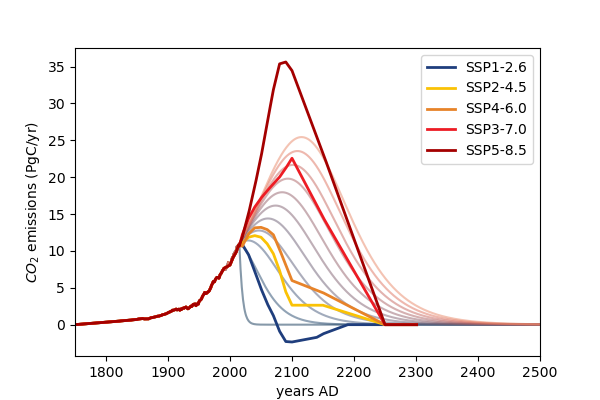

In [16]:
N_scenarios = 12
emissions_tot = np.linspace(50,5000,N_scenarios)

sourceColors = [color_p[1], color_p[4],]
targetColors = cmap(np.linspace(0.1,0.7,11))
ssp_colors = colors = ['#1f3e7d','#fac205','#e78329','#ed1c24','#a40000']
labels = ['SSP1-2.6','SSP2-4.5','SSP4-6.0','SSP3-7.0','SSP5-8.5']

print(emissions_tot)

fig,ax=plt.subplots(1,1,figsize=(6,4))

for i in range(0,11): 

    logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 

    ax.plot(logistic_emissions[0],logistic_emissions[1],c=targetColors[i],alpha=0.5)

    print(np.sum(logistic_emissions[1,:266]),np.sum(logistic_emissions[1,266:]))

for i in range(0,5) :

    ssp_emissions = emissions_ssp(i)
    ax.plot(ssp_emissions[0],ssp_emissions[1]+ssp_emissions[2]*1,c=ssp_colors[i],lw=2,label =labels[i])
    print(np.sum(ssp_emissions[1,:266]+ssp_emissions[2,:266]),np.sum(ssp_emissions[1,266:]+ssp_emissions[2,266:]))

ax.legend()
ax.set_xlim((1750,2500))
ax.set_xlabel('years AD')
ax.set_ylabel(r'$CO_2$ emissions (PgC/yr)')

In [17]:
fig.savefig(os.path.join(figures_path, 'scenarios.pdf'))

In [18]:
print(emissions_ssp(0)[0,0:100])
print(np.sum(emissions_ssp(0)[1,0:100]))
print(np.sum(emissions_ssp(0)[2,0:100]))

[1750. 1751. 1752. 1753. 1754. 1755. 1756. 1757. 1758. 1759. 1760. 1761.
 1762. 1763. 1764. 1765. 1766. 1767. 1768. 1769. 1770. 1771. 1772. 1773.
 1774. 1775. 1776. 1777. 1778. 1779. 1780. 1781. 1782. 1783. 1784. 1785.
 1786. 1787. 1788. 1789. 1790. 1791. 1792. 1793. 1794. 1795. 1796. 1797.
 1798. 1799. 1800. 1801. 1802. 1803. 1804. 1805. 1806. 1807. 1808. 1809.
 1810. 1811. 1812. 1813. 1814. 1815. 1816. 1817. 1818. 1819. 1820. 1821.
 1822. 1823. 1824. 1825. 1826. 1827. 1828. 1829. 1830. 1831. 1832. 1833.
 1834. 1835. 1836. 1837. 1838. 1839. 1840. 1841. 1842. 1843. 1844. 1845.
 1846. 1847. 1848. 1849.]
1.1600000000000001
32.67


## SURFER

In [19]:
# Physics

mA=1.727*10**20
mO=7.8*10**22
carbon_molar_mass=12*10**-3
water_molar_mass=18*10**-3
cvol = 0.13
R = 83.14462 # bar*cm3/mol*K

# Geometry

hu=150
hi=500
hd=3150

WU=mO*water_molar_mass*hu/(hu+hi+hd)
WI=mO*water_molar_mass*hi/(hu+hi+hd)
WD=mO*water_molar_mass*hd/(hu+hi+hd)

ZU = hu/2
ZI = hu+hi/2
ZD = hu+hi+hd/2

Aocean = mO*water_molar_mass/1026/(hu+hi+hd)

# other

print('Ocean area is',Aocean/10**12,'10^6 km^2')

Ocean area is 360.1108033240998 10^6 km^2


In [20]:
# Solubility and dissociation constants with temperature and pressure (depth) dependence

@jit
def k0(T,S) :
     return np.exp(-60.2409+93.4517*(100/T)+23.3585*np.log(T/100)+S*(0.023517-0.023656*(T/100)+0.0047036*(T/100)**2))

@jit
def k1_p(T,S,z) : 
    TC = T-273.15
    mlog10k1 = -62.008+3670.7/T+9.7944*np.log(T)-0.0118*S+0.000116*S**2
    k1_0 = 10**-mlog10k1
    dV = -25.5 + 0.1271*TC
    dK = (-3.08 + 0.0877*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return k1_0*np.exp(C)

@jit
def k2_p(T,S,z) : 
    TC = T-273.15
    mlog10k2 = 4.777+1394.7/T-0.0184*S+0.000118*S**2
    k2_0 = 10**-mlog10k2
    dV = -15.82 - 0.0219*TC
    dK = (1.13 - 0.1475*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return k2_0*np.exp(C)

@jit
def kW_p(T,S,z) : 
    TC = T-273.15
    lnkW = 148.96502 - 13847.26/T - 23.6521*np.log(T)+ S**0.5*(-5.977 + 118.67/T + 1.0495*np.log(T))-0.01615*S
    kW_0 = np.exp(lnkW)
    dV = -25.60 + 0.2324*TC - 0.0036246*TC**2
    dK = (-5.13 + 0.0794*TC)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return kW_0*np.exp(C)

@jit
def kB_p(T,S,z) : 
    TC = T-273.15
    lnkB = 1/T*(-8966.9-2890.53*S**0.5-77.942*S + 1.728*S**1.5-0.0996*S**2)+148.0248+137.1942*S**0.5+1.62142*S+0.053105*S**0.5*T+np.log(T)*(-24.4344-25.085*S**0.5-0.2474*S)
    kB_0 = np.exp(lnkB)
    dV = -29.48 + 0.1622*TC - 0.002608*TC**2
    dK = (-2.84)/1000
    Pbar = 1026*9.81*z/100000
    C = (-dV + 0.5*dK*Pbar)*Pbar/(R*T)
    return kB_0*np.exp(C)

# Function to compute [H^+] (in mol/kg) from DIC and alkalinity masses in a given ocean layer
@jit
def h_from_DICALK_masses(M,Q,T,S,level) :
    
    if level == 'U' :
        WW = WU
        z= ZU
    else : 
        if level == 'I' :
            WW = WI
            z=ZI
        else :  
            WW = WD
            z= ZD 
    
    c= 11.88*10**-6
    
    DIC = M/(WW*carbon_molar_mass*10**-12)
    alk = Q/(WW*carbon_molar_mass*10**-12)
    
    K0= k0(T,S)
    K1 = k1_p(T,S,z) # constants in mol/kg or similar
    K2 = k2_p(T,S,z)
    KB = kB_p(T,S,z)
    KW = kW_p(T,S,z)
    
    q0 = - K1*K2*KB*KW
    q1 = (alk-2*DIC-c*S)*K1*K2*KB - K1*K2*KW - K1*KB*KW
    q2 = (alk-2*DIC+KB)*K1*K2 + (alk-DIC-c*S)*K1*KB-K1*KW-KB*KW
    q3 = (alk-DIC+KB)*K1+(alk-c*S)*KB+K1*K2-KW
    q4 = alk + K1 + KB

    cc2 = KB*(1-c*S/alk)+K1*(1-DIC/alk)
    cc1 = K1*(KB*(1-c*S/alk-DIC/alk)+K2*(1-2*DIC/alk))
    cc0 = K1*K2*KB*(1-(2*DIC+c*S)/alk)
    
    if alk < 0 :
        h0 = 0.001
    elif alk >= 2*DIC+c*S :
        h0 = 10**-10
    else :
        if cc2*cc2-3*cc1 < 0 :
            h0 = 10**-7
        else : 
            sqroot = np.sqrt(cc2*cc2-3*cc1)
            hmin = (-cc2+sqroot)/3
            h0 = hmin +np.sqrt(-(hmin**3+cc2*hmin**2+cc1*hmin+cc0)/sqroot)
    y0 = h0

    for i in range(0,5) :
        y = y0 - (((((y0+q4)*y0+q3)*y0+q2)*y0+q1)*y0 + q0)/((((5*y0+4*q4)*y0+3*q3)*y0+2*q2)*y0 + q1)
        y0 = y
    
    return y0

vh_from_DICALK_masses = np.vectorize(h_from_DICALK_masses)

# Function to compute the buffer factor B_U from DIC and alkalinity masses. 
# Neccessary for the computation of the atmoshere-to-ocean carbon flux (F_AU)
@jit
def BU(M,Q,T,S) :
    H = h_from_DICALK_masses(M,Q,T,S,'U')
    K1 = k1_p(T,S,ZU) # constants in mol/kg or similar
    K2 = k2_p(T,S,ZU)
    return 1/(1+K1/H*(1+K2/H))

vBU =np.vectorize(BU)

# Function to compute the [CO_3--] in the deep ocean layer from DIC and alkalinity masses. 
# Neccessary for the computation of the accumulaton flux (F_acc)
precomp_1 = WD*carbon_molar_mass*10**-12
@jit
def CO32_D(M,Q,T,S) :
    H = h_from_DICALK_masses(M,Q,T,S,'D')
    K1 = k1_p(T,S,ZD) # constants in mol/kg or similar
    K2 = k2_p(T,S,ZD)
    return (M/precomp_1)/(1+H/K2*(1+H/K1))*10**6 # value computed converted back in µmol/kg

# Function to compute the concentration of different species (H+,CO3--,HCO3-,H2CO3,OH-,B(OH)4-) in any ocaen layer 
# based on the DIC and alkalinity masses
@jit
def species_from_DICALK_masses(M,Q,T,S,level) :
    
    if level == 'U' :
        WW = WU
        z= ZU
    else : 
        if level == 'I' :
            WW = WI
            z=ZI
        else :  
            WW = WD
            z= ZD 
    
    c= 11.88*10**-6
    
    DIC = M/(WW*carbon_molar_mass*10**-12)
    alk = Q/(WW*carbon_molar_mass*10**-12)
    
    K0= k0(T,S)
    K1 = k1_p(T,S,z)
    K2 = k2_p(T,S,z)
    KB = kB_p(T,S,z)
    KW = kW_p(T,S,z)
    
    H = h_from_DICALK_masses(M,Q,T,S, level)
    CO3 = DIC/(H/K2+H**2/(K1*K2)+1)*10**6
    HCO3 = H*CO3/K2
    H2CO3 = DIC*10**6 - HCO3 - CO3
    BOH4 = (KB*11.88*S)/(H+KB)
    OH = KW/H*10**6
    
    return H,CO3,HCO3,H2CO3,OH,BOH4

vspecies_from_DICALK_masses =np.vectorize(species_from_DICALK_masses)


# Function used to compute in init_DICU to solve the carbonate system (find H) based on H2CO3 and Alk  
def funcp_H2CO3(x,alk,H2CO3,T,S,z):
    
    c= 11.88*10**-6
    
    h2co3 = H2CO3*10**-6
    Talk = alk*10**-6
    
    K1 = k1_p(T,S,z)
    K2 = k2_p(T,S,z)
    KW = kW_p(T,S,z)
    KB = kB_p(T,S,z)

    return Talk - K1*h2co3/(10**-x[0]) - 2*K2*K1*h2co3/(10**(-2*x[0]))-KW/10**(-x[0])+10**(-x[0])-KB*c*S/(10**(-x[0])+KB)

# Function used to compute the initial DIC concentration in the surface ocean layer, based on alkalinity 
# and such that it is in equilibrium if the initial atmospheric CO2 concentration
def init_DICU(T,S,alk_U,pCO2_A,F_CaCO3_pi=0.065,F_CaSiO3_pi=0.065,K_AU = 4.7):
    MA_pi = pCO2_A*mA*carbon_molar_mass*10**-18
    K0U = k0(T,S)
    K1 = k1_p(T,S,ZU)
    K2 = k2_p(T,S,ZU)
    MH2CO3_pi = ((F_CaCO3_pi + F_CaSiO3_pi)/(K_AU*K0U) + MA_pi)*WU*K0U/mA 
    H2CO3_pi = MH2CO3_pi/(WU*carbon_molar_mass*10**-18)
    root = fsolve(funcp_H2CO3,8.17, args = (alk_U,H2CO3_pi,T,S,ZU))
    H = 10**-root[0]
    HCO3 = H2CO3_pi*K1/H
    CO3 = HCO3*K2/H
    
    return H2CO3_pi + HCO3 + CO3

# Function to convert from PgC to ppm
def PgCtoppm(y):
    return y/(mA*carbon_molar_mass*10**-18)

# Function to convert from PgC to ppb
def PgCtoppb(y):
    return y/(mA*carbon_molar_mass*10**-21)

In [21]:
# Some (fixed) ipact from tipping elements

## CO2 and CH4 potential for release

cpot_GRIS = 0
cpot_WAIS = 0
cpot_EASB = 0
cpot_EAIS = 0
cpot_AWSI = 0
cpot_AMOC = 0
cpot_AMAZ = 75
cpot_PERM = 300

ch4pot_GRIS = 0
ch4pot_WAIS = 0
ch4pot_EASB = 0
ch4pot_EAIS = 0
ch4pot_AWSI = 0
ch4pot_AMOC = 0
ch4pot_AMAZ = 0
ch4pot_PERM = 300*0.025

## SLR potential 

Spot_GRIS = 7
Spot_WAIS = 4
Spot_EASB = 19
Spot_EAIS = 34

In [22]:
# Thermal expansion coefficients

alpha_U = 2.2*10**-4
alpha_I = 1.61*10**-4
alpha_D = 1.39*10**-4

# Function that computes SLR based on the output from a SURFER run
def SLR(sol) :
    S_th = alpha_U*hu*sol.y[9] + alpha_I*hi*sol.y[10] + alpha_D*hd*sol.y[11]
    S_gl = sol.y[14]
    S_GRIS = Spot_GRIS*(1-sol.y[15])
    S_WAIS = Spot_WAIS*(1-sol.y[16])
    S_EASB = Spot_EASB*(1-sol.y[17])
    S_EAIS = Spot_EAIS*(1-sol.y[18])
    return S_th + S_gl + S_GRIS + S_WAIS + S_EASB + S_EAIS

# Function that computes SLR based on the qunatities given from a SURFER run (from sol.y and not sol)
def SLR_alt(sol) :
    S_th = alpha_U*hu*sol[9] + alpha_I*hi*sol[10] + alpha_D*hd*sol[11]
    S_gl = sol[14]
    S_GRIS = Spot_GRIS*(1-sol[15])
    S_WAIS = Spot_WAIS*(1-sol[16])
    S_EASB = Spot_EASB*(1-sol[17])
    S_EAIS = Spot_EAIS*(1-sol[18])
    return S_th + S_gl + S_GRIS + S_WAIS + S_EASB + S_EAIS


In [23]:
def params_setup(
    
    F_CaCO3_pi = 0.065,
    F_CaSiO3_pi = 0.065,
    K_Ca = 0.049,
    K_T = 0.095,
    K_AL = 0.025*1.75,
    beta_L=1.7,
    K_AU = 4.7,
    K_UI = 0.13,       # 0.08 if hd = 2500
    K_ID = 0.009,      # 0.008 if hd = 2500
    K_alk_UI = 0.13,   # 0.08 if hd = 2500
    K_alk_ID = 0.009,  # 0.008 if hd = 2500
    P_org_pi = 7,
    P_CaCO3_pi = 1,
    phi_I_org_pi = 0.72,   
    phi_D_org_pi = 0.22,
    phi_I_CaCO3_pi = 0.15,
    phi_D_CaCO3_pi = 0.39,
    sigma_ALKDIC = -16/117,
    alpha_diss = -0.0107,
    beta_diss = 1.82*10**-5,
    gamma_diss = -4.53*10**-6,
    tau_ch4 = 9.5,

    fco2 = 3.9,
    beta = 1.1143,
    gamma_UI = 0.8357,
    gamma_ID = 0.8357,
    alpha_so2 = 65,
    beta_so2 = 2246,
    gamma_so2 = 0.23,
    delta_so2 = -0.0052,

    Sglpot = 0.5,
    Sglxi = 2,
    taugl = 200,
    fmod_gl = 0):
    
    params = np.array([F_CaCO3_pi,
                        F_CaSiO3_pi,
                        K_Ca,
                        K_T,
                        K_AL,
                        beta_L,
                        K_AU,
                        K_UI, 
                        K_ID,
                        K_alk_UI,
                        K_alk_ID,
                        P_org_pi,
                        P_CaCO3_pi,
                        phi_I_org_pi,   
                        phi_D_org_pi,
                        phi_I_CaCO3_pi,
                        phi_D_CaCO3_pi,
                        sigma_ALKDIC,
                        alpha_diss,
                        beta_diss,
                        gamma_diss,
                        tau_ch4,
                        fco2,
                        beta,
                        gamma_UI,
                        gamma_ID,
                        alpha_so2,
                        beta_so2,
                        gamma_so2,
                        delta_so2,
                        Sglpot,
                        Sglxi,
                        taugl,
                        fmod_gl],dtype=np.float64)
    
    return params

@jit
def smooth_trans(x,k):
    if x < k :
        if x <= 0 :
            return 0
        else :
            a = x/k
            b=(1-2*a)/(a*(1-a))
            return 1/(1+np.exp(b))
    elif x > 1-k :
        if x >= 1 :
            return 0
        else :
            a = (x-1+k)/k
            b=(1-2*a)/(a*(1-a))
            return 1-1/(1+np.exp(b))
    else :
        return 1

@jit
def smooth_trans_2(x,k1,k2):
    if x < k2 :
        if x <= k1 :
            return 0
        else :
            return (x-k1)/(k2-k1)
    elif x > 1-k2 :
        if x >= 1-k1 :
            return 0
        else : 
            return (x-1+k1)/(k1-k2)
    else :
        return 1

vsmooth_trans_2 = np.vectorize(smooth_trans_2)
# @jit
# def smooth_trans_2(x,k1,k2):
#     if x < k2 :
#         return (x-k1)/(k2-k1)
#     elif x > 1-k2 :
#         return (x-1+k1)/(k1-k2)
#     else :
#         return 1



In [24]:
def SURFER_odeint(emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol,**kwargs):
    
    if kwargs['ktemp'] == True :
        ktemp = 1
    else : ktemp = 0
        
    if kwargs['sediments'] == True : 
        sed = 1
    else : sed = 0
        
    if kwargs['weathering'] == True : 
        weathering = 1
    else : weathering = 0
    
    ATOL = np.ones(len(y0))*10**-12
    RTOL = np.ones(len(y0))*10**-4
    ATOL[8:]= 0.5*10**-4
    RTOL[8:]= 10**-12
    
    # RTOL[21]= 10**-5
    # RTOL[20]= 10**-6
    # RTOL[19]= 10**-6
    # ATOL[21]= 10**-5
    # ATOL[20]= 10**-5
    # ATOL[19]= 10**-5

    model_setup = np.array([ktemp,sed,weathering], dtype = np.int32)
    TP_properties,S_couplings,other_couplings = TP_params
    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl,fmod_gl = model_params
      
    V = F_CaSiO3_pi
    K_IU = (P_CaCO3_pi + P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_UI*MU_pi)/MI_pi
    K_DI = ((1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_ID*MI_pi)/MD_pi
    K_alk_IU = (2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_UI*QU_pi)/QI_pi
    K_alk_DI = (2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_ID*QI_pi)/QD_pi
    alpha_bur = (F_CaCO3_pi + F_CaSiO3_pi)/MS_pi

    computed_params = np.array([V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur], dtype=np.float64)

    if interp_sol == True : 
          sol,infodict =odeint(f, y0, teval, tfirst= True, atol = ATOL,rtol = RTOL,full_output=True,args = (emissions,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup,),h0 = 1.0)
   
    else : 
       sol,infodict=odeint(f, y0, teval, tfirst= True, atol = ATOL,rtol = RTOL, full_output=True,args = (emissions,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup,),h0 = 1.0)
   
    return sol,infodict

In [25]:
# Function to integrate
@jit(nopython=True)
def f(t,y,emissions,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup) :

    ## Unpacking parameters
    
    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl,fmod_gl = model_params
    V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur = computed_params
    A2,A1,C1,C0,TAUP,TAUM,FMOD,CPOT,CH4POT = TP_properties
    c_50,c_51, c_52 = other_couplings
    d,epsi,cfeedback = TP_setup
    ktemp, sed, weathering = model_setup

    ## Emissions
    
    co2_em_fossil = np.interp(t,emissions[0],emissions[1])
    co2_em_landuse = np.interp(t,emissions[0],emissions[2])
    ch4_em_fossil = np.interp(t,emissions[0],emissions[3])
    ch4_em_landuse = np.interp(t,emissions[0],emissions[4])
    so2_em_strat = np.interp(t,emissions[0],emissions[5])
    
    ## Fluxes

    K0U= k0(T_U+ktemp*y[9],S_U)
    bu = BU(y[2],y[5],T_U+ktemp*y[9],S_U)
    CO32D = CO32_D(y[4],y[7],T_D+ktemp*y[11],S_D)
    
    F_CaCO3 = F_CaCO3_pi*(1+weathering*K_Ca*y[9])
    F_CaSiO3 = F_CaSiO3_pi*np.exp(weathering*K_T*y[9])
    F_weathering = F_CaCO3 + 2*F_CaSiO3
    F_river = 2*(F_CaCO3+F_CaSiO3)
    
    F_UI = P_CaCO3_pi + P_org_pi + K_UI*y[2]-K_IU*y[3]
    F_ID = (1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi + K_ID*y[3]-K_DI*y[4]
    
    F_accumulation = F_CaCO3_pi+F_CaSiO3_pi - sed*(alpha_diss*(CO32D-CO32D_pi)+beta_diss*(y[8]-MS_pi)+gamma_diss*(CO32D-CO32D_pi)*(y[8]-MS_pi))
    F_burial = sed*(alpha_bur*y[8])+(1-sed)*(F_CaCO3_pi+F_CaSiO3_pi)
    
    F_alk_UI_res = K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID_res = K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_alk_UI =  2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi + K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID =  2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi  + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi + K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/y[0])-(y[1]-y[13])) 
   
    F_AU = K_AU*(y[0]*K0U-mA/(WU)*bu*y[2])
    
    # F_as = alpha_so2*np.exp(-(beta_so2/so2_em_strat)**gamma_so2)
    F_as = 0

    if y[8] > 0 : 
        allow_acc = 1
    else :
        if F_accumulation > 0 :
            allow_acc = 1
        else :
            allow_acc = 0
    
    y[15:][y[15:]<0] = 0  #small mod such that tipping points are always considered to be 0 in 1 for computations. THis may not be the case in plots.
    y[15:][y[15:]>1] = 1

    # v_prep = 1-y[15:].T
    # v_prep[v_prep<0] = 0
    # v_prep[v_prep>1] = 1
    # S_couplings[6,5]=0
    # S_couplings[5,7]=0
    # S_couplings[7,4]=0
    # S_couplings[0,4]=0
    # COUPLING = S_couplings@v_prep
    COUPLING = S_couplings@(1-y[15:].T)
    # COUPLING = S_couplings@np.maximum(1-y[15:].T,0)

    # ky = 0.1
    
    # TP_forcing = y[9]-d*COUPLING/C1
    # H = -y[15:]**3+A2*y[15:]**2+A1*y[15:]+C1*y[9]+C0-d*COUPLING
    # H_p = -(1-ky)**3+(1-ky)**2*A2+(1-ky)*A1+C1*y[9]+C0-d*COUPLING
    # H_m = -(ky)**3+(ky)**2*A2+(ky)*A1+C1*y[9]+C0-d*COUPLING
    
    # for i in range(0,len(y)-15) :
    #     if (TP_forcing[i]< 0 and y[15+i]>1-ky) :
    #         H[i] = H_p[i]*(1-y[15+i])/ky
    #     if (TP_forcing[i]> -(C0[i]/C1[i]) and y[15+i]<ky) :
    #         H[i] = H_m[i]*y[15+i]/ky

    # TAU = TAUM + 0.5*(TAUP-TAUM)*(1+np.tanh(H/0.001))
    # MU = 1/TAU
    
    # H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
    # H_p[5] = H_p[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
    # H_m[5] = H_m[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])

    # for i in [5] :
    #     if (TP_forcing[i]< 0 and y[15+i]>1-ky) :
    #         H[i] = H_p[i]*(1-y[15+i])/ky
    #     if (TP_forcing[i]> -(C0[i]/C1[i]) and y[15+i]<ky) :
    #         H[i] = H_m[i]*y[15+i]/ky

    # TAU[5] = TAUM[5] + 0.5*(TAUP[5]-TAUM[5])*(1+np.tanh(H[5]/0.001))
    # MU[5] = 1/TAU[5]


    
    H = -y[15:]**3+A2*y[15:]**2+A1*y[15:]+C1*y[9]+C0-d*COUPLING
  
    TAU = TAUM + 0.5*(TAUP-TAUM)*(1+np.tanh(H/0.001))
    MU = 1/TAU

    ###########
    
    # ky = 0.05
    
    # for i in range(0,len(y)-15) :
    #     if (H[i]>0 and y[15+i]>1-ky) or (H[i]<0 and y[15+i]<ky) :
    #         MU[i] = MU[i]*smooth_trans(y[15+i],ky)

    # ## add coupling for AMOC (need derivatives)

    # H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
    # if (H[5]>0 and y[15+5]>1-ky) or (H[5]<0 and y[15+5]<ky) :
    #     MU[5] = MU[5]*smooth_trans(y[15+5],ky)

    #########

    ky1 = 0.005
    ky2 = 0.01
    
    for i in range(0,len(y)-15) :
        if (H[i]>0 and y[15+i]>1-ky2) or (H[i]<0 and y[15+i]<ky2) :
        # if (H[i]<0 and y[15+i]<ky2) :
        # if (forcings0[i]< 0 and y[15+i]>1-ky2) or (forcings0[i]> (-C0[i]/C1[i]) and y[15+i]<ky2) :
        # if (y[15+i]>1-ky2) or (y[15+i]<ky2) :
            MU[i] = MU[i]*smooth_trans_2(y[15+i],ky1,ky2)

    ##add coupling for AMOC (need derivatives)

    H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
    if (H[5]>0 and y[15+5]>1-ky2) or (H[5]<0 and y[15+5]<ky2) :
    # if  (H[5]<0 and y[15+5]<ky2) :
    # if (forcings0[5]< 0 and y[15+5]>1-ky2) or (forcings0[5]> (-C0[5]/C1[5]) and y[15+5]<ky2) :
    # if (y[15+5]>1-ky2) or (y[15+5]<ky2) :
        MU[5] = MU[5]*smooth_trans_2(y[15+5],ky1,ky2)

    #########

    # for i in range(0,len(y)-15) :
    #     if (H[i]>0 and y[15+i]>0.995) or (H[i]<0 and y[15+i]<0.005) :
    #         MU[i] = 0

    # ## add coupling for AMOC (need derivatives)

    # H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
    # if (H[5]>0 and y[15+5]>0.995) or (H[5]<0 and y[15+5]<0.005) :
    #     MU[5] = 0

    ###############

    ## add emissions from TEs

    co2_em_tps_0 = CPOT*(MU*H)*-1
    ch4_em_tps_0 = CH4POT*(MU*H)*-1

    co2_em_tps = cfeedback*(np.sum(co2_em_tps_0) + np.sum(ch4_em_tps_0[ch4_em_tps_0<0]))
    ch4_em_tps =cfeedback*(np.sum(ch4_em_tps_0[ch4_em_tps_0>0]))

    ## Radiative forcing changes from tipping elements and nonlinear components

  #  R_GL = fmod_gl*1.1143*0.08*(y[14]/Sglpot)**(1/1.375)
    R_GRIS = FMOD[0]*(1-y[15]**0.8)
    R_WAIS = FMOD[1]*(1-y[16]**0.8)
    R_EASB = FMOD[2]*(1-y[17]**0.8)
    R_EAIS = FMOD[3]*(1-y[18]**0.8)
    
    FMOD_tps = (R_GRIS + R_WAIS + R_EASB + R_EAIS)*epsi
    
    ## Computation of dy
            
    dy = np.zeros(len(y))
    
    dy[0] = V + co2_em_landuse + co2_em_fossil - F_AU - F_AL - F_weathering + (y[12]-Mch4_pi)/tau_ch4 + co2_em_tps

    dy[1] = F_AL - co2_em_landuse - ch4_em_landuse - co2_em_tps - ch4_em_tps
    
    dy[2] = F_AU - F_UI + F_river
    dy[3] = F_UI - F_ID
    dy[4] = F_ID - F_accumulation*allow_acc 

    dy[5] =  - F_alk_UI + F_river
    dy[6] = F_alk_UI - F_alk_ID
    dy[7] = F_alk_ID - 2*F_accumulation*allow_acc

    dy[8] = (F_accumulation - F_burial)*allow_acc

    dy[9] = (fco2*np.log2(y[0]/MA_pi)+0.036*((y[12]*482.5323296660876)**0.5-ch4_pi**0.5)-F_as-beta*y[9]+FMOD_tps-gamma_UI*(y[9]-y[10]))/(cvol*hu)
    
    dy[10] = (gamma_UI*(y[9]-y[10])-gamma_ID*(y[10]-y[11]))/(cvol*hi)
    dy[11] = gamma_ID*(y[10]-y[11])/(cvol*hd)

    dy[12] = (Mch4_pi-y[12])/tau_ch4 + ch4_em_landuse + ch4_em_fossil + ch4_em_tps
    dy[13] = -co2_em_landuse - co2_em_tps - ch4_em_tps
    
    dy[14] = (Sglpot*np.tanh(y[9]/Sglxi)-y[14])/taugl
    
    dy[15:] = MU*H
    
    return dy

In [26]:
T_U = 273.15 + 15.23
S_U = 34.93379791 
alk_U = 2310.6063
pCO2_A = 280
DIC_U = init_DICU(T_U,S_U,alk_U,pCO2_A)


T_D = 273.15 + 2.61
S_D = 34.7019
alk_D = 2367.2144
DIC_D = 2266.5701

T_I = 273.15 + 8.60
S_I = 34.77301675  
alk_I = 2310.6017
DIC_I = 2152.62275144

ch4_pi = 720

MA_pi = pCO2_A*mA*carbon_molar_mass*10**-18
ML_pi = 2200 + cpot_PERM + cpot_AMAZ + ch4pot_PERM
MU_pi = DIC_U*WU*carbon_molar_mass*10**-18
MI_pi = DIC_I*WI*carbon_molar_mass*10**-18
MD_pi = DIC_D*WD*carbon_molar_mass*10**-18
QU_pi = alk_U*WU*carbon_molar_mass*10**-18
QI_pi = alk_I*WI*carbon_molar_mass*10**-18
QD_pi = alk_D*WD*carbon_molar_mass*10**-18
MS_pi = 1600
Mch4_pi = ch4_pi*mA*carbon_molar_mass*10**-21

CO32D_pi = CO32_D(MD_pi,QD_pi,T_D,S_D)

y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1]


## Inclusion of tipping elements and other nonlinear components

### Mathematical calibration

In [27]:
## Functions to get parameters for tippig elements

@jit
def xm_today(op,om,xp) :
   # G = (op+om+2*(op*om)**0.5)/(op-om)
    G = (op+om+2*cmath.sqrt(op*om))/(op-om)
    xm = (-2+xp*(1+G**(1/3)+G**(-1/3)))/(-1+G**(1/3)+G**(-1/3))
    return xm.real

@jit
def a2(op,om,xp,xm):
    return 3/2*(xp+xm)
    
@jit
def a1(op,om,xp,xm):
    return -3*xp*xm

@jit
def c1(op,om,xp,xm):
    return -(xp-xm)**3/(2*(op-om))

@jit
def c0(op,om,xp,xm):
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))

@jit
def params(op,om,xp) : 
    xm = xm_today(op,om,xp)
    a_2 = a2(op,om,xp,xm)
    a_1 = a1(op,om,xp,xm)
    c_1 = c1(op,om,xp,xm)
    c_0 = c0(op,om,xp,xm)
    return a_2,a_1,c_1,c_0


## Function to get parameters for monostable nonlinear components

@jit
def params_NLC(TI,yI,dI) :
    Q = (yI-1)**3/(yI-TI*dI-1)
    a_2 = 3*yI
    a_1 = Q - 3*yI**2
    c_1 = -dI*Q
    c_0 = 1-a_1-a_2
    return a_2,a_1,c_1,c_0

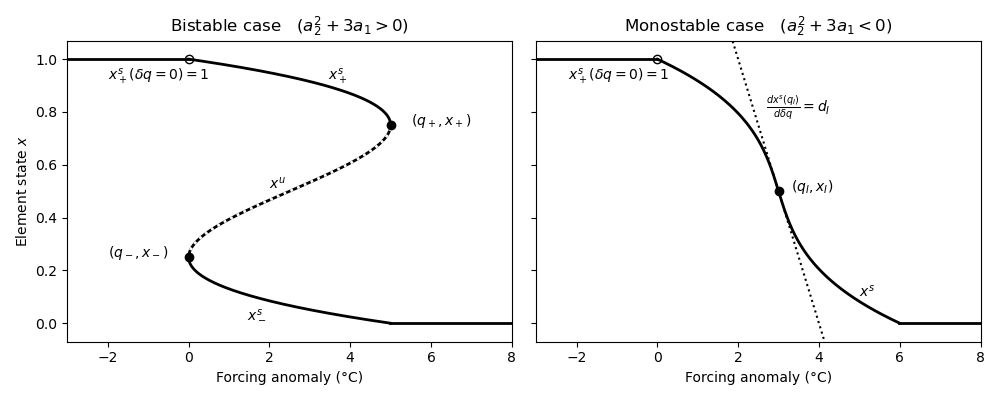

In [28]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,4),sharey = True)

# bistable case

Tp = 5
Tm = 0
Vp = 0.75
Vm = 0.25

A2, A1, C1, C0 = params(Tp,Tm,Vp)

x = np.linspace(-0.8,1.2,10000)
y = -(-x**3+A2*x**2+A1*x+C0)/C1

mask = (x >= Vm) & (x <= Vp)
mask2 = (x>0) & (x<1) 
ax1.plot(y[mask2],x[mask2],c='k',lw='2')
ax1.plot(y[mask],x[mask],c='w',lw='2',ls=':')
ax1.plot([y[x>0][0],17],[0,0],c='k',lw='2')
ax1.plot([0,-17],[1,1],c='k',lw='2')

ax1.plot([0,Tp],[0.25,0.75],'ko')
ax1.plot([0],[1],'ko',markerfacecolor ='none')

ax1.annotate(r'$(q_+,x_+)$', (5.5,0.75))
ax1.annotate(r'$(q_-,x_-)$', (-2,0.25))

ax1.annotate(r'$x^s_+$', (3.45,0.92))
ax1.annotate(r'$x^s_-$', (1.45,0.02))
ax1.annotate(r'$x^u$', (2,0.51))

ax1.annotate(r'$x^s_+(\delta q=0) = 1$', (-2,0.92))

ax1.set_title(r'Bistable case   ($a_2^2 + 3a_1 > 0$)')

ax1.set_xlim((-3,8))
ax1.set_ylim((-0.07,1.07))

# monostable case

TI = 3
yI = 0.5
dI = -1/2

A2, A1, C1, C0 = params_NLC(TI,yI,dI)

x = np.linspace(-0.8,1.2,1000)
y = -(-x**3+A2*x**2+A1*x+C0)/C1

mask = (x > 0) & (x<1)
ax2.plot(y[mask],x[mask],c='k',lw='2')

T = np.linspace(0,10,100)
ax2.plot(T,yI+dI*(T-TI),'k:')

ax2.plot([y[x>0][0],17],[0,0],c='k',lw='2')
ax2.plot([0,-17],[1,1],c='k',lw='2')

ax2.plot([TI],[yI],'ko')
ax2.plot([0],[1],'ko',markerfacecolor ='none')

ax2.set_xlim((-3,8))
ax2.set_ylim((-0.07,1.07))

ax2.annotate(r'$(q_I,x_I)$', (3.3,0.5))
ax2.annotate(r'$\frac{dx^s(q_I)}{d\delta q} = d_I$', (2.7,0.8))

ax2.annotate(r'$x^s$', (5,0.1))


ax2.annotate(r'$x^s_+(\delta q=0) = 1$', (-2.2,0.92))

ax2.set_title(r'Monostable case   ($a_2^2 + 3a_1 < 0$)')

ax1.set_xlabel(r'Forcing anomaly (°C)')
ax1.set_ylabel(r'Element state $x$')
ax2.set_xlabel(r'Forcing anomaly (°C)')

plt.tight_layout()

In [29]:
fig.savefig(os.path.join(figures_path, 'math_calibration.pdf'))

### Time scales

While our parameter $\tau_i$ does influence the transition time of tipping element (or nonliniear component) $i$, it is not directly equivalent. In the litterature, and particularly in McKay et al. (2022), transition times are often given. Here we try to find intervals for $\tau_i$ such that the effctive tipping trnasition time of element $i$ is in the bounds from the litterature. 

In [30]:
# Function that returns times [t0,t1,t2,....,tn] that define intervals [t0,t1], [t2,t3], ..., where y(t) is smaller than a cosntant M

def intervals_where_y_less_than_M(t,y,M) :
    # Step 1: Identify all times where y < M
    mask = y < M
    # Get all times where y < M
    times_y_less_than_M = t[mask]
    transitions = np.where(np.diff(mask) == 1)[0] 
    transition_times =t[transitions] + (M-y[transitions])/(y[transitions+1]-y[transitions])*(t[transitions+1]-t[transitions])

    if y[-1]< M :
        transition_times = np.append(transition_times,t[-1])
        
    return transition_times


# Function that returns the time it takes for y(t) to transition from y=a to y=b . Only returns the transition time for the first trnasition from a to b.

def time_from_a_to_b(t,y,a,b) :
    times = intervals_where_y_less_than_M(t,y,a)
    t_start = times[0]
    times = intervals_where_y_less_than_M(t,y,b)
    t_end = times[0]
    return t_end-t_start, [t_start,t_end]


# Function that returns the rhs of the ODE for a tipping/nonlinear element, forced by temeprature changes.

@jit
def f_element(t,y,A2, A1, C1, C0,TAU,time_temp,temp):

    ## Forcings
    
    T = np.interp(t,time_temp,temp)
   
    y[y<0] = 0  # small mod such that tipping points are always considered to be 0 in 1 for computations. THis may not be the case in plots.
    y[y>1] = 1

    H = -y[0]**3+A2*y[0]**2+A1*y[0]+C1*T+C0
    MU = H*0
    
    if (H>0 and y[0]<0.995) or (H<0 and y[0]>0.005) :
        MU = 1/TAU
    else :
        MU = 1/TAU*smooth_trans_2(y[0],0.001,0.005)
        
    ## Computation of dy
            
    dy = np.zeros(len(y))
    
    dy[0] =  MU*H
    
    return dy

# Function that integrates in time the evolution of a single tipping element, given a temeprature forcing

def TP_unique(y0,teval,Tp,Tm,yp,TAU,time_temp,temp):
    
    A2, A1, C1, C0 = params(Tp,Tm,yp)
    # print(Tp,Tm,yp,TAU)
    sol=solve_ivp(f_element, [teval[0],teval[-1]], y0,method= 'LSODA',atol = 10**-4,rtol = 10**-4, args = (A2, A1, C1, C0,TAU,time_temp,temp,),first_step = 1.0)
    
    return sol


# Function that integrates in time the evolution of a single monostable nonlinear element, given a temeprature forcing

def NLC_unique(y0,teval,TI,yI,dI,TAU,time_temp,temp):
    
    A2, A1, C1, C0 = params_NLC(TI,yI,dI)
    
    sol=solve_ivp(f_element, [teval[0],teval[-1]], y0,method= 'LSODA',atol = 10**-4,rtol = 10**-4, args = (A2, A1, C1, C0,TAU,time_temp,temp,),first_step = 1.0)
    
    return sol


# For a tipping element : Function that calibrate tau such that the effective transition time scale is equal to a target tranition time scale,
# for a constant temeprature that is equal to T_crit + T_over

def TP_fit_tau_to_transition_timescale(Tp,Tm,yp,target_transition_time,T_over) :

    tol = 10**-2
    proposed_tau = target_transition_time
    transition_time = tol+1
    ym = xm_today(Tp,Tm,yp)
  
    while np.abs(transition_time-target_transition_time)> tol :
       
        sol = TP_unique([1],np.logspace(0,6,1000),Tp,Tm,yp,proposed_tau,np.logspace(0,5,1000),np.ones(1000)*T_over+Tp)
        transition_time,times_trans = time_from_a_to_b(sol.t,sol.y[0],yp,np.maximum(ym,0.05))
        proposed_tau = proposed_tau*target_transition_time/transition_time
       
    return proposed_tau


# For a monostable nonlinear element : Function that calibrate tau such that the effective transition time scale is equal to a target transition time scale,
# for a constant temeprature that is equal to T_crit + T_over

def NLC_fit_tau_to_transition_timescale(TI,yI,dI,target_transition_time,T_over) :

    tol = 10**-2
    proposed_tau = target_transition_time
    transition_time = tol+1
    
    while np.abs(transition_time-target_transition_time)> tol :
       
        sol = NLC_unique([1],np.logspace(0,6,1000),TI,yI,dI,proposed_tau,np.logspace(0,5,1000),np.ones(1000)*T_over+TI)
        transition_time,times_trans = time_from_a_to_b(sol.t,sol.y[0],1,yI)
        proposed_tau = proposed_tau*target_transition_time/transition_time
        
    return proposed_tau


In [31]:
Tcrit_best = np.array([1.5,1.5,3,7.5,6.3,4,3.5,4])
transition_timescale_l = np.array([1000,500,500,5000,10,15,50,10])
transition_timescale_u = np.array([15000,13000,10000,15000,100,300,200,300])
tau_u = np.zeros(8)
tau_l = np.zeros(8)

for i in [0,1,2,3,5,6] :
    tau_l[i] =  TP_fit_tau_to_transition_timescale(Tcrit_best[i],0,0.75,transition_timescale_l[i],3)
    tau_u[i] =  TP_fit_tau_to_transition_timescale(Tcrit_best[i],0,0.75,transition_timescale_u[i],1)

for i in [4] :
    tau_l[i] =  NLC_fit_tau_to_transition_timescale(Tcrit_best[i],0.5,-0.75/1,transition_timescale_l[i],3)
    tau_u[i] =  NLC_fit_tau_to_transition_timescale(Tcrit_best[i],0.5,-0.75/1,transition_timescale_u[i],1)

for i in [7] :
    tau_l[i] =  NLC_fit_tau_to_transition_timescale(Tcrit_best[i],0.5,-1/4,transition_timescale_l[i],3)
    tau_u[i] =  NLC_fit_tau_to_transition_timescale(Tcrit_best[i],0.5,-1/4,transition_timescale_u[i],1)

print(tau_l)
print(tau_u)

[306.28707446 153.14437742  88.43833364 470.3116872    1.86983547
   2.1522638    7.89811907   5.29807632]
[1981.43473823 1717.24359175  839.17547636  740.58710693    8.41052683
   21.15162594   15.27416797   76.27464556]


### Creation of the Monte-Carlo ensemble

In [32]:
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=31,optimization="random-cd")
N_params=100
sample = sampler.random(N_params)
print(qmc.discrepancy(sample))

7.138467314915971


In [33]:
beta_0 = 1.3

fmod_GRIS = 0.13*beta_0
fmod_WAIS = 0.05*beta_0
fmod_EASB = 0.05*beta_0
fmod_EAIS = 0.60*beta_0


print(fmod_GRIS,fmod_WAIS,fmod_EASB,fmod_EAIS)

0.169 0.065 0.065 0.78


In [34]:
Tcrit_l = np.array([0.8,1,2,5,4.5,1.4,2,3])
Tcrit_u = np.array([3,3,6,10,8.7,8,6,6])
Tcrit_best = np.array([1.5,1.5,3,7.5,6.3,4,3.5,4])

coupling_bounds = np.array([
    [  0   ,   1/3 ],    # WAIS -> GRIS        
    [  0   ,   1/3 ],    # EASB -> GRIS
    [  0   ,   1/3 ],    # AWSI -> GRIS
    [ -1   ,  -2/3 ],    # AMOC -> GRIS
    [  1/3 ,   2/3 ],    # GRIS -> WAIS
    [  0   ,   1   ],    # AMOC -> WAIS
    [  1/3 ,   2/3 ],    # GRIS -> EASB # same as for WAIS
    [  0   ,   1   ],    # AMOC -> EASB
    [ -2/3 ,   0   ],    # AMOC -> AWSI
    [  0   ,   2/3 ],    # AWSI -> AMOC
    [  0   ,   1   ],    # PERM -> AMOC
    [ -2/3 ,   2/3 ],    # AMOC -> AMAZ
    [  0   ,   1/3 ],    # AWSI -> PERM
    [  2   ,  10   ],
    [ -20/3,  20/3 ]
])



l_bounds = np.concatenate((Tcrit_l,tau_l,coupling_bounds[:,0]))
u_bounds = np.concatenate((Tcrit_u,tau_u,coupling_bounds[:,1]))

sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

TP_TCRIT = np.zeros((N_params,8))
TP_PROP = np.zeros((N_params,9,8))
S_COUPLINGS = np.zeros((N_params,8,8))
OTHER_COUPLINGS = np.zeros((N_params,3))

for i in range(0,N_params):
    
    # 0 - GRIS
    Tp_GRIS = sample_scaled[i][0]
    Tm_GRIS = 0
    Vp_GRIS = 0.75
    taup_GRIS = 5500
    taum_GRIS = sample_scaled[i][8+0]
    
    # 1 - WAIS
    Tp_WAIS = sample_scaled[i][1]
    Tm_WAIS = 0
    Vp_WAIS = 0.75
    taup_WAIS = 5500
    taum_WAIS = sample_scaled[i][8+1]
    
    # 2 - EASB
    Tp_EASB = sample_scaled[i][2]
    Tm_EASB = 0
    Vp_EASB = 0.75
    taup_EASB = 5500
    taum_EASB = sample_scaled[i][8+2]
    
    # 3 - EAIS
    Tp_EAIS = sample_scaled[i][3]
    Tm_EAIS = 0
    Vp_EAIS = 0.75
    taup_EAIS = 5500
    taum_EAIS = sample_scaled[i][8+3]
    
    # 4 - AWSI
    TI_AWSI = sample_scaled[i][4]
    VI_AWSI = 0.5
    dI_AWSI = -0.5
    taup_AWSI = sample_scaled[i][8+4]
    taum_AWSI = taup_AWSI
    
    # 5 - AMOC
    Tp_AMOC =sample_scaled[i][5]
    Tm_AMOC = 0
    Vp_AMOC = 0.75
    taup_AMOC = sample_scaled[i][8+5]
    taum_AMOC = taup_AMOC
    
    # 6 - AMAZ
    Tp_AMAZ = sample_scaled[i][6]
    Tm_AMAZ = 0
    Vp_AMAZ = 0.75
    taup_AMAZ = sample_scaled[i][8+6]
    taum_AMAZ = taup_AMAZ
    
    # 7 - PERM
    TI_PERM = sample_scaled[i][7]
    VI_PERM = 0.5
    dI_PERM = -1/4
    taup_PERM = 3000
    taum_PERM = sample_scaled[i][8+7]
    
    a2_GRIS,a1_GRIS,c1_GRIS,c0_GRIS = params(Tp_GRIS,Tm_GRIS,Vp_GRIS)
    a2_WAIS,a1_WAIS,c1_WAIS,c0_WAIS = params(Tp_WAIS,Tm_WAIS,Vp_WAIS)
    a2_EASB,a1_EASB,c1_EASB,c0_EASB = params(Tp_EASB,Tm_EASB,Vp_EASB)
    a2_EAIS,a1_EAIS,c1_EAIS,c0_EAIS = params(Tp_EAIS,Tm_EAIS,Vp_EAIS)
    a2_AWSI,a1_AWSI,c1_AWSI,c0_AWSI = params_NLC(TI_AWSI,VI_AWSI,dI_AWSI)
    a2_AMOC,a1_AMOC,c1_AMOC,c0_AMOC = params(Tp_AMOC,Tm_AMOC,Vp_AMOC)
    a2_AMAZ,a1_AMAZ,c1_AMAZ,c0_AMAZ = params(Tp_AMAZ,Tm_AMAZ,Vp_AMAZ)
    a2_PERM,a1_PERM,c1_PERM,c0_PERM = params_NLC(TI_PERM,VI_PERM,dI_PERM)
    
    # Couplings between tipping points
    
    S_moy = np.zeros((8,8))
    S_couplings = np.zeros((8,8))
    
    S_moy[0,1] = sample_scaled[i][16] # WAIS -> GRIS
    S_moy[0,2] = sample_scaled[i][17] # EASB -> GRIS
    S_moy[0,4] = sample_scaled[i][18] # AWSI -> GRIS
    S_moy[0,5] = sample_scaled[i][19] # AMOC -> GRIS
    
    S_moy[1,0] = sample_scaled[i][20] # GRIS -> WAIS
    S_moy[1,5] = sample_scaled[i][21] # AMOC -> WAIS
    
    S_moy[2,0] = sample_scaled[i][22] # GRIS -> EASB # same as for WAIS
    S_moy[2,5] = sample_scaled[i][23] # AMOC -> EASB
    
    S_moy[4,5] = sample_scaled[i][24] # AMOC -> AWSI
    
    S_moy[5,4] = sample_scaled[i][25] # AWSI -> AMOC
    S_moy[5,7] = sample_scaled[i][26] # PERM -> AMOC
    
    S_moy[6,5] = sample_scaled[i][27] # AMOC -> AMAZ

    S_moy[7,4] = sample_scaled[i][28] # AWSI -> PERM

    S_couplings[0] = S_moy[0]*c1_GRIS*Tp_GRIS*-1
    S_couplings[1] = S_moy[1]*c1_WAIS*Tp_WAIS*-1
    S_couplings[2] = S_moy[2]*c1_EASB*Tp_EASB*-1
    S_couplings[3] = S_moy[3]*c1_EAIS*Tp_EAIS*-1
    S_couplings[4] = S_moy[4]*c1_AWSI*TI_AWSI*-1
    S_couplings[5] = S_moy[5]*c1_AMOC*Tp_AMOC*-1
    S_couplings[6] = S_moy[6]*c1_AMAZ*Tp_AMAZ*-1
    S_couplings[7] = S_moy[7]*c1_PERM*TI_PERM*-1
    
    Spot_GRIS = 7
    Spot_WAIS = 4
    Spot_EASB = 19
    Spot_EAIS = 34
    
    c_50 = sample_scaled[i][29]*11.41*Spot_GRIS*1/16 # dGRIS -> AMOC
    c_51 = sample_scaled[i][30]*11.41*Spot_WAIS*1/16 # dWAIS -> AMOC
    c_52 = 0 # dEASB -> AMOC
    
    # Feedback on radiative forcing

    beta_0 = 1.3
    
    fmod_GRIS = 0.13*beta_0
    fmod_WAIS = 0.05*beta_0
    fmod_EASB = 0.05*beta_0
    fmod_EAIS = 0.60*beta_0
    fmod_AWSI = 0.00*beta_0
    fmod_AMOC = 0.00*beta_0
    fmod_AMAZ = 0.00*beta_0
    fmod_PERM = 0.00*beta_0
    
    # Feedback on emmissions
    
    cpot_GRIS = 0
    cpot_WAIS = 0
    cpot_EASB = 0
    cpot_EAIS = 0
    cpot_AWSI = 0
    cpot_AMOC = 0
    cpot_AMAZ = 75
    cpot_PERM = 300 
    
    ch4pot_GRIS = 0
    ch4pot_WAIS = 0
    ch4pot_EASB = 0
    ch4pot_EAIS = 0
    ch4pot_AWSI = 0
    ch4pot_AMOC = 0
    ch4pot_AMAZ = 0
    ch4pot_PERM = 300*0.025
    
    A2 = np.array([a2_GRIS,a2_WAIS,a2_EASB,a2_EAIS,a2_AWSI,a2_AMOC,a2_AMAZ,a2_PERM])
    A1 = np.array([a1_GRIS,a1_WAIS,a1_EASB,a1_EAIS,a1_AWSI,a1_AMOC,a1_AMAZ,a1_PERM])
    C1 = np.array([c1_GRIS,c1_WAIS,c1_EASB,c1_EAIS,c1_AWSI,c1_AMOC,c1_AMAZ,c1_PERM])
    C0 = np.array([c0_GRIS,c0_WAIS,c0_EASB,c0_EAIS,c0_AWSI,c0_AMOC,c0_AMAZ,c0_PERM])
    TAUP = np.array([taup_GRIS,taup_WAIS,taup_EASB,taup_EAIS,taup_AWSI,taup_AMOC,taup_AMAZ,taup_PERM])
    TAUM = np.array([taum_GRIS,taum_WAIS,taum_EASB,taum_EAIS,taum_AWSI,taum_AMOC,taum_AMAZ,taum_PERM])
    TCRIT = np.array([Tp_GRIS,Tp_WAIS,Tp_EASB,Tp_EAIS,TI_AWSI,Tp_AMOC,Tp_AMAZ,TI_PERM])
    
    FMOD = np.array([fmod_GRIS,fmod_WAIS,fmod_EASB,fmod_EAIS,fmod_AWSI,fmod_AMOC,fmod_AMAZ,fmod_PERM])
    CPOT = np.array([cpot_GRIS,cpot_WAIS,cpot_EASB,cpot_EAIS,cpot_AWSI,cpot_AMOC,cpot_AMAZ,cpot_PERM])
    CH4POT = np.array([ch4pot_GRIS,ch4pot_WAIS,ch4pot_EASB,ch4pot_EAIS,ch4pot_AWSI,ch4pot_AMOC,ch4pot_AMAZ,ch4pot_PERM])
    
    TP_properties = np.array([A2,A1,C1,C0,TAUP,TAUM,FMOD,CPOT,CH4POT],dtype=np.float64)
    
    other_couplings = np.array([c_50,c_51,c_52], dtype = np.float64)
    
    TP_params = [TP_properties,S_couplings, other_couplings]

    TP_TCRIT[i]  = TCRIT
    TP_PROP[i] = TP_properties
    S_COUPLINGS[i] = S_couplings
    OTHER_COUPLINGS[i] = other_couplings


In [35]:



filename = 'tp_crit.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('elements', 8)

# Create a variable to store the data
data_var = ncfile.createVariable('TP_crit', np.float64, ('params_set', 'elements'))

# Write the data into the NetCDF variable
data_var[:] = TP_TCRIT

ncfile.close()

filename = 'tp_prop.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('quantities', 9)
ncfile.createDimension('elements', 8)

# Create a variable to store the data
data_var = ncfile.createVariable('TP_prop', np.float64, ('params_set','quantities','elements'))

# Write the data into the NetCDF variable
data_var[:] = TP_PROP

ncfile.close()

filename = 'S_couplings.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('elements', 8)

# Create a variable to store the data
data_var = ncfile.createVariable('couplings', np.float64, ('params_set','elements','elements'))

# Write the data into the NetCDF variable
data_var[:] = S_COUPLINGS

ncfile.close()

filename = 'other_couplings.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('dim1', 3)

# Create a variable to store the data
data_var = ncfile.createVariable('other_couplings', np.float64, ('params_set','dim1'))

# Write the data into the NetCDF variable
data_var[:] = OTHER_COUPLINGS

ncfile.close()


In [36]:
# Open the NetCDF file without loading everything into memory

ncfile_TP_CRIT = Dataset('tp_crit.nc', mode='r')
ncfile_TP_PROP = Dataset('tp_prop.nc', mode='r')
ncfile_S_COUPLINGS = Dataset('S_couplings.nc', mode='r')
ncfile_OTHER_COUPLINGS = Dataset('other_couplings.nc', mode='r')

TP_TCRIT = np.array(ncfile_TP_CRIT.variables['TP_crit'])
TP_PROP = np.array(ncfile_TP_PROP.variables['TP_prop'])
S_COUPLINGS = np.array(ncfile_S_COUPLINGS.variables['couplings'])
OTHER_COUPLINGS = np.array(ncfile_OTHER_COUPLINGS.variables['other_couplings'])


In [37]:
print(TP_TCRIT[:,7]*TP_PROP[:,2,7]*16)

[-3.89113902 -5.56550049 -3.4903176  -3.05152745 -3.01282956 -4.71204176
 -3.01523259 -3.73715684 -3.17921088 -3.09104389 -3.78929011 -5.42609077
 -3.45988911 -4.40991617 -3.79504091 -3.07113374 -4.67213614 -3.27097378
 -3.32844791 -3.50344327 -3.03405948 -3.4129105  -5.06929285 -3.23234303
 -4.35459175 -3.11138903 -4.80825921 -4.17160689 -3.57622909 -4.02287464
 -4.19628946 -4.37804252 -3.63527177 -5.61449752 -3.29056416 -5.14816575
 -3.72104785 -3.3538476  -4.13747464 -4.89368184 -3.21154608 -3.65045821
 -3.13724029 -3.14680788 -4.57671256 -3.07373772 -4.50156392 -3.25698197
 -3.45447886 -5.32941659 -3.04196407 -3.59123284 -3.00722107 -4.49149333
 -4.99195587 -3.10457464 -3.02500832 -4.097957   -3.42497914 -4.85911757
 -3.54348929 -4.06894847 -5.80912617 -3.82977709 -3.98406273 -4.31459765
 -3.15779729 -3.289308   -3.51953822 -3.12162242 -5.25374473 -3.55019862
 -3.34022523 -3.9683964  -5.8942638  -3.05960897 -3.37774852 -3.2294074
 -5.19726476 -3.61221016 -4.63172784 -3.8602422  -3.

In [38]:
print(np.min(TP_PROP[:,5,4]))
print(np.max(TP_PROP[:,5,4]))

1.8780787894149875
8.404842032794727


## Coupled runs

In [39]:
y0 = [MA_pi,ML_pi,MU_pi,MI_pi,MD_pi,QU_pi,QI_pi,QD_pi,MS_pi,0,0,0,Mch4_pi,ML_pi,0,1,1,1,1,1,1,1,1]
model_params = params_setup(beta=1.1143*3.5/3.5,fmod_gl=0)
model_params_ecs5 = params_setup(beta=1.1143*3.5/5,fmod_gl=0)
N_teval =1000
teval = np.logspace(log10(1850),5,N_teval)

N_scenarios=100
emissions_tot = np.linspace(50,5000,N_scenarios)

N_params = 100


In [40]:
print(emissions_tot)

[  50.  100.  150.  200.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  800.  850.  900.  950. 1000. 1050. 1100. 1150. 1200.
 1250. 1300. 1350. 1400. 1450. 1500. 1550. 1600. 1650. 1700. 1750. 1800.
 1850. 1900. 1950. 2000. 2050. 2100. 2150. 2200. 2250. 2300. 2350. 2400.
 2450. 2500. 2550. 2600. 2650. 2700. 2750. 2800. 2850. 2900. 2950. 3000.
 3050. 3100. 3150. 3200. 3250. 3300. 3350. 3400. 3450. 3500. 3550. 3600.
 3650. 3700. 3750. 3800. 3850. 3900. 3950. 4000. 4050. 4100. 4150. 4200.
 4250. 4300. 4350. 4400. 4450. 4500. 4550. 4600. 4650. 4700. 4750. 4800.
 4850. 4900. 4950. 5000.]


In [41]:
%%time

## ECS = 3.5 , d = 0, feedbacks = 0

SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
        
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 0
        epsi = 0
        cfeedback = 0
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        SIM_QUANT[j,i] = sol.T

    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs35_d0_f0.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 1min 20s
Wall time: 22min 13s


In [42]:
%%time

## ECS = 3.5 , d = 1, feedbacks = 0

SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
        
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 1
        epsi = 0
        cfeedback = 0
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        SIM_QUANT[j,i] = sol.T

    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs35_d1_f0.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 1min 13s
Wall time: 23min 43s


In [43]:
%%time

## ECS = 3.5 , d = 0, feedbacks = 1

SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
        
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 0
        epsi = 1
        cfeedback = 1
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        SIM_QUANT[j,i] = sol.T

    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs35_d0_f1.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 27.8 s
Wall time: 13min 1s


In [44]:
%%time

## ECS = 3.5 , d = 1, feedbacks = 1

SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
      
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 1
        epsi = 1
        cfeedback = 1
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        # sol3,infodict =  SURFER_rescaled(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        
        SIM_QUANT[j,i] = sol.T
        #sol2 =  SURFER(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        #SIM_QUANT[j,i] = sol2.y
        
    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs35_d1_f1.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 56.2 s
Wall time: 10min 55s


In [45]:
%%time

## ECS = 3.5 , d = 2, feedbacks = 1

SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
        
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 2
        epsi = 1
        cfeedback = 1
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        SIM_QUANT[j,i] = sol.T

    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs35_d2_f1.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 24.6 s
Wall time: 11min 58s


In [46]:
%%time

## ECS = 5 , d = 0, feedbacks = 0


SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
        
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 0
        epsi = 0
        cfeedback = 0
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params_ecs5,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        SIM_QUANT[j,i] = sol.T

    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs50_d0_f0.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 11.1 s
Wall time: 8min 13s


In [47]:
%%time

## ECS = 5 , d = 1, feedbacks = 1

SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
        
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 1
        epsi = 1
        cfeedback = 1
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params_ecs5,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        SIM_QUANT[j,i] = sol.T

    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs50_d1_f1.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 1min 36s
Wall time: 51min 36s


In [48]:
%%time

## ECS = 3.5 , d = 1, feedbacks = 1 , no arctic sea ice, no permafrost

model_params = params_setup(fmod_gl=0) # no GMT feedback from mountain glaciers
SIM_QUANT = np.zeros((N_params,N_scenarios,23,N_teval))

for j in range (0,N_params):
    
    S_COUPLINGS_mod = np.copy(S_COUPLINGS[j])
    S_COUPLINGS_mod[:,4] = 0 # no couplings from ASI to anything
    S_COUPLINGS_mod[:,7] = 0 # no couplings from PERM to anything
    S_COUPLINGS_mod[4,:] = 0 # no couplings to ASI 
    S_COUPLINGS_mod[7,:] = 0 # no couplings to PERM 

    TP_PROP_mod = np.copy(TP_PROP[j])
    TP_PROP_mod[7,7] = 0 # no CO2 emissions from PERM
    TP_PROP_mod[8,7] = 0 # no CH4 emission from PERM
    
    TP_params = [TP_PROP_mod,S_COUPLINGS_mod,OTHER_COUPLINGS[j]]
    # TP_params = [ncfile_TP_PROP.variables['TP_prop'][j],ncfile_S_COUPLINGS.variables['couplings'][j],ncfile_OTHER_COUPLINGS.variables['other_couplings'][j]]
    
    for i in range(0,N_scenarios) : 
        
        logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 
        
        d= 1
        epsi = 1
        cfeedback = 1
        TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
        sol,infodict =  SURFER_odeint(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
        SIM_QUANT[j,i] = sol.T

    print(f'\r{(j+1)/N_params*100:.2f}% completed', end='') 

print(f'saving data', end='') 

filename = 'exp_ecs35_d1_f1_noASI_noPERM.nc'
ncfile = Dataset(filename, mode='w', format='NETCDF4')

# Create dimensions for the data
ncfile.createDimension('params_set', N_params)
ncfile.createDimension('scenarios', N_scenarios)
ncfile.createDimension('SURFER_var', 23)
ncfile.createDimension('time', N_teval)

# Create a variable to store the data
data_var = ncfile.createVariable('model_data', np.float64, ('params_set', 'scenarios','SURFER_var','time'))

# Write the data into the NetCDF variable
data_var[:] = SIM_QUANT

ncfile.close()
del SIM_QUANT

print(f'done', end='') 

100.00% completedsaving datadoneCPU times: total: 39 s
Wall time: 4min 51s


In [49]:
ds = xr.open_dataset('exp_ecs35_d0_f0.nc')
SIM_QUANT_0 = ds['model_data']

ds = xr.open_dataset('exp_ecs35_d1_f1.nc')
SIM_QUANT = ds['model_data']

ds = xr.open_dataset('exp_ecs35_d0_f1.nc')
SIM_QUANT_feed = ds['model_data']

ds = xr.open_dataset('exp_ecs35_d1_f0.nc')
SIM_QUANT_int = ds['model_data']

ds = xr.open_dataset('exp_ecs50_d0_f0.nc')
SIM_QUANT_ecs5_0 = ds['model_data']

ds = xr.open_dataset('exp_ecs50_d1_f1.nc')
SIM_QUANT_ecs5 = ds['model_data']

ds = xr.open_dataset('exp_ecs35_d1_f1_noASI_noPERM.nc')
SIM_QUANT_noASInoPERM = ds['model_data']

ds = xr.open_dataset('exp_ecs35_d2_f1.nc')
SIM_QUANT_2int = ds['model_data']

### Checks

- max min of tipping eleemtns values


In [50]:
experiments = [SIM_QUANT_0,SIM_QUANT,SIM_QUANT_feed,SIM_QUANT_int]
# experiments = [SIM_QUANT_0,SIM_QUANT]
for Y in experiments :
    print('---------')
    for i in range(0,8):
        print(np.min(np.nanmin(Y[:,:,15+i].values)),np.nanmax(Y[:,:,15+i].values))

---------
0.0009444731835879344 1.0
0.002971596125210056 1.0
0.0034036930010539704 1.0
0.8045553292375174 1.0
0.10203681628007956 1.0
0.004760217847445021 1.0
0.002996686444811802 1.0
0.004760897303299727 1.0
---------
0.0029985600296515043 1.0
0.000864249848348732 1.0
0.001098591348970882 1.0
0.7498824377166272 1.0
0.1015997001991822 1.0108734609873424
0.002950195423233164 1.0
0.004925842022799208 1.0
0.004996541897299502 1.0
---------
0.001547858707809089 1.0
0.0023525908198579566 1.0
0.004191845719568195 1.0
0.7482704546618336 1.0
0.08160405873820445 1.0
0.004877041292503673 1.0
0.004736316432329967 1.0
0.004993372303320802 1.0
---------
0.0024132066338425884 1.0
0.0018848003277959985 1.0
0.002883195796907406 1.0
0.8045609856410458 1.0
0.1239405318881592 1.0203216052481843
0.0016312037448773726 1.0
-0.00015665666771275913 1.0088927692414689
0.004668375350944246 1.0


In [51]:
experiments = [SIM_QUANT_ecs5_0,SIM_QUANT_ecs5,SIM_QUANT_noASInoPERM,SIM_QUANT_2int]

for Y in experiments :
    print('---------')
    for i in range(0,8):
        print(np.min(np.nanmin(Y[:,:,15+i].values)),np.nanmax(Y[:,:,15+i].values))

---------
-0.0008317761898494097 1.0
0.0002474219557094885 1.0
-0.0004135173927462189 1.0
0.006597180643330634 1.0
0.004998578589997198 1.0
0.004867016197250451 1.0
0.0024682648358658795 1.0
0.0035770215124602263 1.0
---------
0.0005602453709370323 1.0
0.001091295538771536 1.0
0.0012546994569534152 1.0
0.0049584926436782575 1.0
0.004996661236999402 1.0269503098156283
0.0015447310242041623 1.0
0.004825617570925422 1.0
0.0049833244419809925 1.0
---------
0.0030529865775590433 1.0
0.0018453237963372711 1.0
-0.0001998077644312032 1.0
0.7804344150148834 1.0
0.0971355657486834 1.0
-0.003627373922580352 1.0
0.0048659612838411305 1.0
0.00465799802047416 1.0
---------
0.0031748567044788015 1.0
0.001925721834855316 1.0
0.0007844461797393956 1.0
0.7594387360292663 1.0
0.12349681486488126 1.0069411739833385
-0.0037625080538714675 1.0
0.0049406359201311575 1.0
0.004996576871017436 1.0


- plot a quantitiy fo all runs

(-1.0, 100.0)

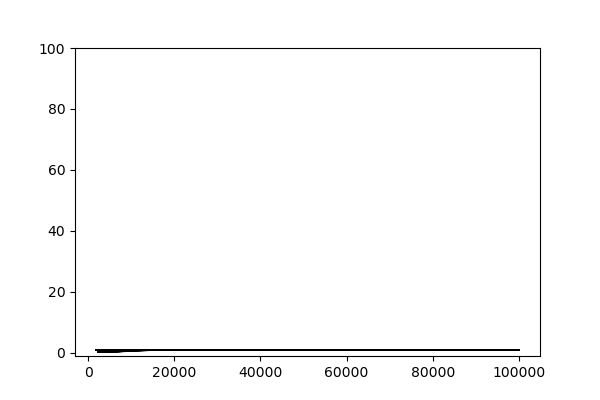

In [52]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

for i in range(0,100) : 
    for j in range(0,N_scenarios):
        ax.plot(teval,SIM_QUANT[i,j,15+4],'k',lw=0.3)

ax.set_ylim((-1,100))

- perform a single run

CPU times: total: 0 ns
Wall time: 42.7 ms


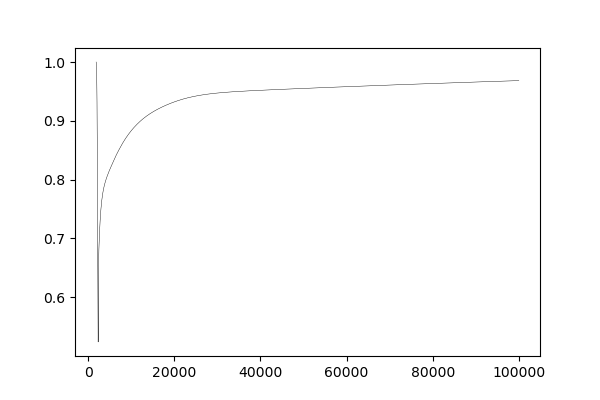

In [53]:
%%time

## ECS = 3.5 , d = 1, feedbacks = 1



j=43
    
TP_params = [TP_PROP[j],S_COUPLINGS[j],OTHER_COUPLINGS[j]]
    
i = 85

logistic_emissions = forcingCO2(2015,emissions_tot[i],mode='add',landuse= True, origin=1750) 

d= 1
epsi = 1
cfeedback = 1
TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)
sol =  SURFER_odeint(logistic_emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=False,ktemp = True, sediments=True,weathering = True)

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(teval,SIM_QUANT[j,i,15+4],'k',lw=0.3)



## Results

In [54]:
TP_indexes = np.array([0,1,2,3,5,6])

TPS = np.min(SIM_QUANT[:,:,15+TP_indexes,:].values,axis=3)
TPS[TPS<0.25] = 0
TPS[TPS>0.25] = 1

TPS_0 = np.min(SIM_QUANT_0[:,:,15+TP_indexes,:].values,axis=3)
TPS_0[TPS_0<0.25] = 0
TPS_0[TPS_0>0.25] = 1

TPS_feed = np.min(SIM_QUANT_feed[:,:,15+TP_indexes,:].values,axis=3)
TPS_feed[TPS_feed<0.25] = 0
TPS_feed[TPS_feed>0.25] = 1

TPS_int = np.min(SIM_QUANT_int[:,:,15+TP_indexes,:].values,axis=3)
TPS_int[TPS_int<0.25] = 0
TPS_int[TPS_int>0.25] = 1

In [55]:
def intervals_where_y_greater_than_M(t,y,M) :
    # Step 1: Identify all times where y > M
    mask = y > M
    # Get all times where y > M
    times_y_greater_than_M = t[mask]
    transitions = np.where(np.diff(mask) == 1)[0] 
    transition_times =t[transitions] + (M-y[transitions])/(y[transitions+1]-y[transitions])*(t[transitions+1]-t[transitions])

    if y[-1] > M :
        transition_times = np.append(transition_times,t[-1])
        
    return transition_times

def ritchie_criterion(Tp,Tm,yp,Taum,time,T): 
    ym = xm_today(Tp,Tm,yp)
    db = 3/Taum**2*(yp-ym)**4/(Tp-Tm)

    T_max = np.max(T)

    if T_max < Tp :
        return 0

    else :
        transition_times_over_Tp = intervals_where_y_greater_than_M(time,T,Tp)

        if len(transition_times_over_Tp) != 2 :
            print('error',len(transition_times_over_Tp),Tp)
        
        return db*(T_max-Tp)*(transition_times_over_Tp[1]-transition_times_over_Tp[0])**2

def find_tippingBoundary(Tm,yp,TAU,time_temp,temp):

    hit = 0
    Tp_l = 0.01
    Tp_u = 10

    sol_l = TP_unique(np.array([1]),time_temp,Tp_l,Tm,yp,TAU,time_temp,temp)
    if sol_l.y[0,-1] > 0.25 :
        return np.nan,hit
    else : 
        while Tp_u-Tp_l > 0.01 :
          
            Tp_mid = (Tp_l+Tp_u)/2
         
            sol_l = TP_unique(np.array([1]),time_temp,Tp_l,Tm,yp,TAU,time_temp,temp)
        
            if sol_l.y[0,-1] > 0.25 :
                tip_l = 1
            else :
                tip_l = -1
        
            sol_mid = TP_unique(np.array([1]),time_temp,Tp_mid,Tm,yp,TAU,time_temp,temp)
        
            if sol_mid.y[0,-1] > 0.25 :
                tip_mid = 1
            else :
                tip_mid = -1
            
            if tip_l*tip_mid > 0 :
                Tp_l = Tp_mid
            else : 
                Tp_u = Tp_mid
            
            hit = hit+1
        return (Tp_l+Tp_u)/2 , hit

def find_ritchie_tippingBoundary(Tm,yp,TAU,time_temp,temp):

    hit = 0
    Tp_l = 0.01
    Tp_u = 10

    tip_l = ritchie_criterion(Tp_l,Tm,yp,TAU,time_temp,temp)-16
    if tip_l<0 :
        return np.nan,hit
        
    while Tp_u-Tp_l > 0.01 :
      
        Tp_mid = (Tp_l+Tp_u)/2

        tip_l = ritchie_criterion(Tp_l,Tm,yp,TAU,time_temp,temp)-16 # > 0 if ritchie criterion > 16, < 0 otherwise
        tip_mid = ritchie_criterion(Tp_mid,Tm,yp,TAU,time_temp,temp)-16 # > 0 if ritchie criterion > 16, < 0 otherwise
        
        if tip_l*tip_mid > 0 :
            Tp_l = Tp_mid
        else : 
            Tp_u = Tp_mid
        
        hit = hit+1
    return (Tp_l+Tp_u)/2 , hit


### Overshoot example

In [56]:
j=39
mask_GRIS = TPS_0[:,j,0] > 0.5
indices = np.linspace(0,99,100)
mask_ind = np.argmin(np.abs(TP_TCRIT[mask_GRIS,0]-2))
i_GRIS = int(indices[mask_GRIS][mask_ind])
i_AMOC = np.argmin(np.abs(TP_TCRIT[:,5]-2))
print(TP_TCRIT[i_GRIS,0],i_GRIS)
print(TP_TCRIT[i_AMOC,5],i_AMOC)

1.9894806483929848 76
2.0160725331314944 18


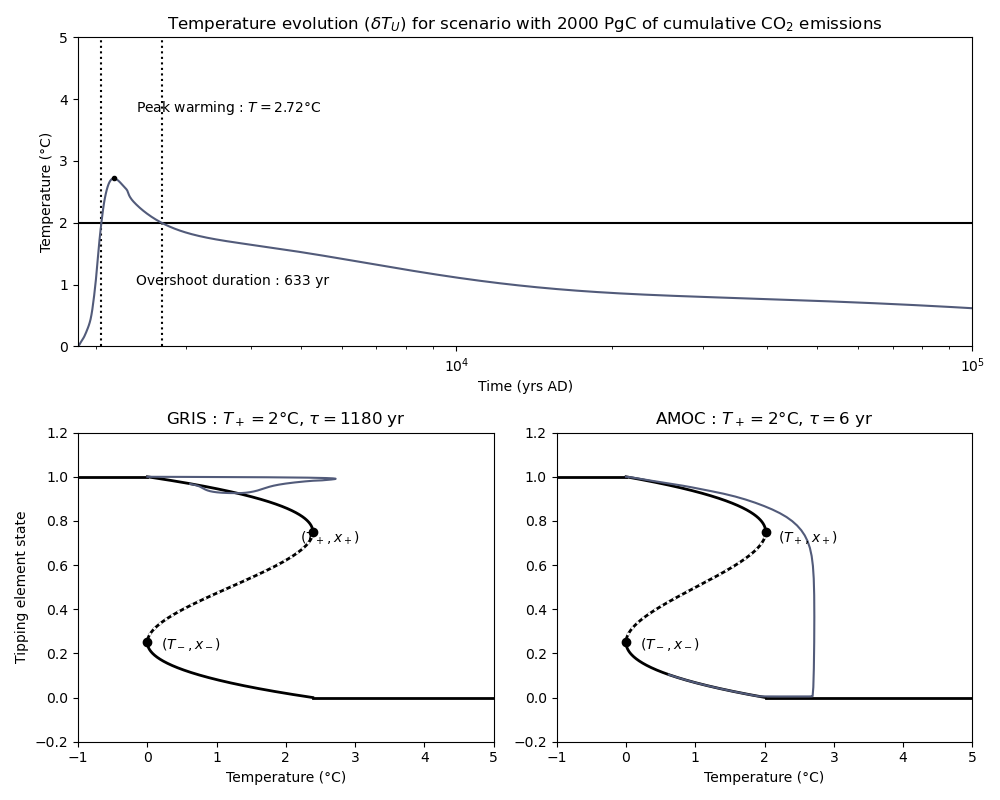

In [57]:
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1,1], height_ratios = [1,1] )

color_c = cmap(0.25)
 
ax = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1],sharey = ax1)

j = 19

ax.axhline(2,0,1,c='k')
ax.plot(teval,SIM_QUANT_0[0,j,9],c=color_c)

ind_max = np.argmax(SIM_QUANT_0[0,j,9].values)
ax.plot(teval[ind_max],SIM_QUANT_0[0,j,9,ind_max],c='k',marker ='.')
ax.annotate(r'Peak warming : $T= %.2f $°C'%(SIM_QUANT_0[0,j,9,ind_max]),(2400,3.8))


times_overshoot = intervals_where_y_greater_than_M(teval,SIM_QUANT_0[0,j,9],2)
ax.vlines(times_overshoot,0,6,color='k',ls=':',zorder=0)
ax.annotate(r'Overshoot duration : %.f yr '%(times_overshoot[1]-times_overshoot[0]),(2400,1))

#color_c = cmap(0.6)
i_GRIS =41
Tp = TP_TCRIT[i_GRIS,0]
Tm = 0
Vp = 0.75
Vm = 0.25

A2, A1, C1, C0 = params(Tp,Tm,Vp)

x = np.linspace(-0.8,1.2,10000)
y = -(-x**3+A2*x**2+A1*x+C0)/C1

mask = (x >= Vm) & (x <= Vp)
mask2 = (x>0) & (x<1) 
ax1.plot(y[mask2],x[mask2],c='k',lw='2')
ax1.plot(y[mask],x[mask],c='w',lw='2',ls=':')
ax1.plot([y[x>0][0],17],[0,0],c='k',lw='2')
ax1.plot([0,-17],[1,1],c='k',lw='2')
ax1.plot([0,Tp],[0.25,0.75],'ko')
ax1.annotate(r'$(T_+,x_+)$', (2.2,0.70))
ax1.annotate(r'$(T_-,x_-)$', (0.2,0.22))


Tp = TP_TCRIT[i_AMOC,5]
Tm = 0
Vp = 0.75
Vm = 0.25

A2, A1, C1, C0 = params(Tp,Tm,Vp)

x = np.linspace(-0.8,1.2,10000)
y = -(-x**3+A2*x**2+A1*x+C0)/C1

mask = (x >= Vm) & (x <= Vp)
mask2 = (x>0) & (x<1) 
ax2.plot(y[mask2],x[mask2],c='k',lw='2')
ax2.plot(y[mask],x[mask],c='w',lw='2',ls=':')
ax2.plot([y[x>0][0],17],[0,0],c='k',lw='2')
ax2.plot([0,-17],[1,1],c='k',lw='2')
ax2.plot([0,Tp],[0.25,0.75],'ko')
ax2.annotate(r'$(T_+,x_+)$', (2.2,0.70))
ax2.annotate(r'$(T_-,x_-)$', (0.2,0.22))


ax1.plot(SIM_QUANT_0[i_GRIS,j,9],SIM_QUANT_0[i_GRIS,j,15+0],c=color_c)
ax2.plot(SIM_QUANT_0[8,j,9],SIM_QUANT_0[i_AMOC,j,15+5],c=color_c)


ax.set_xscale('log')


ax.set_xlim((1850,100000))
ax.set_ylim((0,5))


ax1.set_xlim((-1,5))
ax1.set_ylim((-0.2,1.2))


ax2.set_xlim((-1,5))
ax2.set_ylim((-0.2,1.2))

ax.set_xlabel(r'Time (yrs AD)')
ax1.set_xlabel(r'Temperature (°C)')
ax2.set_xlabel(r'Temperature (°C)')

ax.set_ylabel(r'Temperature (°C)')
ax1.set_ylabel(r'Tipping element state')

ax.set_title(r'Temperature evolution ($\delta T_U$) for scenario with 2000 PgC of cumulative CO$_2$ emissions')
ax1.set_title(r'GRIS : $T_+ = 2$°C, $\tau = %.f $ yr'%(TP_PROP[i_GRIS,5,0]))
ax2.set_title(r'AMOC : $T_+ = 2$°C, $\tau = %.f $ yr'%(TP_PROP[i_AMOC,5,5]))

plt.tight_layout()

In [58]:
fig.savefig(os.path.join(figures_path, 'overshoot_example.pdf'))

### Riskmap

In [59]:
scenario_choices = [19,39,59,79,99]

Tm = 0
yp = 0.75

n=50
Timescales = np.logspace(0,4,n)
boundary = np.zeros((N_scenarios,n))
boundary_ritchie = np.zeros((N_scenarios,n))
actual_ritchie = np.zeros((N_scenarios,n))


for i in scenario_choices : 
    
    for j in range(0,n) :
        
        boundary[i,j], hits = find_tippingBoundary(Tm,yp,Timescales[j],teval,SIM_QUANT_0[0,i,9].values)
        # print(boundary[i,j],hits)
        actual_ritchie[i,j] = ritchie_criterion(boundary[i,j],Tm,yp,Timescales[j],teval,SIM_QUANT_0[0,i,9].values)
        boundary_ritchie[i,j], hits = find_ritchie_tippingBoundary(Tm,yp,Timescales[j],teval,SIM_QUANT_0[0,i,9].values)

    print('Computations for scenario ',emissions_tot[i],' PgC done')

Computations for scenario  1000.0  PgC done
Computations for scenario  2000.0  PgC done
Computations for scenario  3000.0  PgC done
Computations for scenario  4000.0  PgC done
error 4 7.073242187499999
error 4 7.073242187499999
Computations for scenario  5000.0  PgC done


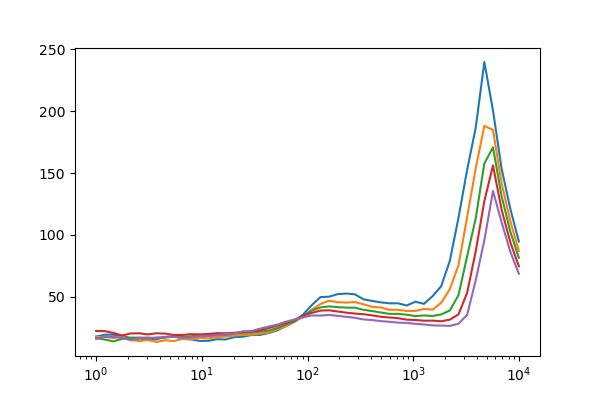

In [60]:
fig,ax = plt.subplots(1,1,figsize=(6,4)) 

for i in scenario_choices : 
    
    ax.plot(Timescales,actual_ritchie[i])
ax.set_xscale('log')

1000.0 peak temperature :  <xarray.DataArray 'model_data' ()> Size: 8B
array(2.71790006)
2000.0 peak temperature :  <xarray.DataArray 'model_data' ()> Size: 8B
array(4.06940584)
3000.0 peak temperature :  <xarray.DataArray 'model_data' ()> Size: 8B
array(5.26220243)
4000.0 peak temperature :  <xarray.DataArray 'model_data' ()> Size: 8B
array(6.26218421)
5000.0 peak temperature :  <xarray.DataArray 'model_data' ()> Size: 8B
array(7.08029061)


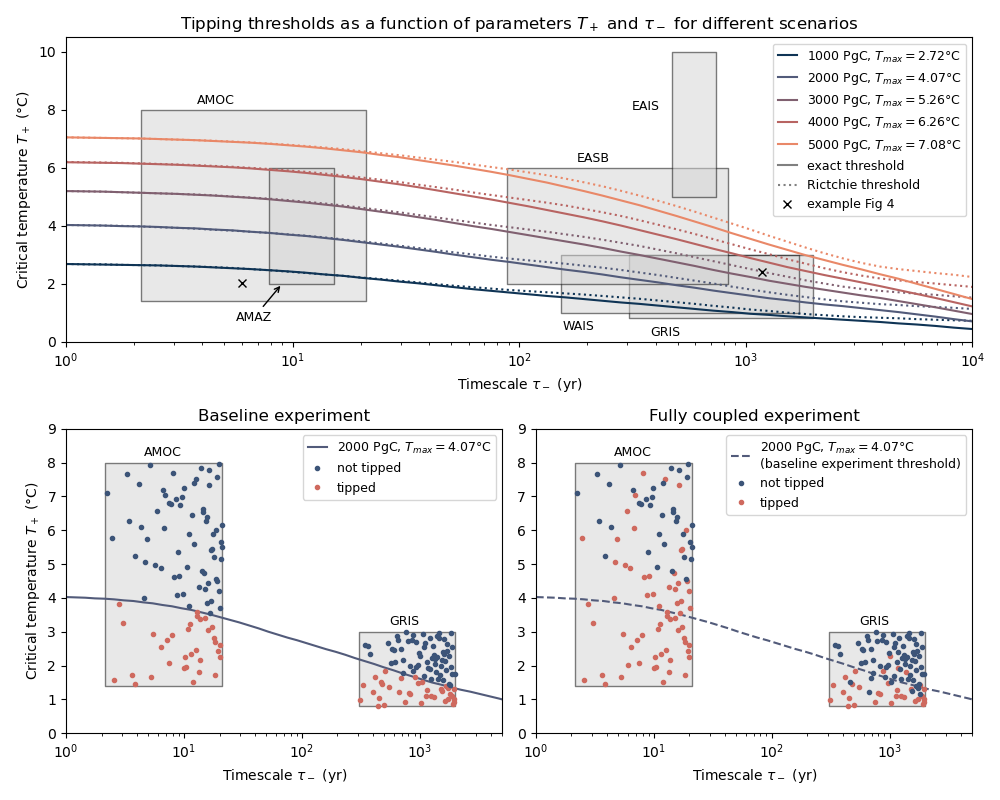

In [61]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

Tcrit_l = np.array([0.8,1,2,5,4.5,1.4,2,3])
Tcrit_u = np.array([3,3,6,10,8.7,8,6,6])

elements = ['GRIS', 'WAIS', 'EASB', 'EAIS', 'AWSI', 'AMOC', 'AMAZ', 'PERM']
TP_min = Tcrit_l
TP_max = Tcrit_u
TAU_min = tau_l
TAU_max = tau_u

TP_indexes = np.array([0,1,2,3,5,6])

rects = [Rectangle((tau_l[i],Tcrit_l[i]), tau_u[i]-tau_l[i], Tcrit_u[i]-Tcrit_l[i]) for i in [0,1,2,3,5,6]]

pc = PatchCollection(rects, facecolor='lightgray', alpha=0.5, edgecolor='k')

pc2 = PatchCollection([rects[0],rects[4]], facecolor='lightgray', alpha=0.5, edgecolor='k')
pc3 = PatchCollection([rects[0],rects[4]], facecolor='lightgray', alpha=0.5, edgecolor='k')

colors = ['cyan','skyblue','dodgerblue','royalblue','navy']
hit=0

colors = cmap(np.linspace(0.1,0.7,len(scenario_choices)))

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1,1], height_ratios = [1,1] )

ax = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1],sharey = ax1)

ax.add_collection(pc)
T_max = np.zeros(N_scenarios)

for i in scenario_choices :

    print(emissions_tot[i], 'peak temperature : ', np.max(SIM_QUANT_0[0,i,9]))
    T_max[i] = np.max(SIM_QUANT_0[0,i,9])
    ax.plot(Timescales, boundary[i], c=colors[hit], ls='-', label='{:.0f} PgC, $T_{{max}}=${:.2f}°C'.format(emissions_tot[i], T_max[i]))
    ax.plot(Timescales,boundary_ritchie[i],c=colors[hit],ls=':')
    # ax.plot(Timescales,boundary[i]-boundary_ritchie[i],c=colors[hit],ls=':')
    
    hit=hit+1



# for i in range(0,8) :
#      ax.annotate(tipping_elements[i],(TAU_min[i]*1.1,TP_max[i]-0.8),zorder=13)
i = 39
ax1.plot(Timescales,boundary[i],c=colors[1],ls='-', label='{:.0f} PgC, $T_{{max}}=${:.2f}°C'.format(emissions_tot[i], T_max[i]))
ax2.plot(Timescales,boundary[i],c=colors[1],ls='--', label='{:.0f} PgC, $T_{{max}}=${:.2f}°C\n(baseline experiment threshold)'.format(emissions_tot[i], T_max[i]))

ax1.add_collection(pc2)
ax2.add_collection(pc3)

# #####


markers= ['.','.']
tip_elements = [0,4]

for j in [39]:
    for i in range(0,N_params) :
        
         # if TPs0[i,tip_elements[j]] < 0.5 :
         #     Col = 'r'
         # else : 
         #     Col ='g'
         # ax1.plot(PARAMS_tautcrit[k,i,0,tip_elements[j]],PARAMS_tautcrit[k,i,1,tip_elements[j]],c=Col, marker = markers[j])
        hit=0
        for k in tip_elements : 
            
             m = TP_indexes[k]
            
             if TPS_0[i,j,k] < 0.5 :
                 Col = cmap(0.6)
                 Zorder = 10
             else : 
                 Col = cmap(0.2)
                 Zorder = 11
             if (k==0 and i==i_GRIS) or (k==4 and i==i_AMOC) :
                 ax.plot(TP_PROP[i,5,m],TP_TCRIT[i,m],c='k', marker ='x',markeredgecolor='k',markeredgewidth=1,zorder=100)
               
             else : 
                 ax1.plot(TP_PROP[i,5,m],TP_TCRIT[i,m],c=Col, marker = markers[hit],zorder=Zorder)
             hit=hit+1

        hit=0
        for k in tip_elements : 

             m = TP_indexes[k]
            
             if TPS[i,j,k] < 0.5 :
                 Col = cmap(0.6)
                 Zorder = 10
             else : 
                 Col =cmap(0.2)
                 Zorder = 11
             ax2.plot(TP_PROP[i,5,m],TP_TCRIT[i,m],c=Col, marker = markers[hit],zorder=Zorder)
             hit=hit+1
####

ax.annotate('AMOC', 
            (3.8, 8.2),  # Location of the text
            fontsize=9)

ax.annotate('AMAZ', 
            xy=(9, 2),  # Point to the center of the gray box
            xytext=(5.6, 0.7),  # Location of the text
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=9)

ax.annotate('EAIS', 
            (315, 8),  # Location of the text
            fontsize=9)

ax.annotate('EASB', 
            (180, 6.2),  # Location of the text
            fontsize=9)

ax.annotate('GRIS', 
            (380, 0.2),  # Location of the text
            fontsize=9)

ax.annotate('WAIS', 
            (156, 0.4),  # Location of the text
            fontsize=9)


ax1.annotate('GRIS', 
            (550, 3.2),  # Location of the text
            fontsize=9)

ax1.annotate('AMOC', 
            (4.6, 8.2),  # Location of the text
            fontsize=9)

ax2.annotate('GRIS', 
            (550, 3.2),  # Location of the text
            fontsize=9)

ax2.annotate('AMOC', 
            (4.6, 8.2),  # Location of the text
            fontsize=9)


# ax1.annotate('Did not tip', 
#             xy=(20.55, 6.2),  # Point to the center of the gray box
#             xytext=(57, 6.5),  # Location of the text
#             arrowprops=dict(edgecolor='dodgerblue', arrowstyle='->'),
#             fontsize=11,
#             color='dodgerblue')

###

ax.plot([],[],c='gray',ls='-',label = 'exact threshold')
ax.plot([],[],c='gray',ls=':',label = 'Rictchie threshold')

ax.plot([],[],ls='',c='k', marker ='x',markeredgecolor='k',markeredgewidth=1,label='example Fig 4')

ax1.plot([],[],ls='',c=cmap(0.2),marker='.',label = 'not tipped')
ax1.plot([],[],ls='',c=cmap(0.6),marker='.',label = 'tipped')

ax2.plot([],[],ls='',c=cmap(0.2),marker='.',label = 'not tipped')
ax2.plot([],[],ls='',c=cmap(0.6),marker='.',label = 'tipped')

ax.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax.set_xlim((1,10000))
ax.set_ylim((0,10.5))

ax1.set_xscale('log')
ax1.set_xlim((1,5000))
ax1.set_ylim((0,9))

ax2.set_xscale('log')
ax2.set_xlim((1,5000))
ax2.set_ylim((0,9))

ax.set_xlabel(r'Timescale $\tau_-$ (yr)')
ax1.set_xlabel(r'Timescale $\tau_-$ (yr)')
ax2.set_xlabel(r'Timescale $\tau_-$ (yr)')

ax.set_ylabel(r'Critical temperature $T_+$ (°C)')
ax1.set_ylabel(r'Critical temperature $T_+$ (°C)')

ax.set_title(r'Tipping thresholds as a function of parameters $T_+$ and $\tau_-$ for different scenarios')
ax1.set_title('Baseline experiment')
ax2.set_title('Fully coupled experiment')

ax.legend(handlelength = 1.5,fontsize=9)
ax1.legend(handlelength = 1.5,fontsize=9)
ax2.legend(handlelength = 1.5,fontsize=9)

plt.tight_layout()

In [62]:
fig.savefig(os.path.join(figures_path, 'risk_map.pdf'))

### Tipping Risk

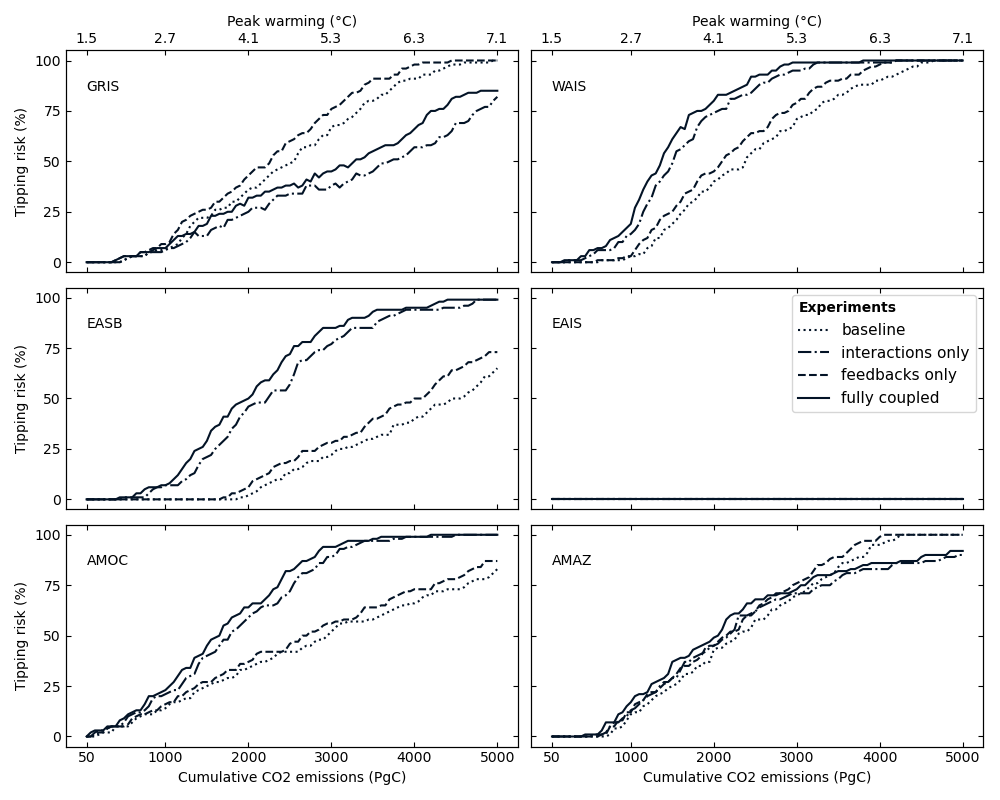

In [63]:
scenario_indexes = np.array([0,19,39,59,79,99])
T_max = np.max(SIM_QUANT_0[0,:,9].values,axis = 1)

elements = ['GRIS','WAIS','EASB','EAIS','AMOC','AMAZ']

num_tipped = N_params - np.sum(TPS,axis=0)
num_tipped_0 = N_params - np.sum(TPS_0,axis=0)
num_tipped_int = N_params - np.sum(TPS_int,axis=0)
num_tipped_feed = N_params - np.sum(TPS_feed,axis=0)

fig,axs = plt.subplots(3,2,figsize=(10,8),sharey='col',sharex=True)


axs2 = np.copy(axs)

ax =axs.flatten()
ax2 =axs2.flatten()
color = cmap(0.0)
for i in range(0,6):

    ax[i].plot(emissions_tot,num_tipped_0[:,i],c=color,ls=':',label='baseline')
    ax[i].plot(emissions_tot,num_tipped_int[:,i],c=color,ls='-.',label='interactions only')
    ax[i].plot(emissions_tot,num_tipped_feed[:,i],c=color,ls='--',label='feedbacks only')
    ax[i].plot(emissions_tot,num_tipped[:,i],c=color,ls='-',label='fully coupled')
   
    ax[i].annotate(elements[i],(50,85))
    ax[i].tick_params(direction='in',right=True)
    ax[i].set_yticks([0,25,50,75,100])
    
    ax[i].set_xticks(emissions_tot[scenario_indexes])
  
    
    ax2[i] = ax[i].twiny()
    ax2[i].set_xticks(emissions_tot[scenario_indexes])
    ax2[i].set_xticklabels([])
    ax2[i].set_xlim(ax[i].get_xlim())
    
   
    ax2[i].tick_params(direction='in')

ax[0].set_ylabel('Tipping risk (%)')
ax[2].set_ylabel('Tipping risk (%)')
ax[4].set_ylabel('Tipping risk (%)')

ax[1].set_yticklabels([])
ax[3].set_yticklabels([])
ax[5].set_yticklabels([])


ax[4].set_xlabel('Cumulative CO2 emissions (PgC)')
ax[5].set_xlabel('Cumulative CO2 emissions (PgC)')
    
ax2[0].set_xlabel('Peak warming (°C)')
ax2[1].set_xlabel('Peak warming (°C)')


ax2[0].set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )
ax2[1].set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )

ax[3].legend(loc='best',fontsize=11,title ='Experiments',title_fontproperties = {'weight':'bold'}, alignment='left')
plt.tight_layout()
plt.subplots_adjust(wspace=0.03)

In [64]:
print(emissions_tot)

[  50.  100.  150.  200.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  800.  850.  900.  950. 1000. 1050. 1100. 1150. 1200.
 1250. 1300. 1350. 1400. 1450. 1500. 1550. 1600. 1650. 1700. 1750. 1800.
 1850. 1900. 1950. 2000. 2050. 2100. 2150. 2200. 2250. 2300. 2350. 2400.
 2450. 2500. 2550. 2600. 2650. 2700. 2750. 2800. 2850. 2900. 2950. 3000.
 3050. 3100. 3150. 3200. 3250. 3300. 3350. 3400. 3450. 3500. 3550. 3600.
 3650. 3700. 3750. 3800. 3850. 3900. 3950. 4000. 4050. 4100. 4150. 4200.
 4250. 4300. 4350. 4400. 4450. 4500. 4550. 4600. 4650. 4700. 4750. 4800.
 4850. 4900. 4950. 5000.]


In [65]:
fig.savefig(os.path.join(figures_path, 'tipping_risk.pdf'))

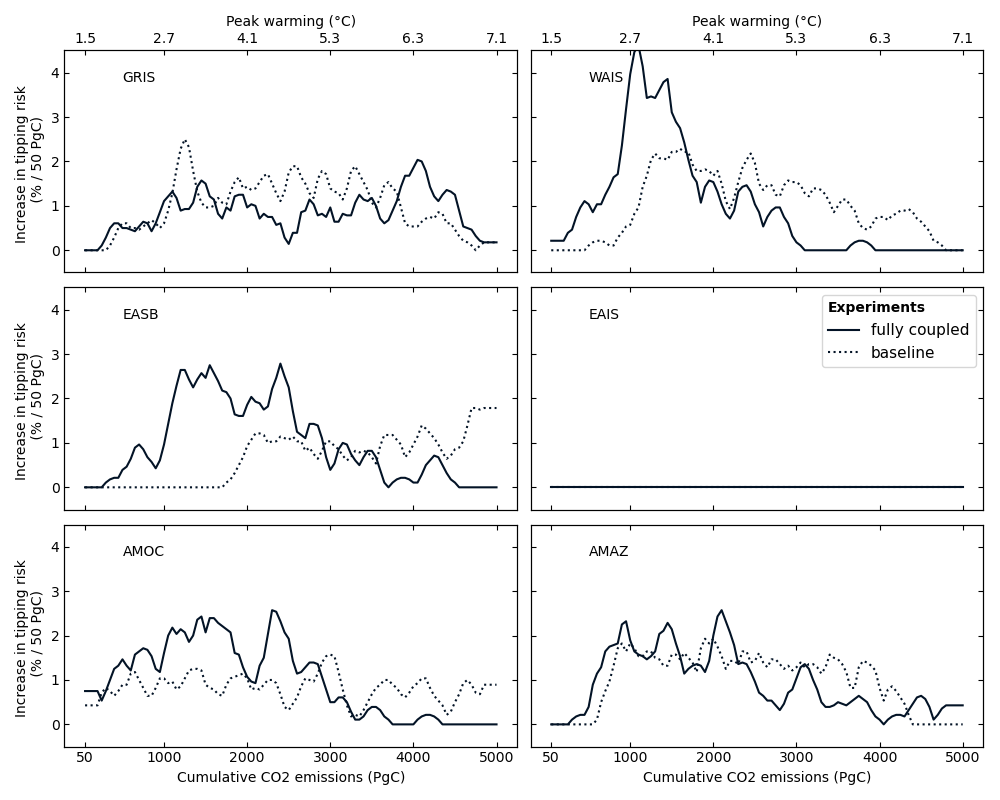

In [66]:
from scipy.signal import savgol_filter

window_size = 7  # Must be odd
poly_order = 1  # Polynomial order


fig,axs = plt.subplots(3,2,figsize=(10,8),sharey=True,sharex=True)

axs2 = np.copy(axs)
ax =axs.flatten()
ax2 =axs2.flatten()

for i in range(0,6):
    #dy_dt_smooth_2 = np.diff(num_tipped[:,i],n=1)
    dy_dt_smooth = savgol_filter(num_tipped[:,i], window_size, poly_order, deriv=1, delta=1)
    dy_dt_smooth_0 = savgol_filter(num_tipped_0[:,i], window_size, poly_order, deriv=1, delta=1)
    ax[i].plot(emissions_tot,dy_dt_smooth,c=color,ls='-',label='fully coupled')
   # ax[i].plot(emissions_tot[1:],dy_dt_smooth_2,c='r',ls='-',label='interactions and feedbacks')
    ax[i].plot(emissions_tot,dy_dt_smooth_0,c=color,ls=':',label='baseline')
    ax[i].set_ylim((-0.5,4.5))
    ax[i].annotate(elements[i],(500,3.8))
    ax[i].tick_params(direction='in',right=True)
    ax[i].set_yticks([0,1,2,3,4])
    
    ax[i].set_xticks(emissions_tot[scenario_indexes])
  
    
    ax2[i] = ax[i].twiny()
    ax2[i].set_xticks(emissions_tot[scenario_indexes])
    ax2[i].set_xticklabels([])
    ax2[i].set_xlim(ax[i].get_xlim())
   
    ax2[i].tick_params(direction='in')

ax[0].set_ylabel('Increase in tipping risk \n (% / 50 PgC)')
ax[2].set_ylabel('Increase in tipping risk \n (% / 50 PgC)')
ax[4].set_ylabel('Increase in tipping risk \n (% / 50 PgC)')

# ax[1].set_yticklabels([])
# ax[3].set_yticklabels([])
# ax[5].set_yticklabels([])


ax[4].set_xlabel('Cumulative CO2 emissions (PgC)')
ax[5].set_xlabel('Cumulative CO2 emissions (PgC)')
    
ax2[0].set_xlabel('Peak warming (°C)')
ax2[1].set_xlabel('Peak warming (°C)')

ax2[0].set_xticks(emissions_tot[scenario_indexes])
ax2[1].set_xticks(emissions_tot[scenario_indexes])
ax2[0].set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )
ax2[1].set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )

ax[3].legend(loc='best',fontsize=11,title ='Experiments',title_fontproperties = {'weight':'bold'}, alignment='left')
plt.tight_layout()
plt.subplots_adjust(wspace=0.03)


In [67]:
fig.savefig(os.path.join(figures_path, 'tipping_risk_derivative.pdf'))

In [68]:
TPS_ecs5 = np.min(SIM_QUANT_ecs5[:,:,15+TP_indexes,:].values,axis=3)
TPS_ecs5[TPS_ecs5<0.25] = 0
TPS_ecs5[TPS_ecs5>0.25] = 1

TPS_ecs5_0 = np.min(SIM_QUANT_ecs5_0[:,:,15+TP_indexes,:].values,axis=3)
TPS_ecs5_0[TPS_ecs5_0<0.25] = 0
TPS_ecs5_0[TPS_ecs5_0>0.25] = 1

TPS_noASInoPERM = np.min(SIM_QUANT_noASInoPERM[:,:,15+TP_indexes,:].values,axis=3)
TPS_noASInoPERM[TPS_noASInoPERM<0.25] = 0
TPS_noASInoPERM[TPS_noASInoPERM>0.25] = 1

TPS_2int = np.min(SIM_QUANT_2int[:,:,15+TP_indexes,:].values,axis=3)
TPS_2int[TPS_2int<0.25] = 0
TPS_2int[TPS_2int>0.25] = 1

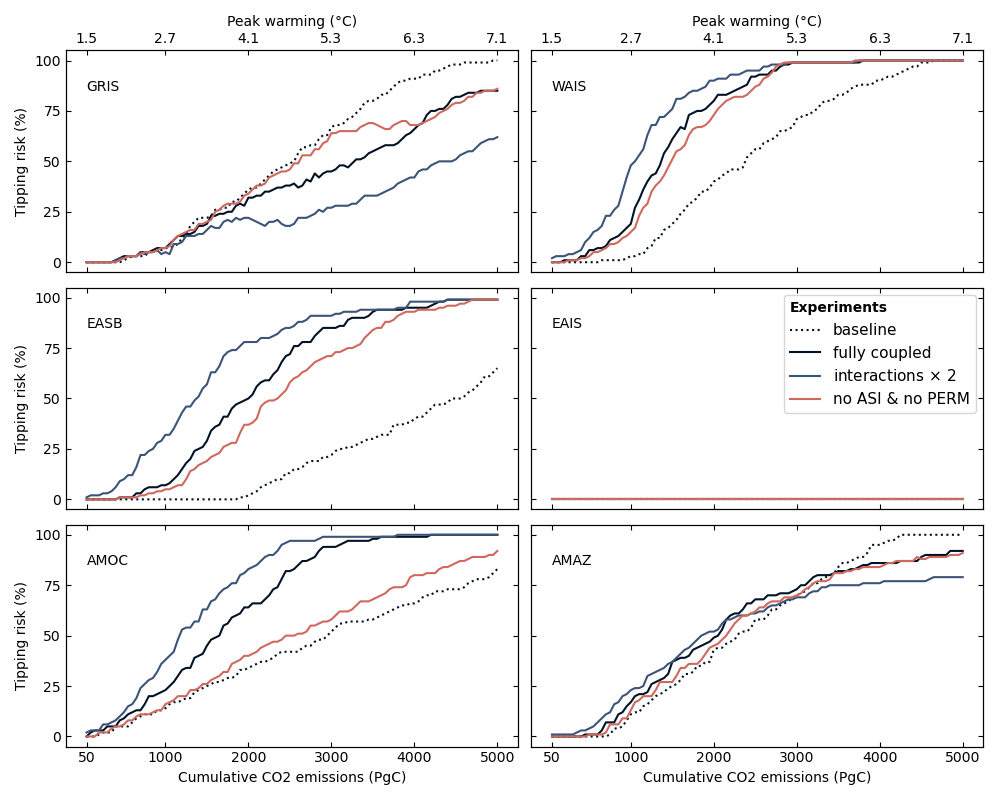

In [69]:
scenario_indexes = np.array([0,19,39,59,79,99])
T_max_ecs5 = np.max(SIM_QUANT_ecs5_0[0,:,9].values,axis = 1)

elements = ['GRIS','WAIS','EASB','EAIS','AMOC','AMAZ']

num_tipped_ecs5 = N_params - np.sum(TPS_ecs5,axis=0)
num_tipped_ecs5_0 = N_params - np.sum(TPS_ecs5_0,axis=0)
num_tipped_2int = N_params - np.sum(TPS_2int,axis=0)
num_tipped_noASInoPERM = N_params - np.sum(TPS_noASInoPERM,axis=0)


fig,axs = plt.subplots(3,2,figsize=(10,8),sharey='col',sharex=True)


axs2 = np.copy(axs)

ax =axs.flatten()
ax2 =axs2.flatten()

for i in range(0,6):
    ax[i].plot(emissions_tot,num_tipped_0[:,i],c=color,ls=':',label='baseline')
    ax[i].plot(emissions_tot,num_tipped[:,i],c=cmap(0.0),label='fully coupled')
    ax[i].plot(emissions_tot,num_tipped_2int[:,i],c=cmap(0.2),label=r'interactions $\times$ 2')
    ax[i].plot(emissions_tot,num_tipped_noASInoPERM[:,i],c=cmap(0.6),label='no ASI & no PERM')
   
    ax[i].annotate(elements[i],(50,85))
    ax[i].tick_params(direction='in',right=True)
    ax[i].set_yticks([0,25,50,75,100])
    
    
    ax[i].set_xticks(emissions_tot[scenario_indexes])
  
    
    ax2[i] = ax[i].twiny()
    ax2[i].set_xticks(emissions_tot[scenario_indexes])
    ax2[i].set_xticklabels([])
    ax2[i].set_xlim(ax[i].get_xlim())
   
    ax2[i].tick_params(direction='in')

ax[0].set_ylabel('Tipping risk (%)')
ax[2].set_ylabel('Tipping risk (%)')
ax[4].set_ylabel('Tipping risk (%)')

ax[1].set_yticklabels([])
ax[3].set_yticklabels([])
ax[5].set_yticklabels([])


ax[4].set_xlabel('Cumulative CO2 emissions (PgC)')
ax[5].set_xlabel('Cumulative CO2 emissions (PgC)')
    
ax2[0].set_xlabel('Peak warming (°C)')
ax2[1].set_xlabel('Peak warming (°C)')

ax2[0].set_xticks(emissions_tot[scenario_indexes])
ax2[1].set_xticks(emissions_tot[scenario_indexes])
ax2[0].set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )
ax2[1].set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )

ax[3].legend(loc='best',fontsize=11,title ='Experiments',title_fontproperties = {'weight':'bold'}, alignment='left')
plt.tight_layout()
plt.subplots_adjust(wspace=0.03)

In [70]:
fig.savefig(os.path.join(figures_path, 'tipping_risk_d2_noASInoPERM.pdf'))

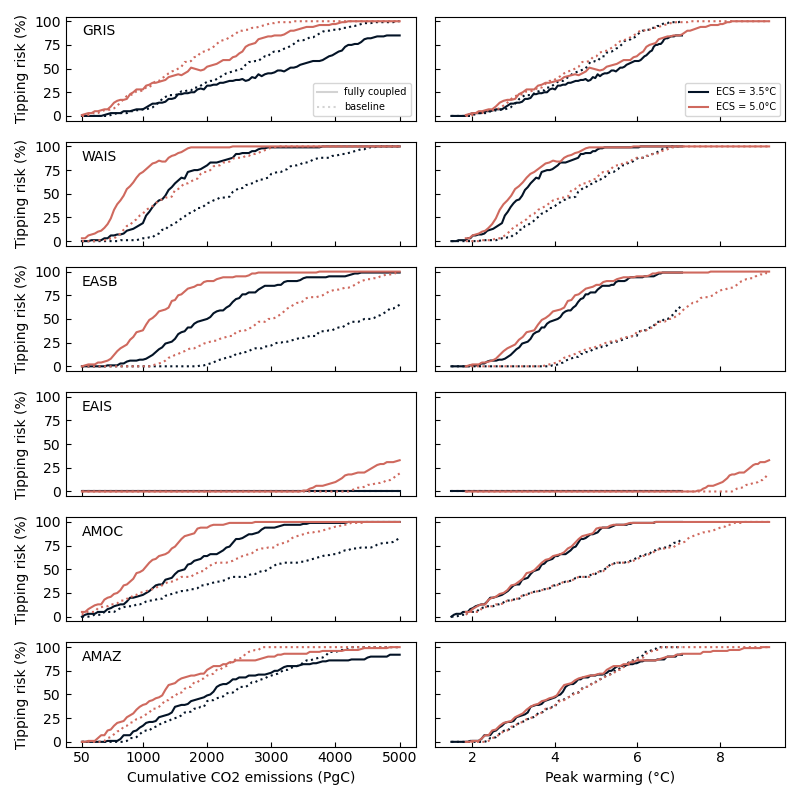

In [71]:
scenario_indexes = np.array([0,19,39,59,79,99])
T_max_ecs5 = np.max(SIM_QUANT_ecs5_0[0,:,9].values,axis = 1)

elements = ['GRIS','WAIS','EASB','EAIS','AMOC','AMAZ']

num_tipped_ecs5 = N_params - np.sum(TPS_ecs5,axis=0)
num_tipped_ecs5_0 = N_params - np.sum(TPS_ecs5_0,axis=0)
num_tipped_2int = N_params - np.sum(TPS_2int,axis=0)
num_tipped_noASInoPERM = N_params - np.sum(TPS_noASInoPERM,axis=0)

fig,axs = plt.subplots(6,2,figsize=(8,8),sharey=True,sharex='col')


for i in range(0,6):

    axs[i,0].plot(emissions_tot,num_tipped[:,i],c=cmap(0.0),ls='-')
    axs[i,0].plot(emissions_tot,num_tipped_0[:,i],c=cmap(0.0),ls=':')
    axs[i,0].plot(emissions_tot,num_tipped_ecs5[:,i],c=cmap(0.6),ls='-')
    axs[i,0].plot(emissions_tot,num_tipped_ecs5_0[:,i],c=cmap(0.6),ls=':')
   
    axs[i,0].annotate(elements[i],(50,85))
    axs[i,0].tick_params(direction='in')
    axs[i,0].set_yticks([0,25,50,75,100])
    axs[i,0].set_ylabel('Tipping risk (%)')
    axs[i,0].set_xticks(emissions_tot[scenario_indexes])
    
    axs[i,1].plot(T_max,num_tipped[:,i],c=cmap(0.0),ls='-')
    axs[i,1].plot(T_max,num_tipped_0[:,i],c=cmap(0.0),ls=':')
    axs[i,1].plot(T_max_ecs5,num_tipped_ecs5[:,i],c=cmap(0.6),ls='-')
    axs[i,1].plot(T_max_ecs5,num_tipped_ecs5_0[:,i],c=cmap(0.6),ls=':')
   
    axs[i,1].annotate(elements[i],(500,85))
    axs[i,1].tick_params(direction='in')
    axs[i,1].set_yticks([0,25,50,75,100])
    # axs[i,1].set_xticks(T_max[scenario_indexes])
    
axs[5,0].set_xlabel('Cumulative CO2 emissions (PgC)')
axs[5,1].set_xlabel('Peak warming (°C)')

axs[0,0].plot([],[],c='lightgray',ls='-',label='fully coupled')
axs[0,0].plot([],[],c='lightgray',ls=':',label='baseline')
axs[0,1].plot([],[],c=cmap(0.0),ls='-',label='ECS = 3.5°C')
axs[0,1].plot([],[],c=cmap(0.6),ls='-',label='ECS = 5.0°C')
axs[0,0].legend(fontsize=7,loc='lower right')
axs[0,1].legend(fontsize=7,loc='lower right')
    
plt.tight_layout()
# plt.subplots_adjust(wspace=0.2)

In [72]:
fig.savefig(os.path.join(figures_path, 'tipping_risk_ecs5.pdf'))

40 2050.0 [4.06940584 4.13292699 4.1956316 ]
26 1350.0 [4.04619393 4.13585613 4.22481914]


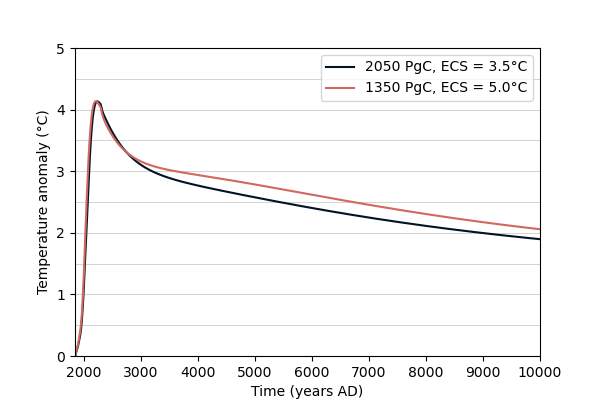

In [73]:
index_tmax_4 = np.argmin(np.abs(T_max-4.13))
print(index_tmax_4,emissions_tot[index_tmax_4],T_max[index_tmax_4-1:index_tmax_4+2])

index_tmax_ecs5_4 = np.argmin(np.abs(T_max_ecs5-4.13))
print(index_tmax_ecs5_4,emissions_tot[index_tmax_ecs5_4],T_max_ecs5[index_tmax_ecs5_4-1:index_tmax_ecs5_4+2])


fig,ax = plt.subplots(1,1,figsize=(6,4))
for i in np.linspace(0,5,11) :
    ax.axhline(i,0,1,c='lightgray',lw=0.7)
ax.plot(teval,SIM_QUANT_0[0,index_tmax_4,9],c=cmap(0.0),ls='-',label='2050 PgC, ECS = 3.5°C')
ax.plot(teval,SIM_QUANT_ecs5_0[0,index_tmax_ecs5_4,9],c=cmap(0.6),ls='-',label='1350 PgC, ECS = 5.0°C')

ax.set_xlim((1850,10000))
ax.set_ylim((0,5))

ax.set_ylabel('Temperature anomaly (°C)')
ax.set_xlabel('Time (years AD)')
ax.legend()

In [74]:
fig.savefig(os.path.join(figures_path, 'tipping_risk_ecs5_temp.pdf'))

### Effective transition timescales

In [75]:
js = [19,59,99]

TP_indexes = np.array([0,1,2,3,5,6])
NLC_indexes = np.array([4,7])

trans_time_vector_0 = np.full([8,len(js),N_params], np.nan)
trans_time_vector = np.full([8,len(js),N_params], np.nan)

for j in range(0,3):  
    index =js[j]
    print(emissions_tot[index])
    
    for i in range(0,N_params) :

        for k in range(0,6):
            
            t = teval
            y = SIM_QUANT_0[i,index,15+TP_indexes[k]]
            times = intervals_where_y_less_than_M(t,y,0.25)
            
            if len(times)>=2 :
                # ax.plot(t,y)
                trans_time,ze = time_from_a_to_b(t,y,0.75,0.25)
                trans_time_vector_0[TP_indexes[k],j,i] = trans_time

            y = SIM_QUANT[i,index,15+TP_indexes[k]]
            times = intervals_where_y_less_than_M(t,y,0.25)
            
            if len(times)>=2 :
                # ax.plot(t,y)
                trans_time,ze = time_from_a_to_b(t,y,0.75,0.25)
                trans_time_vector[TP_indexes[k],j,i] = trans_time

        for k in range(0,2):
            
            t = teval
            y = SIM_QUANT_0[i,index,15+NLC_indexes[k]]
            times = intervals_where_y_less_than_M(t,y,0.25)
            
            if len(times)>=2 :
                # ax.plot(t,y)
                trans_time,ze = time_from_a_to_b(t,y,0.75,0.25)
                trans_time_vector_0[NLC_indexes[k],j,i] = trans_time

            y = SIM_QUANT[i,index,15+NLC_indexes[k]]
            times = intervals_where_y_less_than_M(t,y,0.25)
            
            if len(times)>=2 :
                # ax.plot(t,y)
                trans_time,ze = time_from_a_to_b(t,y,0.75,0.25)
                trans_time_vector[NLC_indexes[k],j,i] = trans_time

1000.0
3000.0
5000.0


c:\Users\AL000111\AppData\Local\anaconda3\envs\python\Lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\AL000111\AppData\Local\anaconda3\envs\python\Lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


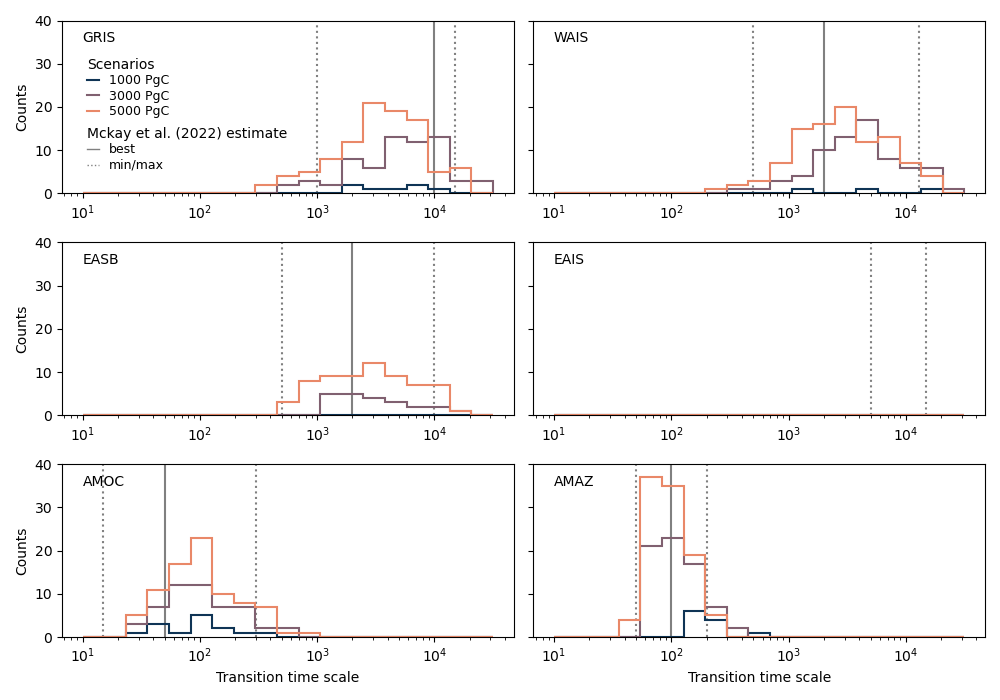

In [76]:
transition_timescale_best = np.array([10000,2000,2000,np.nan,20,50,100,50])

colors = cmap(np.linspace(0.1,0.7,3))

fig,axs = plt.subplots(3,2,figsize=(10,7),sharey=True)

BIN = np.logspace(1,4.5,20)

ax = axs.flatten()

for k in range(0,6):

    ax[k].vlines(transition_timescale_l[TP_indexes[k]],0,40,color='gray',ls=':')
    ax[k].vlines(transition_timescale_u[TP_indexes[k]],0,40,color='gray',ls=':')
    ax[k].vlines(transition_timescale_best[TP_indexes[k]],0,40,color='gray',ls='-')
    
    for j in range(0,3):
        # ax[k].hist(trans_time_vector[TP_indexes[k],j],bins=BIN,histtype=u'step',color=colors[j],lw=2,alpha=0.5)
        ax[k].hist(trans_time_vector_0[TP_indexes[k],j],histtype=u'step',bins=BIN,ls='-',color=colors[j],lw=1.5)
        
    ax[k].set_ylim((0,40))
    ax[k].annotate(elements[k],(10,35))
    ax[k].set_yticks([0,10,20,30,40])
    ax[k].set_xscale('log')


axs[0,0].set_ylabel('Counts')
axs[1,0].set_ylabel('Counts')
axs[2,0].set_ylabel('Counts')
axs[2,0].set_xlabel('Transition time scale')
axs[2,1].set_xlabel('Transition time scale')

# for k in range(0,2):
#     for j in range(0,3):
#         # ax[k].hist(trans_time_vector[k,j],bins=BIN,histtype=u'step',color=colors[j],lw=2)
#         ax[6+k].hist(trans_time_vector_0[NLC_indexes[k],j],histtype=u'step',bins=BIN,ls='-',color=colors[j],lw=1.5)
      
#     ax[6+k].vlines(transition_timescale_l[NLC_indexes[k]],0,30,color='k',ls=':')
#     ax[6+k].vlines(transition_timescale_u[NLC_indexes[k]],0,30,color='k',ls=':')
#     ax[6+k].vlines(transition_timescale_best[NLC_indexes[k]],0,30,color='k',ls='-')
        
#     ax[6+k].set_xscale('log')

l1, = axs[0,0].plot([],[],color =colors[0],label ='1000 PgC')
l2, = axs[0,0].plot([],[],color =colors[1],label ='3000 PgC')
l3, = axs[0,0].plot([],[],color =colors[2],label ='5000 PgC')

m1, = axs[0,0].plot([],[],'gray',ls='-',lw=1,label ='best')
m2, = axs[0,0].plot([],[],'gray',ls=':',lw=1,label ='min/max')

first_legend = axs[0,0].legend(handles= [l1,l2,l3],loc = 'upper left',bbox_to_anchor=(0.03,0.55,.9,0.3),fontsize=9,labelspacing=0.2,ncol = 1, handlelength = 1, title = 'Scenarios',alignment ='left',edgecolor='none', facecolor='none',columnspacing=1.7)
second_legend = axs[0,0].legend(handles=[m1,m2],loc = 'upper left',bbox_to_anchor=(0.03,0.15,.9,0.3),fontsize=9,labelspacing=0.2,ncol = 1, handlelength = 1, title = 'Mckay et al. (2022) estimate',alignment ='left',edgecolor='none', facecolor ='none',columnspacing=1.7)

axs[0,0].add_artist(first_legend)
# axs[0,0].add_artist(second_legend)

plt.tight_layout()

In [77]:
fig.savefig(os.path.join(figures_path, 'timescales.pdf'))

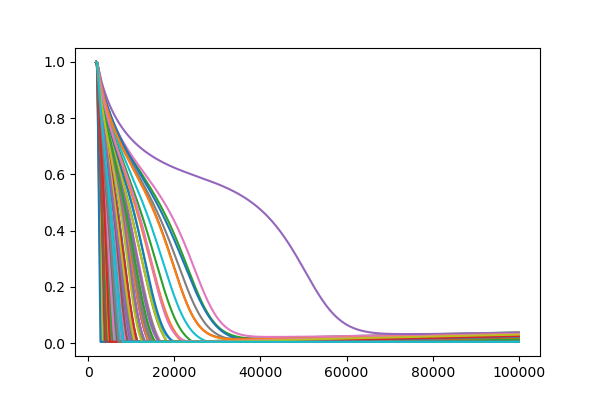

In [78]:
fig,ax=plt.subplots(1,1,figsize=(6,4))

for i in range(0,N_params) :
    ax.plot(teval,SIM_QUANT_0[i,99,15+0])

### Cascades

## As a difference between two consecutive scenarios (with interactions)

In [79]:

def forcings_for_SURFER_uniqueTP(y,T,m,teval,TP_params,TP_setup):
    
    tp_prop,s_couplings,other_couplings = TP_params
    d,epsi,cfeedback =  TP_setup 
    COUPLING = s_couplings@(1-y)
    derivatives = np.zeros((8,len(teval)))
    forcings = np.zeros((5,len(teval)))
    forcings[0] = teval

    # Computation of derivatives (the one for AMOC is not complete but we don't care because AMOC derivative is not used in interactions/feedbacks)
    for k in range(0,8) : 
        
        H = -y[k]**3+ tp_prop[0,k]*y[k]**2+tp_prop[1,k]*y[k]+tp_prop[2,k]*T+tp_prop[3,k]-d*COUPLING[k]
        taup = tp_prop[4,k]
        taum = tp_prop[5,k]
        tau = taum + 0.5*(taup-taum)*(1+np.tanh(H/0.001))
    
        ky1 = 0.005
        ky2 = 0.01
        
        mask_a = y[k]>1-ky2
        mask_b =  y[k]<ky2
        mask_H_a = H>0
        mask_H_b = H<0
        
        mask =  (mask_H_a & mask_a) | (mask_H_b & mask_b)

        derivatives[k] = H/tau
        
        if len(y[k,mask])>0 : 
            derivatives[k][mask] = derivatives[k][mask]*vsmooth_trans_2(y[k,mask],ky1,ky2)
    
    # we use the derivatives to compute emissions from TPs
    TPs_co2_emissions_0 = -1*derivatives*tp_prop[7][:,np.newaxis]
    TPs_ch4_emissions_0 = -1*derivatives*tp_prop[8][:,np.newaxis]
    TPs_rad_forcings =  tp_prop[6][:,np.newaxis]*(1-y)**0.8

    TPs_ch4_emissions_neg = 1*TPs_ch4_emissions_0
    TPs_ch4_emissions_neg[TPs_ch4_emissions_neg>0] = 0
    
    TPs_co2_emissions = TPs_co2_emissions_0 + TPs_ch4_emissions_neg
    TPs_ch4_emissions = TPs_ch4_emissions_0 - TPs_ch4_emissions_neg
    
    sum_TPs_co2_em = np.sum(TPs_co2_emissions,axis=0)  
    sum_TPs_ch4_em = np.sum(TPs_ch4_emissions,axis=0)
    sum_TPs_rad_forcings = np.sum(TPs_rad_forcings,axis=0)
    
    # we ue the derivatives to compute the full interactions for AMOC
    COUPLING[5] = COUPLING[5] - (other_couplings[0]*derivatives[0] + other_couplings[1]*derivatives[1] + other_couplings[2]*derivatives[2])

    # we compute the forcings to be used in SURFER_uniqueTP
    forcings[1] = sum_TPs_co2_em - TPs_co2_emissions[m] #co2
    forcings[2] = sum_TPs_ch4_em - TPs_ch4_emissions[m] #ch4
    forcings[3] = COUPLING[m]
    forcings[4] = sum_TPs_rad_forcings - TPs_rad_forcings[m]

    return forcings

def TP_derivatives(y,T,teval,TP_params,TP_setup):
    
    tp_prop,s_couplings,other_couplings = TP_params
    d,epsi,cfeedback =  TP_setup 
    COUPLING = s_couplings@(1-y)
    derivatives = np.zeros((8,len(teval)))
    forcings = np.zeros((5,len(teval)))
    forcings[0] = teval

    # Computation of derivatives (the one for AMOC is not complete but we don't care because AMOC derivative is not used in interactions/feedbacks)
    for k in range(0,8) : 
        
        H = -y[k]**3+ tp_prop[0,k]*y[k]**2+tp_prop[1,k]*y[k]+tp_prop[2,k]*T+tp_prop[3,k]-d*COUPLING[k]
        taup = tp_prop[4,k]
        taum = tp_prop[5,k]
        tau = taum + 0.5*(taup-taum)*(1+np.tanh(H/0.001))
    
        ky1 = 0.005
        ky2 = 0.01
        
        mask_a = y[k]>1-ky2
        mask_b =  y[k]<ky2
        mask_H_a = H>0
        mask_H_b = H<0
        
        mask =  (mask_H_a & mask_a) | (mask_H_b & mask_b)

        derivatives[k] = H/tau
        
        if len(y[k,mask])>0 : 
            derivatives[k][mask] = derivatives[k][mask]#*vsmooth_trans_2(y[k,mask],ky1,ky2)
    
    # computation of AMOC derivative
    k=5
    H_AMOC = -y[k]**3+ tp_prop[0,k]*y[k]**2+tp_prop[1,k]*y[k]+tp_prop[2,k]*T+tp_prop[3,k]-d*COUPLING[k] 
    H_AMOC = H_AMOC + d*(other_couplings[0]*derivatives[0]+other_couplings[1]*derivatives[1]+other_couplings[2]*derivatives[2])
    taup = tp_prop[4,k]
    taum = tp_prop[5,k]
    tau = taum + 0.5*(taup-taum)*(1+np.tanh(H_AMOC/0.001))
    
    d_AMOC = H_AMOC/tau

    mask_a = y[k]>1-ky2
    mask_b =  y[k]<ky2
    mask_H_a = H_AMOC>0
    mask_H_b = H_AMOC<0
        
    mask =  (mask_H_a & mask_a) | (mask_H_b & mask_b)

    if len(y[k,mask])>0 : 
            d_AMOC[mask] = d_AMOC[mask]*vsmooth_trans_2(y[k,mask],ky1,ky2)

    derivatives[k] = d_AMOC

    return derivatives


In [80]:
def SURFER_uniqueTP(m_TP,emissions,forcings,y0,teval,model_params,TP_params,TP_setup,interp_sol,**kwargs):
    
    if kwargs['ktemp'] == True :
        ktemp = 1
    else : ktemp = 0
        
    if kwargs['sediments'] == True : 
        sed = 1
    else : sed = 0
        
    if kwargs['weathering'] == True : 
        weathering = 1
    else : weathering = 0
    
    ATOL = np.ones(len(y0))*10**-12
    RTOL = np.ones(len(y0))*10**-4
    ATOL[8:]= 0.5*10**-4
    RTOL[8:]= 10**-12
    
    # RTOL[21]= 10**-5
    # RTOL[20]= 10**-6
    # RTOL[19]= 10**-6
    # ATOL[21]= 10**-5
    # ATOL[20]= 10**-5
    # ATOL[19]= 10**-5

    model_setup = np.array([ktemp,sed,weathering], dtype = np.int32)
    TP_properties,S_couplings,other_couplings = TP_params
    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl,fmod_gl = model_params
      
    V = F_CaSiO3_pi
    K_IU = (P_CaCO3_pi + P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_UI*MU_pi)/MI_pi
    K_DI = ((1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_ID*MI_pi)/MD_pi
    K_alk_IU = (2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_UI*QU_pi)/QI_pi
    K_alk_DI = (2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_ID*QI_pi)/QD_pi
    alpha_bur = (F_CaCO3_pi + F_CaSiO3_pi)/MS_pi

    computed_params = np.array([V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur], dtype=np.float64)

    if interp_sol == True : 
          sol,infodict =odeint(f_uniqueTP, y0, teval, tfirst= True, atol = ATOL,rtol = RTOL,full_output=True,args = (m_TP,emissions,forcings,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup,),h0 = 1.0)
   
    else : 
       sol,infodict=odeint(f_uniqueTP, y0, teval, tfirst= True, atol = ATOL,rtol = RTOL, full_output=True,args = (m_TP,emissions,forcings,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup,),h0 = 1.0)
   
    return sol,infodict

@jit(nopython=True)
def f_uniqueTP(t,y,m_TP,emissions,forcings,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup) :

    ## Unpacking parameters
    
    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl,fmod_gl = model_params
    V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur = computed_params
    A2,A1,C1,C0,TAUP,TAUM,FMOD,CPOT,CH4POT = TP_properties
    c_50,c_51, c_52 = other_couplings
    d,epsi,cfeedback = TP_setup
    ktemp, sed, weathering = model_setup

    ## Emissions
    
    co2_em_fossil = np.interp(t,emissions[0],emissions[1]) 
    co2_em_landuse = np.interp(t,emissions[0],emissions[2])
    ch4_em_fossil = np.interp(t,emissions[0],emissions[3])
    ch4_em_landuse = np.interp(t,emissions[0],emissions[4])
    so2_em_strat = np.interp(t,emissions[0],emissions[5])
    
    ## Fluxes

    K0U= k0(T_U+ktemp*y[9],S_U)
    bu = BU(y[2],y[5],T_U+ktemp*y[9],S_U)
    CO32D = CO32_D(y[4],y[7],T_D+ktemp*y[11],S_D)
    
    F_CaCO3 = F_CaCO3_pi*(1+weathering*K_Ca*y[9])
    F_CaSiO3 = F_CaSiO3_pi*np.exp(weathering*K_T*y[9])
    F_weathering = F_CaCO3 + 2*F_CaSiO3
    F_river = 2*(F_CaCO3+F_CaSiO3)
    
    F_UI = P_CaCO3_pi + P_org_pi + K_UI*y[2]-K_IU*y[3]
    F_ID = (1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi + K_ID*y[3]-K_DI*y[4]
    
    F_accumulation = F_CaCO3_pi+F_CaSiO3_pi - sed*(alpha_diss*(CO32D-CO32D_pi)+beta_diss*(y[8]-MS_pi)+gamma_diss*(CO32D-CO32D_pi)*(y[8]-MS_pi))
    F_burial = sed*(alpha_bur*y[8])+(1-sed)*(F_CaCO3_pi+F_CaSiO3_pi)
    
    F_alk_UI_res = K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID_res = K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_alk_UI =  2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi + K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID =  2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi  + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi + K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/y[0])-(y[1]-y[13])) 
   
    F_AU = K_AU*(y[0]*K0U-mA/(WU)*bu*y[2])
    
    # F_as = alpha_so2*np.exp(-(beta_so2/so2_em_strat)**gamma_so2)
    F_as = 0

    if y[8] > 0 : 
        allow_acc = 1
    else :
        if F_accumulation > 0 :
            allow_acc = 1
        else :
            allow_acc = 0
    
    y[15:][y[15:]<0] = 0  #small mod such that tipping points are always considered to be 0 in 1 for computations. THis may not be the case in plots.
    y[15:][y[15:]>1] = 1

   
    COUPLING = np.interp(t,forcings[0],forcings[3])

    H = -y[15]**3+A2[m_TP]*y[15]**2+A1[m_TP]*y[15]+C1[m_TP]*y[9]+C0[m_TP]-d*COUPLING
  
    TAU = TAUM[m_TP] + 0.5*(TAUP[m_TP]-TAUM[m_TP])*(1+np.tanh(H/0.001))
    MU = 1/TAU

    ky1 = 0.005
    ky2 = 0.01
    
  
    if (H>0 and y[15]>1-ky2) or (H<0 and y[15]<ky2) :
        MU = MU*smooth_trans_2(y[15],ky1,ky2)


    ## add emissions from TEs

    co2_em_tps_0 = CPOT[m_TP]*(MU*H)*-1 
    ch4_em_tps_0 = CH4POT[m_TP]*(MU*H)*-1


    if ch4_em_tps_0 < 0 :
        co2_em_tps = cfeedback*(co2_em_tps_0 + ch4_em_tps_0 + np.interp(t,forcings[0],forcings[1]))
        ch4_em_tps = cfeedback*(np.interp(t,forcings[0],forcings[2]))

    else : 
        co2_em_tps = cfeedback*(co2_em_tps_0 + np.interp(t,forcings[0],forcings[1]))
        ch4_em_tps = cfeedback*(ch4_em_tps_0 + np.interp(t,forcings[0],forcings[2]))


    ## Radiative forcing changes from tipping elements and nonlinear components
    
    R_TP = FMOD[m_TP]*(1-y[15]**0.8)
    FMOD_tps = (R_TP + np.interp(t,forcings[0],forcings[4]))*epsi
    
    ## Computation of dy
            
    dy = np.zeros(len(y))
    
    dy[0] = V + co2_em_landuse + co2_em_fossil - F_AU - F_AL - F_weathering + (y[12]-Mch4_pi)/tau_ch4 + co2_em_tps

    dy[1] = F_AL - co2_em_landuse - ch4_em_landuse - co2_em_tps - ch4_em_tps
    
    dy[2] = F_AU - F_UI + F_river
    dy[3] = F_UI - F_ID
    dy[4] = F_ID - F_accumulation*allow_acc 

    dy[5] =  - F_alk_UI + F_river
    dy[6] = F_alk_UI - F_alk_ID
    dy[7] = F_alk_ID - 2*F_accumulation*allow_acc

    dy[8] = (F_accumulation - F_burial)*allow_acc

    dy[9] = (fco2*np.log2(y[0]/MA_pi)+0.036*((y[12]*482.5323296660876)**0.5-ch4_pi**0.5)-F_as-beta*y[9]+FMOD_tps-gamma_UI*(y[9]-y[10]))/(cvol*hu)
    
    dy[10] = (gamma_UI*(y[9]-y[10])-gamma_ID*(y[10]-y[11]))/(cvol*hi)
    dy[11] = gamma_ID*(y[10]-y[11])/(cvol*hd)

    dy[12] = (Mch4_pi-y[12])/tau_ch4 + ch4_em_landuse + ch4_em_fossil + ch4_em_tps
    dy[13] = -co2_em_landuse - co2_em_tps - ch4_em_tps
    
    dy[14] = (Sglpot*np.tanh(y[9]/Sglxi)-y[14])/taugl
    
    dy[15] = MU*H
    
    return dy

#############################################################################
def SURFER_TP_fixed(m_TP,emissions,forcings,y0,teval,model_params,TP_params,TP_setup,interp_sol,**kwargs):
    
    if kwargs['ktemp'] == True :
        ktemp = 1
    else : ktemp = 0
        
    if kwargs['sediments'] == True : 
        sed = 1
    else : sed = 0
        
    if kwargs['weathering'] == True : 
        weathering = 1
    else : weathering = 0
    
    ATOL = np.ones(len(y0))*10**-12
    RTOL = np.ones(len(y0))*10**-4
    ATOL[8:]= 0.5*10**-4
    RTOL[8:]= 10**-12
    
    # RTOL[21]= 10**-5
    # RTOL[20]= 10**-6
    # RTOL[19]= 10**-6
    # ATOL[21]= 10**-5
    # ATOL[20]= 10**-5
    # ATOL[19]= 10**-5

    model_setup = np.array([ktemp,sed,weathering], dtype = np.int32)
    TP_properties,S_couplings,other_couplings = TP_params
    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl,fmod_gl = model_params
      
    V = F_CaSiO3_pi
    K_IU = (P_CaCO3_pi + P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_UI*MU_pi)/MI_pi
    K_DI = ((1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi - (F_CaCO3_pi + F_CaSiO3_pi) + K_ID*MI_pi)/MD_pi
    K_alk_IU = (2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_UI*QU_pi)/QI_pi
    K_alk_DI = (2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi - 2*(F_CaCO3_pi + F_CaSiO3_pi) + K_alk_ID*QI_pi)/QD_pi
    alpha_bur = (F_CaCO3_pi + F_CaSiO3_pi)/MS_pi

    computed_params = np.array([V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur], dtype=np.float64)

    if interp_sol == True : 
          sol,infodict =odeint(f_uniqueTP, y0, teval, tfirst= True, atol = ATOL,rtol = RTOL,full_output=True,args = (m_TP,emissions,forcings,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup,),h0 = 1.0)
   
    else : 
       sol,infodict=odeint(f_uniqueTP, y0, teval, tfirst= True, atol = ATOL,rtol = RTOL, full_output=True,args = (m_TP,emissions,forcings,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup,),h0 = 1.0)
   
    return sol,infodict
    
# Function to integrate
@jit(nopython=True)
def f_TP_fixed(t,y,m_TP,emissions,forcings,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup) :

    ## Unpacking parameters
    
    F_CaCO3_pi,F_CaSiO3_pi,K_Ca,K_T,K_AL,beta_L,K_AU,K_UI, K_ID,K_alk_UI,K_alk_ID,P_org_pi,P_CaCO3_pi,phi_I_org_pi,phi_D_org_pi,phi_I_CaCO3_pi,phi_D_CaCO3_pi,sigma_ALKDIC,alpha_diss,beta_diss,gamma_diss,tau_ch4,fco2,beta,gamma_UI,gamma_ID,alpha_so2,beta_so2,gamma_so2,delta_so2,Sglpot,Sglxi,taugl,fmod_gl = model_params
    V,K_IU,K_DI,K_alk_IU,K_alk_DI,alpha_bur = computed_params
    A2,A1,C1,C0,TAUP,TAUM,FMOD,CPOT,CH4POT = TP_properties
    c_50,c_51, c_52 = other_couplings
    d,epsi,cfeedback = TP_setup
    ktemp, sed, weathering = model_setup

    ## Emissions
    
    co2_em_fossil = np.interp(t,emissions[0],emissions[1])
    co2_em_landuse = np.interp(t,emissions[0],emissions[2])
    ch4_em_fossil = np.interp(t,emissions[0],emissions[3])
    ch4_em_landuse = np.interp(t,emissions[0],emissions[4])
    so2_em_strat = np.interp(t,emissions[0],emissions[5])

    ## Fixed TP

    y_TP = np.interp(t,forcings[0],forcings[1])
    dydt_TP = np.interp(t,forcings[0],forcings[2])
    ## Fluxes

    K0U= k0(T_U+ktemp*y[9],S_U)
    bu = BU(y[2],y[5],T_U+ktemp*y[9],S_U)
    CO32D = CO32_D(y[4],y[7],T_D+ktemp*y[11],S_D)
    
    F_CaCO3 = F_CaCO3_pi*(1+weathering*K_Ca*y[9])
    F_CaSiO3 = F_CaSiO3_pi*np.exp(weathering*K_T*y[9])
    F_weathering = F_CaCO3 + 2*F_CaSiO3
    F_river = 2*(F_CaCO3+F_CaSiO3)
    
    F_UI = P_CaCO3_pi + P_org_pi + K_UI*y[2]-K_IU*y[3]
    F_ID = (1-phi_I_CaCO3_pi)*P_CaCO3_pi + (1-phi_I_org_pi)*P_org_pi + K_ID*y[3]-K_DI*y[4]
    
    F_accumulation = F_CaCO3_pi+F_CaSiO3_pi - sed*(alpha_diss*(CO32D-CO32D_pi)+beta_diss*(y[8]-MS_pi)+gamma_diss*(CO32D-CO32D_pi)*(y[8]-MS_pi))
    F_burial = sed*(alpha_bur*y[8])+(1-sed)*(F_CaCO3_pi+F_CaSiO3_pi)
    
    F_alk_UI_res = K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID_res = K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_alk_UI =  2*P_CaCO3_pi  + sigma_ALKDIC*P_org_pi + K_alk_UI*y[5]-K_alk_IU*y[6]
    F_alk_ID =  2*(1-phi_I_CaCO3_pi)*P_CaCO3_pi  + sigma_ALKDIC*(1-phi_I_org_pi)*P_org_pi + K_alk_ID*y[6]-K_alk_DI*y[7]
    
    F_AL = K_AL*(beta_L*MA_pi*(1-MA_pi/y[0])-(y[1]-y[13])) 
   
    F_AU = K_AU*(y[0]*K0U-mA/(WU)*bu*y[2])
    
    # F_as = alpha_so2*np.exp(-(beta_so2/so2_em_strat)**gamma_so2)
    F_as = 0

    if y[8] > 0 : 
        allow_acc = 1
    else :
        if F_accumulation > 0 :
            allow_acc = 1
        else :
            allow_acc = 0
   
    # y[15+m_TP] = y_TP
    y[15:][y[15:]<0] = 0  #small mod such that tipping points are always considered to be 0 in 1 for computations. THis may not be the case in plots.
    y[15:][y[15:]>1] = 1


    COUPLING = S_couplings@(1-y[15:].T)
    
    
    H = -y[15:]**3+A2*y[15:]**2+A1*y[15:]+C1*y[9]+C0-d*COUPLING
  
    TAU = TAUM + 0.5*(TAUP-TAUM)*(1+np.tanh(H/0.001))
    MU = 1/TAU


    ky1 = 0.005
    ky2 = 0.01
    
    for i in range(0,len(y)-15) :
        if (H[i]>0 and y[15+i]>1-ky2) or (H[i]<0 and y[15+i]<ky2) :
        # if (H[i]<0 and y[15+i]<ky2) :
        # if (forcings0[i]< 0 and y[15+i]>1-ky2) or (forcings0[i]> (-C0[i]/C1[i]) and y[15+i]<ky2) :
        # if (y[15+i]>1-ky2) or (y[15+i]<ky2) :
            MU[i] = MU[i]*smooth_trans_2(y[15+i],ky1,ky2)

    ##add coupling for AMOC (need derivatives)

   

    if m_TP == 0 :
        H[5] = H[5] + d*(c_50*dydt_TP+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
    elif m_TP == 1 :
        H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*dydt_TP+c_52*MU[2]*H[2])
    elif m_TP == 2 :
        H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*dydt_TP)
    else :
        H[5] = H[5] + d*(c_50*MU[0]*H[0]+c_51*MU[1]*H[1]+c_52*MU[2]*H[2])
        
    if (H[5]>0 and y[15+5]>1-ky2) or (H[5]<0 and y[15+5]<ky2) :
    # if  (H[5]<0 and y[15+5]<ky2) :
    # if (forcings0[5]< 0 and y[15+5]>1-ky2) or (forcings0[5]> (-C0[5]/C1[5]) and y[15+5]<ky2) :
    # if (y[15+5]>1-ky2) or (y[15+5]<ky2) :
        MU[5] = MU[5]*smooth_trans_2(y[15+5],ky1,ky2)

    ###############
    ## add emissions from TEs

    derivatives = MU*H
    derivtives[m_TP] = dydt_TP
    
    co2_em_tps_0 = CPOT*derivatives*-1
    ch4_em_tps_0 = CH4POT*derivatives*-1

    co2_em_tps = cfeedback*(np.sum(co2_em_tps_0) + np.sum(ch4_em_tps_0[ch4_em_tps_0<0]))
    ch4_em_tps =cfeedback*(np.sum(ch4_em_tps_0[ch4_em_tps_0>0]))

    ## Radiative forcing changes from tipping elements and nonlinear components

  #  R_GL = fmod_gl*1.1143*0.08*(y[14]/Sglpot)**(1/1.375)
    R_GRIS = FMOD[0]*(1-y[15]**0.8)
    R_WAIS = FMOD[1]*(1-y[16]**0.8)
    R_EASB = FMOD[2]*(1-y[17]**0.8)
    R_EAIS = FMOD[3]*(1-y[18]**0.8)
    
    FMOD_tps = (R_GRIS + R_WAIS + R_EASB + R_EAIS)*epsi
    
    ## Computation of dy
            
    dy = np.zeros(len(y))
    
    dy[0] = V + co2_em_landuse + co2_em_fossil - F_AU - F_AL - F_weathering + (y[12]-Mch4_pi)/tau_ch4 + co2_em_tps

    dy[1] = F_AL - co2_em_landuse - ch4_em_landuse - co2_em_tps - ch4_em_tps
    
    dy[2] = F_AU - F_UI + F_river
    dy[3] = F_UI - F_ID
    dy[4] = F_ID - F_accumulation*allow_acc 

    dy[5] =  - F_alk_UI + F_river
    dy[6] = F_alk_UI - F_alk_ID
    dy[7] = F_alk_ID - 2*F_accumulation*allow_acc

    dy[8] = (F_accumulation - F_burial)*allow_acc

    dy[9] = (fco2*np.log2(y[0]/MA_pi)+0.036*((y[12]*482.5323296660876)**0.5-ch4_pi**0.5)-F_as-beta*y[9]+FMOD_tps-gamma_UI*(y[9]-y[10]))/(cvol*hu)
    
    dy[10] = (gamma_UI*(y[9]-y[10])-gamma_ID*(y[10]-y[11]))/(cvol*hi)
    dy[11] = gamma_ID*(y[10]-y[11])/(cvol*hd)

    dy[12] = (Mch4_pi-y[12])/tau_ch4 + ch4_em_landuse + ch4_em_fossil + ch4_em_tps
    dy[13] = -co2_em_landuse - co2_em_tps - ch4_em_tps
    
    dy[14] = (Sglpot*np.tanh(y[9]/Sglxi)-y[14])/taugl
    
    dy[15:] = derivatives
   # dy[15+m_TP] = 0
    
    return dy

In [81]:
max_dydt = np.zeros((100,100))

d= 0
epsi = 0
cfeedback = 0
TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)

YY = SIM_QUANT_0

for j in range(0,100):
    for i in range(0,100):
        TP_params = [TP_PROP[i],S_COUPLINGS[i],OTHER_COUPLINGS[i]]
        T= YY[i,j,9].values
        y = YY[i,j,15:].values
        dydt = TP_derivatives(y,T,teval,TP_params,TP_setup)
        F_GRIS = -dydt[0]*11.42*7
        max_dydt[i,j] =np.max(F_GRIS)
        # a2 = TP_PROP[i,0,0]
        # a1 = TP_PROP[i,1,0]
        # c1 = TP_PROP[i,2,0]
        # c0 = TP_PROP[i,3,0]
        
        # H = -y[0]**3+a2*y[0]**2+a1*y[0]+c1*T+c0
        
        # taup = TP_PROP[i,4,0]
        # taum= TP_PROP[i,5,0]
        
        # tau = taum + 0.5*(taup-taum)*(1+np.tanh(H/0.001))
        
        # ax[0].plot(teval,y[0])
        # ax[1].plot(teval,-dydt[0]*80)
        # ax[1].plot(teval,-H/tau*80,'r')
        # ax[1].plot(teval[1:],-(y[0,1:]-y[0,:-1])/(teval[1:]-teval[:-1])*80,'k--')
        # ax[2].plot(teval,1+np.tanh(H/0.001))

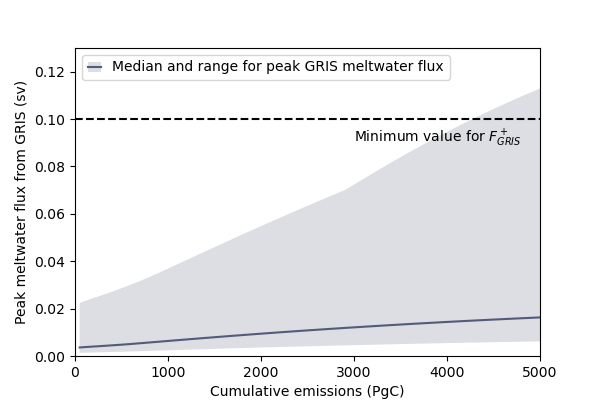

In [82]:
fig,ax=plt.subplots(1,1,figsize=(6,4))

color_c = cmap(0.25)

max_fgris_l= np.min(max_dydt,axis =0)
max_fgris_u= np.max(max_dydt,axis =0)
max_fgris_m= np.median(max_dydt,axis =0)

# ax.plot(emissions_tot,max_fgris_l)
# ax.plot(emissions_tot,max_fgris_u)
legend = []
m2 = ax.fill_between(emissions_tot,max_fgris_l,max_fgris_u,color=color_c,alpha=0.2,edgecolor='none',label='fz')
m1, = ax.plot(emissions_tot,max_fgris_m,c=color_c,label='fz')

ax.axhline(0.1,0,1,c='k',ls='--')
#ax.fill_between(emissions_tot,emissions_tot*0+0.1,emissions_tot*0+0.5,color='gray',alpha=0.2,edgecolor='none')

ax.set_xlim((0,5000))
ax.set_ylim((0,0.13))

ax.set_xlabel('Cumulative emissions (PgC)')
ax.set_ylabel('Peak meltwater flux from GRIS (sv)')

ax.annotate(r'Minimum value for $F^+_{GRIS}$', (3000,0.090))

legend.append((m2,m1))
   
ax.legend(legend,['Median and range for peak GRIS meltwater flux'],fontsize=10,handlelength=1,loc='upper left')


In [83]:
fig.savefig(os.path.join(figures_path, 'F_GRIS.pdf'))

C:\Users\AL000111\AppData\Local\Temp\ipykernel_22184\1634984633.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol,infodict =odeint(f_uniqueTP, y0, teval, tfirst= True, atol = ATOL,rtol = RTOL,full_output=True,args = (m_TP,emissions,forcings,model_params,computed_params,TP_properties,S_couplings,other_couplings,TP_setup,model_setup,),h0 = 1.0)


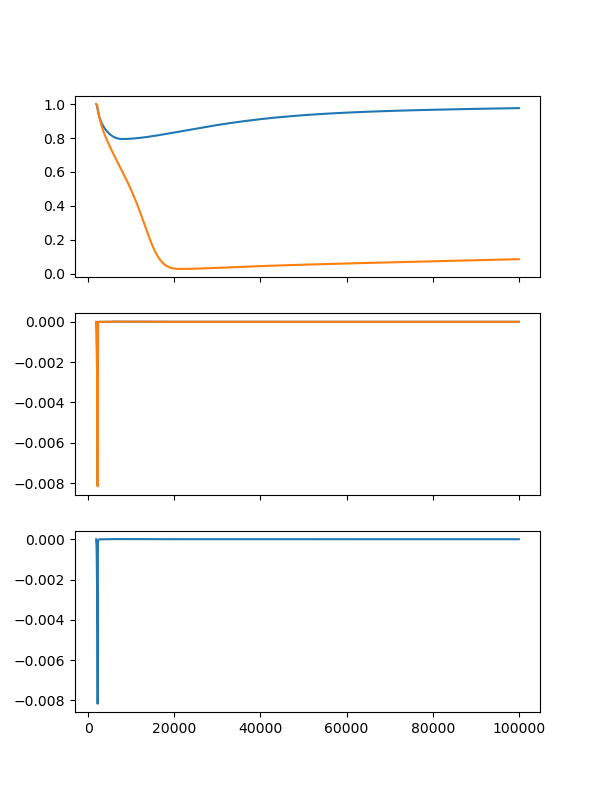

In [84]:
j=20
i=20

emissions = forcingCO2(2015,emissions_tot[j],mode='add',landuse= True, origin=1750) 
TP_params = [TP_PROP[i],S_COUPLINGS[i],OTHER_COUPLINGS[i]]

d= 1
epsi = 1
cfeedback = 1
TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)

sol,infodict =  SURFER_odeint(emissions,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)

y=sol.T[15:]
T= sol.T[9]
derivatives_tp = TP_derivatives(y,T,teval,TP_params,TP_setup)

m = 5

forcings= np.zeros((3,len(teval)))
forcings[0] = teval
forcings[1] = y[m]
forcings[2] = derivatives_tp[m]

sol2,infodict =  SURFER_TP_fixed(m,emissions,forcings,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
   

fig,ax =plt.subplots(3,1,figsize=(6,8),sharex=True)

ax[0].plot(teval,y[0])
ax[0].plot(teval,sol2.T[15+0])
ax[1].plot(teval[1:],(y[m,1:]-y[m,:-1])/(teval[1:]-teval[:-1]))
ax[1].plot(teval,derivatives_tp[m])
ax[2].plot(teval,derivatives_tp[m])

In [85]:
TP_indexes = np.array([15,16,17,18,20,21])

conversion_indexes = np.array([0,1,2,3,5,6])

d= 1
epsi = 1
cfeedback = 1
TP_setup = np.array([d,epsi,cfeedback],dtype = np.float64)

# TPS = SIM_QUANT[:,:,TP_indexes,-1].values
# TPS[TPS<0.25] = 0
# TPS[TPS>0.25] = 1
TPS_DIF = -(TPS[:,1:,:]-TPS[:,:-1,:])
sum_tip = np.sum(TPS_DIF,axis=2)
sum_tip_abs = np.sum(np.abs(TPS_DIF),axis=2)


list_events = []

for i in range(0,N_params) :
    for j in range(0,N_scenarios-1) :
        if sum_tip_abs[i,j]==0 :
            continue
        else : 
            n_tipped = sum_tip_abs[i,j]
            elem_tipped = TPS_DIF[i,j]

            stab = 1
            if -1 in elem_tipped :
                stab = -1
            
            # Roles

            # 1 : unique
            # 2 : initiator
            # 3 : in
            # 0 : not in eventsade
            
            roles = np.zeros(6)
            roles_wunder = np.zeros(6)
            
            changed_indexes, = np.where(TPS_DIF[i,j]!=0)
            
            if sum_tip_abs[i,j] ==1 :
                roles[changed_indexes] = 1
                roles_wunder[changed_indexes] = 1

            else:

                roles[changed_indexes] = 3
                roles_wunder[changed_indexes] = 3
            
                tipped_indexes, = np.where(TPS_DIF[i,j]==1)
                test_array = np.zeros(len(tipped_indexes))
                
                emissions = forcingCO2(2015,emissions_tot[j+1],mode='add',landuse= True, origin=1750) 
                TP_params = [TP_PROP[i],S_COUPLINGS[i],OTHER_COUPLINGS[i]]
                T = SIM_QUANT[i,j,9].values
                y = SIM_QUANT[i,j,15:].values
                
                hit=0
                for k in tipped_indexes :

                    ind = conversion_indexes[k]
                    
                    forcings = forcings_for_SURFER_uniqueTP(y,T,ind,teval,TP_params,TP_setup)
                    sol,infodict =  SURFER_uniqueTP(ind,emissions,forcings,y0,teval,model_params,TP_params,TP_setup,interp_sol=True,ktemp = True, sediments=True,weathering = True)
                    
                    # print(k,np.min(sol.T[0]))
                    if np.min(sol.T[15]) < 0.25 : 
                        roles[k] = 2
                        # print(k,np.min(sol.T[0]),roles)
                    
                    test_array[hit] = np.min(sol.T[15])

                    hit= hit+1
                    
                test_array[test_array<0.25] = 0
                test_array[test_array>0.25] = 1
                if 5 in tipped_indexes : 
                # if stab == -1 : 
                # if 1 == 1 :
                    print(test_array,tipped_indexes,elem_tipped,roles,i,j)
                #     Forcing_tot[ind] = SIM_QUANT[i,j,9]-1*COUPLING[ind]/TP_PROP[i,2,ind]

                #     Ritchie_quantitiy[ind] = ritchie_criterion(TP_TCRIT[i,ind],0,0.75,TP_PROP[i,5,ind],teval,Forcing_tot[ind])
                                           
                # max_temp = np.max(SIM_QUANT[i,j,9])
                # roles[np.argmax(Ritchie_quantitiy[conversion_indexes])] = 2
                # roles_wunder[np.argmin(np.abs(max_temp-TP_TCRIT[i][conversion_indexes[tipped_indexes]]))] = 2
            ####
           
            list_events.append([emissions_tot[j+1],n_tipped,elem_tipped,stab,i,roles,roles_wunder])

n_events = len(list_events)
events_POS = np.zeros(n_events)
events_n_tipped = np.zeros(n_events)
events_elem = np.zeros((n_events,6))
events_stab = np.zeros(n_events)
events_n_param = np.zeros(n_events)
events_roles = np.zeros((n_events,6))
events_roles_wunder = np.zeros((n_events,6))

for i in range(0,n_events) :
    events_POS[i] = list_events[i][0]
    events_n_tipped[i] = list_events[i][1]
    events_elem[i] = list_events[i][2]
    events_stab[i] = list_events[i][3]
    events_n_param[i] = list_events[i][4]
    events_roles[i] = list_events[i][5]
    events_roles_wunder[i] = list_events[i][6]

[0. 0.] [1 5] [-0.  1. -0. -0. -0.  1.] [0. 2. 0. 0. 0. 2.] 3 19
[1. 0.] [0 5] [ 1. -0. -0. -0. -0.  1.] [3. 0. 0. 0. 0. 2.] 16 76
[1. 1. 1.] [2 4 5] [-1. -0.  1. -0.  1.  1.] [3. 0. 3. 0. 3. 3.] 25 45
[1. 0. 1.] [2 4 5] [-0. -0.  1. -0.  1.  1.] [0. 0. 3. 0. 2. 3.] 33 19
[0. 0.] [2 5] [-0. -0.  1. -0. -0.  1.] [0. 0. 2. 0. 0. 2.] 36 41
[0. 1.] [4 5] [-0. -0. -0. -0.  1.  1.] [0. 0. 0. 0. 2. 3.] 39 33
[1. 1. 0. 1.] [1 2 4 5] [-0.  1.  1. -0.  1.  1.] [0. 3. 3. 0. 2. 3.] 49 28
[0. 0.] [2 5] [-0. -0.  1. -0. -0.  1.] [0. 0. 2. 0. 0. 2.] 56 40
[0. 0. 0.] [0 2 5] [ 1. -0.  1. -0. -0.  1.] [2. 0. 2. 0. 0. 2.] 63 45
[1. 0. 0.] [2 4 5] [-0. -0.  1. -0.  1.  1.] [0. 0. 3. 0. 2. 2.] 64 46
[1. 0. 1.] [2 4 5] [-0. -0.  1. -0.  1.  1.] [0. 0. 3. 0. 2. 3.] 81 11
[1. 0.] [0 5] [ 1. -0. -0. -0. -0.  1.] [3. 0. 0. 0. 0. 2.] 86 35
[0. 0.] [0 5] [ 1. -0. -0. -0. -0.  1.] [2. 0. 0. 0. 0. 2.] 89 33


In [86]:
print(n_events)

402


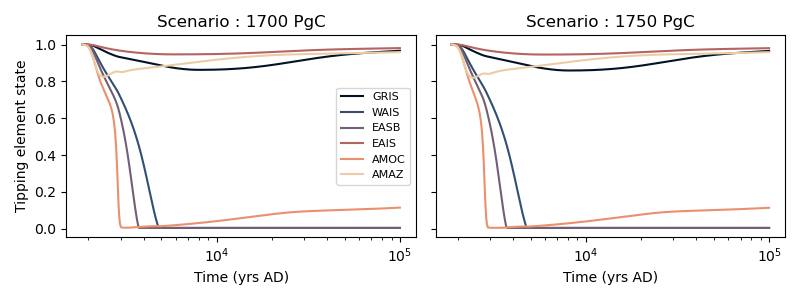

In [87]:
all_elements = ['GRIS','WAIS','EASB','EAIS','ASI','AMOC','AMAZ','PERM']


colors = cmap(np.linspace(0,0.9,6))

fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True,sharex=True)

i = 44
j=52

emissions = forcingCO2(2010,emissions_tot[j+1],mode='add',landuse= False, origin=1750) 
TP_params = [TP_PROP[i],S_COUPLINGS[i],OTHER_COUPLINGS[i]]
T = SIM_QUANT[i,j,9].values
y = SIM_QUANT[i,j,15:].values

tip_elem_ind = np.array([0,1,2,3,5,6])
                    
for m in range(0,6) :
    k = tip_elem_ind[m]
    ax[0].semilogx(teval,SIM_QUANT[i,j,15+k],c=colors[m],label=all_elements[k])
    ax[1].semilogx(teval,SIM_QUANT[i,j+1,15+k],c=colors[m],label=all_elements[k])
   

ax[0].legend(fontsize=8)
ax[0].set_ylabel('Tipping element state')
ax[0].set_xlabel('Time (yrs AD)')
ax[1].set_xlabel('Time (yrs AD)')


ax[0].set_title('Scenario : 1700 PgC')
ax[1].set_title('Scenario : 1750 PgC')

plt.tight_layout()

In [88]:
def print_sorted_events(events_elem,events_POS,events_n_tipped,events_stab,max_pgc):
    
    mask_max = (events_POS <= max_pgc)
    
    events_types, indexes , events_counts = np.unique(events_elem[mask_max], return_index=True, return_counts = True,axis = 0)
    N_types = len(events_counts)

    stab = events_stab[mask_max][indexes]
    n_tip = events_n_tipped[mask_max][indexes]
    
    sort_index = np.argsort(events_counts)[::-1]
    
    events_types = events_types[sort_index]
    events_counts = events_counts[sort_index]
    stab = stab[sort_index]
    n_tip = n_tip[sort_index]

    n_events = np.sum(events_counts)
    n_single_events = np.sum(events_counts[n_tip==1])
    n_casc = n_events - n_single_events
    n_stab_casc = np.sum(events_counts[stab==-1])
    
    print('Number of tipping events for scenarios < or = %.f PgC : '%max_pgc,n_events)
    print('-----------------------------------------')
    
    # single tipping 
    
    
    print('Single tipping events :', n_single_events, 'or %.2f pc of tipping events \n'%(n_single_events/n_events*100))
    
    for i in range(0,N_types):
        if np.sum(np.abs(events_types[i])) == 1 :
            print(events_types[i],events_counts[i], 'or {:.2f} pc of events ; {:.2f} pc of single tipping events'.format(events_counts[i]/n_events*100,events_counts[i]/n_single_events*100))
    print('')
    
    # 2 - cascade
    
    mask = (n_tip==2) & (stab==1)
    
    n = np.sum(events_counts[mask])
    print('Size 2 cascades :', n, 'or %.2f pc of tipping events '%(n/n_events*100),'or %.2f pc of cascades \n'% (n/n_casc*100))
    
    for i in range(0,np.sum(mask)):
            print(events_types[mask][i],events_counts[mask][i], 'or {:.2f} pc of events ; {:.2f} pc of cascades ; {:.2f} pc of this type of cascades'.format((events_counts[mask][i]/n_events*100),(events_counts[mask][i]/n_casc*100),(events_counts[mask][i]/n*100)))
    
    print('')
    
    # 3 - cascade
    
    mask = (n_tip==3) & (stab==1)
    
    n = np.sum(events_counts[mask])
    print('Size 3 cascades :', n, 'or %.2f pc of tipping events '%(n/n_events*100),'or %.2f pc of cascades \n'% (n/n_casc*100))
    
    for i in range(0,np.sum(mask)):
            print(events_types[mask][i],events_counts[mask][i], 'or {:.2f} pc of events ; {:.2f} pc of cascades ; {:.2f} pc of this type of cascades'.format((events_counts[mask][i]/n_events*100),(events_counts[mask][i]/n_casc*100),(events_counts[mask][i]/n*100)))
    
    print('')
    
    # 4 - cascade
    
    mask = (n_tip==4) & (stab==1)
    
    n = np.sum(events_counts[mask])
    print('Size 4 cascades :', n, 'or %.2f pc of tipping events '%(n/n_events*100),'or %.2f pc of cascades \n'% (n/n_casc*100))
    
    for i in range(0,np.sum(mask)):
            print(events_types[mask][i],events_counts[mask][i], 'or {:.2f} pc of events ; {:.2f} pc of cascades ; {:.2f} pc of this type of cascades'.format((events_counts[mask][i]/n_events*100),(events_counts[mask][i]/n_casc*100),(events_counts[mask][i]/n*100)))
    
    print('')
    
    # 5 - cascade
    
    mask = (n_tip==5) & (stab==1)
    
    n = np.sum(events_counts[mask])
    print('Size 5 cascades :', n, 'or %.2f pc of tipping events '%(n/n_events*100),'or %.2f pc of cascades \n'% (n/n_casc*100))
    
    for i in range(0,np.sum(mask)):
            print(events_types[mask][i],events_counts[mask][i], 'or {:.2f} pc of events ; {:.2f} pc of cascades ; {:.2f} pc of this type of cascades'.format((events_counts[mask][i]/n_events*100),(events_counts[mask][i]/n_casc*100),(events_counts[mask][i]/n*100)))
    
    print('')
    
    # 6 - cascade
    
    mask = (n_tip==6) & (stab==1)
    
    n = np.sum(events_counts[mask])
    print('Size 6 cascades :', n, 'or %.2f pc of tipping events '%(n/n_events*100),'or %.2f pc of cascades \n'% (n/n_casc*100))
    
    for i in range(0,np.sum(mask)):
            print(events_types[mask][i],events_counts[mask][i], 'or {:.2f} pc of events ; {:.2f} pc of cascades ; {:.2f} pc of this type of cascades'.format((events_counts[mask][i]/n_events*100),(events_counts[mask][i]/n_casc*100),(events_counts[mask][i]/n*100)))
    
    print('')
    
    # other
    
    mask =  (stab==-1)
    
    n = np.sum(events_counts[mask])
    print('Stab cascades :', n, 'or %.2f pc of tipping events '%(n/n_events*100),'or %.2f pc of cascades \n'% (n/n_casc*100))
    
    for i in range(0,np.sum(mask)):
            print(events_types[mask][i],events_counts[mask][i], 'or {:.2f} pc of events ; {:.2f} pc of cascades ; {:.2f} pc of this type of cascades'.format((events_counts[mask][i]/n_events*100),(events_counts[mask][i]/n_casc*100),(events_counts[mask][i]/n*100)))
    
    print('')

    return

In [89]:
print_sorted_events(events_elem,events_POS,events_n_tipped,events_stab,5000)

Number of tipping events for scenarios < or = 5000 PgC :  402
-----------------------------------------
Single tipping events : 301 or 74.88 pc of tipping events 

[ 1. -0. -0. -0. -0. -0.] 79 or 19.65 pc of events ; 26.25 pc of single tipping events
[-0. -0. -0. -0. -0.  1.] 79 or 19.65 pc of events ; 26.25 pc of single tipping events
[-0.  1. -0. -0. -0. -0.] 58 or 14.43 pc of events ; 19.27 pc of single tipping events
[-0. -0.  1. -0. -0. -0.] 55 or 13.68 pc of events ; 18.27 pc of single tipping events
[-0. -0. -0. -0.  1. -0.] 30 or 7.46 pc of events ; 9.97 pc of single tipping events

Size 2 cascades : 66 or 16.42 pc of tipping events  or 65.35 pc of cascades 

[-0. -0.  1. -0.  1. -0.] 18 or 4.48 pc of events ; 17.82 pc of cascades ; 27.27 pc of this type of cascades
[-0.  1. -0. -0.  1. -0.] 17 or 4.23 pc of events ; 16.83 pc of cascades ; 25.76 pc of this type of cascades
[ 1.  1. -0. -0. -0. -0.] 16 or 3.98 pc of events ; 15.84 pc of cascades ; 24.24 pc of this type of cascad

In [90]:
print_sorted_events(events_elem,events_POS,events_n_tipped,events_stab,1000)

Number of tipping events for scenarios < or = 1000 PgC :  60
-----------------------------------------
Single tipping events : 48 or 80.00 pc of tipping events 

[-0. -0. -0. -0. -0.  1.] 16 or 26.67 pc of events ; 33.33 pc of single tipping events
[-0. -0. -0. -0.  1. -0.] 14 or 23.33 pc of events ; 29.17 pc of single tipping events
[-0.  1. -0. -0. -0. -0.] 11 or 18.33 pc of events ; 22.92 pc of single tipping events
[ 1. -0. -0. -0. -0. -0.] 4 or 6.67 pc of events ; 8.33 pc of single tipping events
[-0. -0.  1. -0. -0. -0.] 3 or 5.00 pc of events ; 6.25 pc of single tipping events

Size 2 cascades : 11 or 18.33 pc of tipping events  or 91.67 pc of cascades 

[-0.  1. -0. -0.  1. -0.] 5 or 8.33 pc of events ; 41.67 pc of cascades ; 45.45 pc of this type of cascades
[ 1.  1. -0. -0. -0. -0.] 3 or 5.00 pc of events ; 25.00 pc of cascades ; 27.27 pc of this type of cascades
[-0. -0.  1. -0.  1. -0.] 3 or 5.00 pc of events ; 25.00 pc of cascades ; 27.27 pc of this type of cascades

Size 

In [91]:
mask_max = (events_POS <= 5000)
    
events_types, indexes , events_counts = np.unique(events_elem[mask_max], return_index=True, return_counts = True,axis = 0)
N_types = len(events_counts)

stab = events_stab[mask_max][indexes]
n_tip = events_n_tipped[mask_max][indexes]

sort_index = np.argsort(events_counts)[::-1]

events_types = events_types[sort_index]
events_counts = events_counts[sort_index]
stab = stab[sort_index]
n_tip = n_tip[sort_index]

n_events = np.sum(events_counts)
n_single_events = np.sum(events_counts[n_tip==1])
n_casc = n_events - n_single_events
n_stab_casc = np.sum(events_counts[stab==-1])

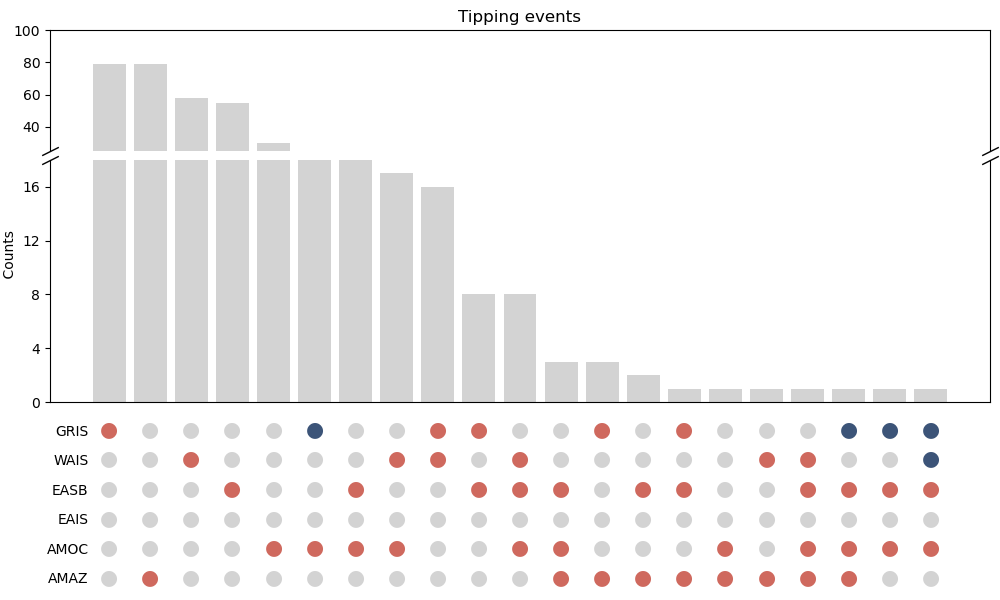

In [92]:
tipping_elements=['GRIS','WAIS','EASB','EAIS','AMOC','AMAZ']


bottom=0

fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# Adjust the space between subplots
fig.subplots_adjust(hspace=0.05, bottom=0.33,left = 0.05,right = 0.99,top=0.95)

# Top plot: higher values
bars_top = ax_top.bar(np.arange(N_types), events_counts, bottom=bottom, color='lightgray')
ax_top.set_ylim(25, 100)  # Customize as needed

# Bottom plot: lower values
bars_bottom = ax_bottom.bar(np.arange(N_types), events_counts, bottom=bottom, color='lightgray')
ax_bottom.set_ylim(0, 18)  # Customize as needed

# Add break markers on y-axis to show it's broken
ax_top.spines['bottom'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_top.xaxis.tick_top()
ax_top.tick_params(labeltop=False)  # don't put tick labels at the top
ax_bottom.xaxis.tick_bottom()

ax_bottom.set_yticks([0,4,8,12,16])
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax_top.plot([0, 1], [0, 0], transform=ax_top.transAxes, **kwargs)
ax_bottom.plot([0, 1], [1, 1], transform=ax_bottom.transAxes, **kwargs)

# Add labels and text for both plots (similar to before)
for i in range(0, N_types):
    bar_bottom = bars_bottom[i]
    tipping_status = events_types[i]
    for j, status in enumerate(tipping_status):
        if status == -1:
            color = cmap(0.2)
        elif status == 1:
            color = cmap(0.6)
        else:
            color = 'lightgray'
        ax_bottom.text(bar_bottom.get_x() + bar_bottom.get_width() / 2, -2.0 - 2.2 * j, '●', color=color, fontsize=15, ha='center', va='center')

# Add row labels for tipping elements
for j, element in enumerate(tipping_elements):
    ax_bottom.text(-0.5, -2.2 - 2.2 * j, element, fontsize=10, ha='right', va='center')

# Customize labels
ax_bottom.set_xticks([])
ax_bottom.set_ylabel('            Counts')
ax_top.set_title('Tipping events')
# plt.tight_layout()
plt.show()

In [93]:
fig.savefig(os.path.join(figures_path, 'tipping_events.pdf'))

In [94]:
def cascades_by_(N_params,N_scenarios,TPS) : 
    TPS_DIF = -(TPS[:,1:,:]-TPS[:,:-1,:])
    sum_tip = np.sum(TPS_DIF,axis=2)
    sum_tip_abs = np.sum(np.abs(TPS_DIF),axis=2)
    
    casc_per_scenario = np.zeros((N_params,N_scenarios))
    
    for i in range(0,N_params) :
        for j in range(0,N_scenarios-1) :
            
            if sum_tip_abs[i,j]==0 :
                continue
            else : 
                if -1 in TPS_DIF[i,j] :
                    casc_per_scenario[i,j+1] = -1
                else : 
                    casc_per_scenario[i,j+1] = sum_tip_abs[i,j]
    
    events_types = [1,2,3,4,5,6,-1]
    
    Z = np.zeros((N_scenarios,8))
    
    for j in range(0,N_scenarios) :
        
        for i in range(0,N_params) :
    
            hit = 0
            
            for k in range(0,len(events_types)):
                
                if events_types[k] in casc_per_scenario[i,:j+1]:
                    Z[j,k] = Z[j,k] + 1
                    hit=hit+1
    
            if hit > 0 :
    
                Z[j,7] = Z[j,7] +1
    return Z

C:\Users\AL000111\AppData\Local\Temp\ipykernel_22184\1842109978.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,[ax,ax3] = plt.subplots(1,2, figsize=(10,5),sharex=True)


[1.000e+00 2.510e+02 5.010e+02 7.510e+02 1.001e+03 1.251e+03 1.501e+03
 1.751e+03 2.001e+03 2.251e+03 2.501e+03 2.751e+03 3.001e+03 3.251e+03
 3.501e+03 3.751e+03 4.001e+03 4.251e+03 4.501e+03 4.751e+03 5.001e+03]
[1.49251906 1.55379382 1.61121852 1.66436211 1.71830489 1.77465834
 1.83221294 1.89078463 1.95057056 2.01375222 2.08028556 2.14953516
 2.21996503 2.29120132 2.36251935 2.4335833  2.50482399 2.57608145
 2.64667333 2.71790006 2.78802756 2.85885405 2.92853718 2.99886139
 3.06819689 3.13772712 3.20662578 3.27506951 3.34360733 3.41118563
 3.47904621 3.54626294 3.61270886 3.6795508  3.74548487 3.81084338
 3.87639161 3.94113185 4.00513273 4.06940584 4.13292699 4.1956316
 4.25847105 4.32074972 4.38225897 4.4436056  4.50465399 4.56503695
 4.62549371 4.68548236 4.74478158 4.80416563 4.86297159 4.92096675
 4.97912895 5.03664879 5.09354933 5.15012502 5.20646966 5.26220243
 5.31729101 5.37176956 5.42570174 5.4790185  5.53171683 5.58382466
 5.63537312 5.68623968 5.73654488 5.78641155 5.836

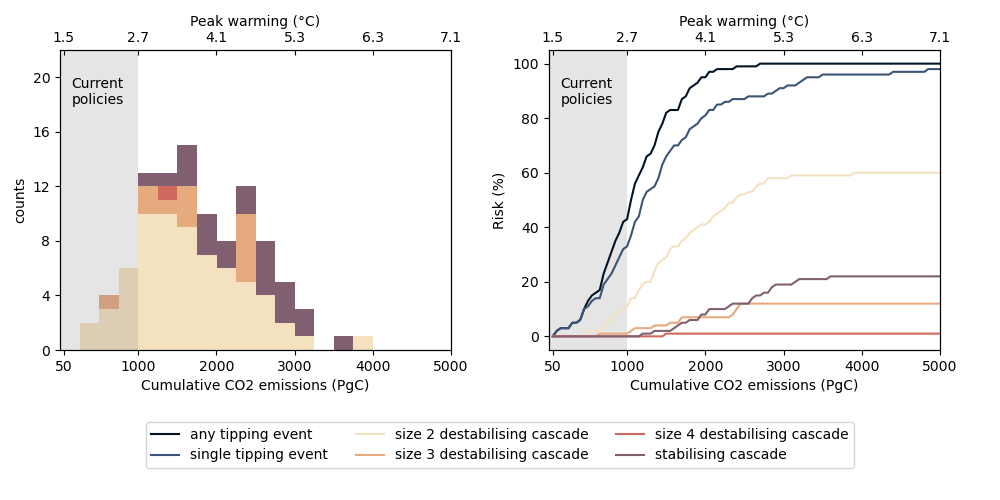

In [95]:
scenario_indexes = np.array([0,19,39,59,79,99])
T_max = np.max(SIM_QUANT_0[0,:,9].values,axis = 1)

events_4_ind  = (events_stab == 1) & (events_n_tipped ==4)
events_3_ind  = (events_stab == 1) & (events_n_tipped ==3)
events_2_ind  = (events_stab == 1) & (events_n_tipped ==2)
events_1_ind  = (events_stab == 1) & (events_n_tipped ==1)
events_stab_ind  = (events_stab == -1)

c_events_1 = cmap(0.2)
c_events_2 = cmap(0.95)
c_events_3 = cmap(0.8)
c_events_4 = cmap(0.6)
c_events_5 = 'r'
c_events_6 = 'g'
c_events_stab = cmap(0.4)
c_events_all = cmap(0.0)


fig,[ax,ax3] = plt.subplots(1,2, figsize=(10,5),sharex=True)

BINS = np.linspace(0,5000,21)+1

ax.hist([events_POS[events_2_ind],events_POS[events_3_ind],events_POS[events_4_ind],events_POS[events_stab_ind]], bins=BINS,stacked=True,color=[c_events_2,c_events_3,c_events_4,c_events_stab])
ax.set_xlim((0,5000))
ax.set_xticks(emissions_tot[scenario_indexes])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(emissions_tot[scenario_indexes])
ax2.set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )
ax2.set_xlabel('Peak warming (°C)')
ax2.tick_params(direction='in')

Z = cascades_by_(N_params,N_scenarios,TPS)

ax3.plot(emissions_tot,Z[:,7]/100*100,c=c_events_all,label='any tipping event')
ax3.plot(emissions_tot,Z[:,0]/100*100,c=c_events_1,label='single tipping event')
ax3.plot(emissions_tot,Z[:,1]/100*100,c=c_events_2,label='size 2 destabilising cascade')
ax3.plot(emissions_tot,Z[:,2]/100*100,c=c_events_3,label='size 3 destabilising cascade')
ax3.plot(emissions_tot,Z[:,3]/100*100,c=c_events_4,label='size 4 destabilising cascade')
# ax3.plot(emissions_tot,Z[:,4]/100*100,c=c_events_5)
# ax3.plot(emissions_tot,Z[:,5]/100*100,c=c_events_6)
ax3.plot(emissions_tot,Z[:,6]/100*100,c=c_events_stab,label='stabilising cascade')

ax.fill_betweenx([0,22],0,1000,color='gray',alpha=0.2,edgecolor='none')
ax3.fill_betweenx([-10,110],0,1000,color='gray',alpha=0.2,edgecolor='none')
# ax3.vlines(1000,ax3.get_ylim()[0],ax3.get_ylim()[1],color='gray',alpha=0.2)
ax.set_ylim((0,22))
ax.set_yticks(np.linspace(0,20,6))
ax3.set_ylim((-5,105))



ax4 = ax3.twiny()
ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(emissions_tot[scenario_indexes])
ax4.set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )
ax4.set_xlabel('Peak warming (°C)')
ax4.tick_params(direction='in')

ax.set_xlabel('Cumulative CO2 emissions (PgC)')
ax3.set_xlabel('Cumulative CO2 emissions (PgC)')

ax.set_ylabel('counts')
ax3.set_ylabel('Risk (%)')

ax.annotate('Current\npolicies',(0.03,0.82),xycoords='axes fraction')
ax3.annotate('Current\npolicies',(0.03,0.82),xycoords='axes fraction')

# ax3.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
fig.subplots_adjust(wspace=0.25, bottom=0.30,left=0.06, right=0.94, top=0.9)

ax3.legend(bbox_to_anchor=(0.5, 0.05), loc="lower center",
                bbox_transform=fig.transFigure, ncol=3)

print(BINS)
print(T_max)

In [96]:
fig.savefig(os.path.join(figures_path, 'cascades_timing.pdf'))

[1, 2, 3, 4, 5, 6, -1]
----------------
[32.  0.  0.  0.  0.  0.  0. 32.] TPS_0
[33. 11.  1.  0.  0.  0.  0. 43.] TPS
[30.  8.  1.  0.  0.  0.  0. 38.] TPS_int
[36.  0.  0.  0.  0.  0.  0. 36.] TPS_feed
[69.  1.  0.  0.  0.  0.  0. 70.] TPS_ecs5_0
[69. 38.  5.  1.  0.  0.  4. 85.] TPS_ecs5
[33. 15. 20.  4.  0.  0.  5. 59.] TPS_2int
[28.  7.  1.  0.  0.  0.  0. 35.] TPS_noASInoPERM


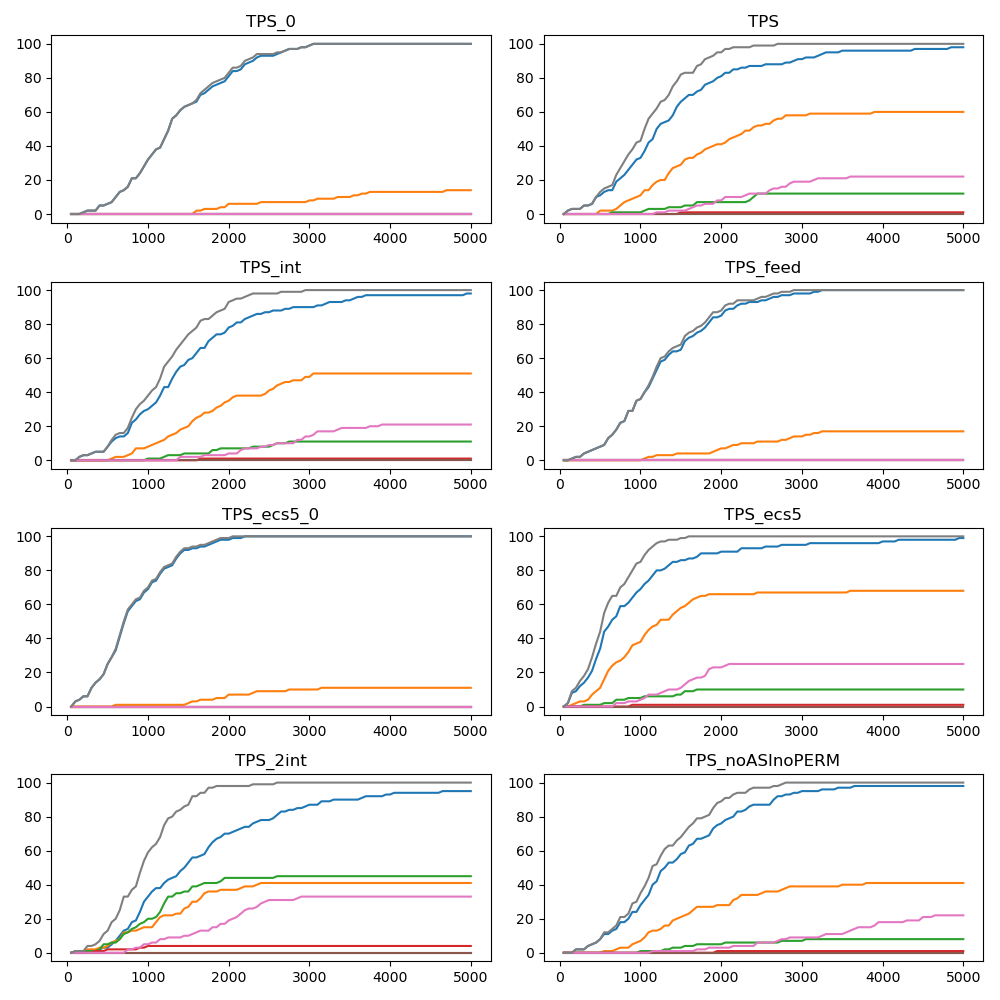

In [97]:
experiments_TPS = [TPS_0,TPS,TPS_int,TPS_feed,TPS_ecs5_0,TPS_ecs5,TPS_2int,TPS_noASInoPERM]
experiments_labels = ['TPS_0','TPS','TPS_int','TPS_feed','TPS_ecs5_0','TPS_ecs5','TPS_2int','TPS_noASInoPERM']
print([1,2,3,4,5,6,-1])
print('----------------')

fig,axs = plt.subplots(4,2,figsize=(10,10))
ax = axs.flatten()

for i in range(0,8) : 
    Y = cascades_by_(N_params,N_scenarios,experiments_TPS[i])
    print(Y[19,:],experiments_labels[i])

    ax[i].set_title(experiments_labels[i])
    for j in range(0,8):
        ax[i].plot(emissions_tot,Y[:,j])

plt.tight_layout()

## Roles 

GRIS : 

number of cascades involving GRIS : 50 49.504950495049506
as initator : 24 , which is 48.00 pc of the cascades it is involved in
_______________________ 

WAIS : 

number of cascades involving WAIS : 44 43.56435643564357
as initator : 8 , which is 18.18 pc of the cascades it is involved in
_______________________ 

EASB : 

number of cascades involving EASB : 44 43.56435643564357
as initator : 8 , which is 18.18 pc of the cascades it is involved in
_______________________ 

EAIS : 

number of cascades involving EAIS : 0 0.0
_______________________ 

AMOC : 

number of cascades involving AMOC : 70 69.3069306930693
as initator : 58 , which is 82.86 pc of the cascades it is involved in
_______________________ 

AMAZ : 

number of cascades involving AMAZ : 13 12.871287128712872
as initator : 8 , which is 61.54 pc of the cascades it is involved in
_______________________ 



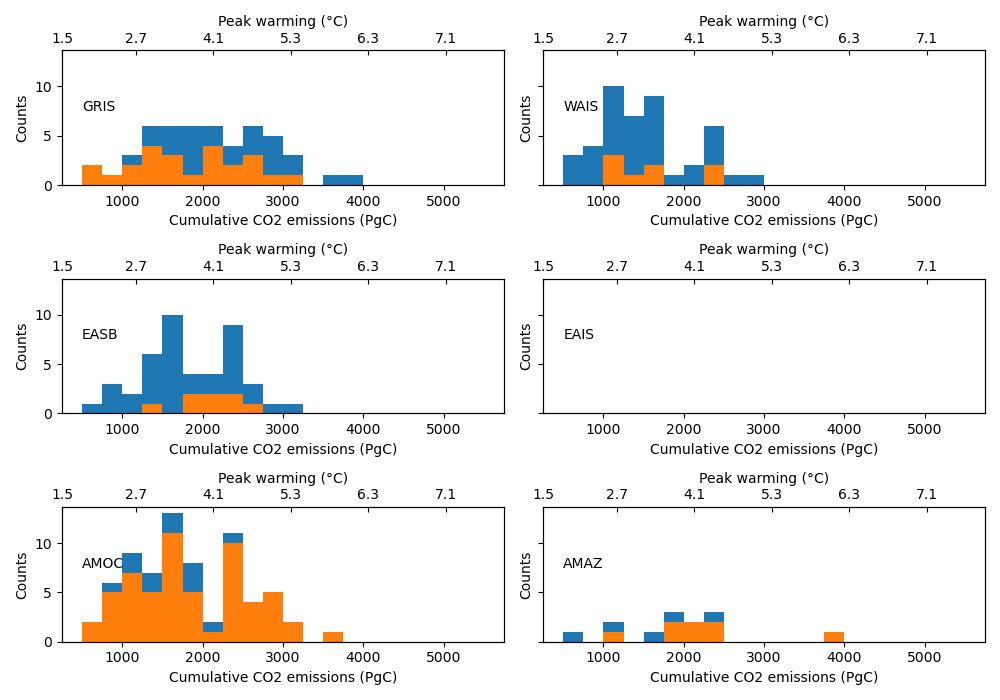

In [98]:

elements = ['GRIS','WAIS','EASB','EAIS','AMOC','AMAZ']


fig,axs = plt.subplots(3,2,figsize=(10,7),sharey=True)

axs2 = np.copy(axs)

ax = axs.flatten()
ax2 = axs2.flatten()

BINS = np.linspace(500,5500,21)

for k in range(0,6) : 
    
    events_TP  = (events_n_tipped > 1) & (events_elem[:,k] !=0)
    events_TP_init = events_TP & (events_roles[:,k] ==2)
    events_TP_init_wunder = events_TP & (events_roles_wunder[:,k] ==2)

    print(elements[k],': \n')
    print('number of cascades involving',elements[k],':',len(events_POS[events_TP]),len(events_POS[events_TP])/n_casc*100)
    if len(events_POS[events_TP_init]) !=0 :
        print('as initator :',len(events_POS[events_TP_init]), ', which is %.2f pc of the cascades it is involved in'%(len(events_POS[events_TP_init])/len(events_POS[events_TP])*100))
    # print(len(events_POS[events_TP_init_wunder]))
    print('_______________________ \n')
    
    ax[k].hist(events_POS[events_TP],bins=BINS)
    ax[k].hist(events_POS[events_TP_init],bins=BINS)
    # ax[k].hist(events_POS[events_TP_init_wunder],bins=BINS,histtype=u'step',color='k')
    ax[k].annotate(elements[k],(500,7.5))
    # ax[k].set_yticks([0,1,2,3,4])
    ax[k].set_ylabel('Counts')
    ax[k].set_xlabel('Cumulative CO2 emissions (PgC)')

    ax2[k] = ax[k].twiny()
    ax2[k].set_xlim(ax[k].get_xlim())
    ax2[k].set_xticks(emissions_tot[scenario_indexes])
    ax2[k].set_xticklabels('%.1f' % z for z in T_max[scenario_indexes] )
    ax2[k].set_xlabel('Peak warming (°C)')
    ax2[k].tick_params(direction='in')

plt.tight_layout()

In [99]:
table_roles = np.zeros((6,3,2))

# n_destab =n_casc-n_stab



# n_events = np.sum(events_counts)
# n_single_events = np.sum(events_counts[n_tip==1])
# n_casc = n_events - n_single_events
n_stab_casc = np.sum(events_counts[stab==-1])

n_destab_casc = n_casc-n_stab_casc

print(n_stab_casc,n_destab_casc)
for k in range(0,6) : 
    
    events_TP  = (events_n_tipped > 1) & (events_elem[:,k] !=0) 
    events_TP_init = events_TP & (events_roles[:,k] ==2)
    table_roles[k,0,0] = len(events_POS[events_TP])/n_casc*100
    table_roles[k,0,1] = len(events_POS[events_TP_init])/n_casc*100
    
    events_TP  = (events_n_tipped > 1) & (events_elem[:,k] !=0) & (events_stab == 1)
    events_TP_init = events_TP & (events_roles[:,k] ==2)
    table_roles[k,1,0] = len(events_POS[events_TP])/n_destab_casc*100
    table_roles[k,1,1] = len(events_POS[events_TP_init])/n_destab_casc*100
        
    events_TP  = (events_n_tipped > 1) & (events_elem[:,k] !=0) & (events_stab == -1)
    events_TP_init = events_TP & (events_roles[:,k] ==2)
    table_roles[k,2,0] = len(events_POS[events_TP])/n_stab_casc*100
    table_roles[k,2,1] = len(events_POS[events_TP_init])/n_stab_casc*100




22 79


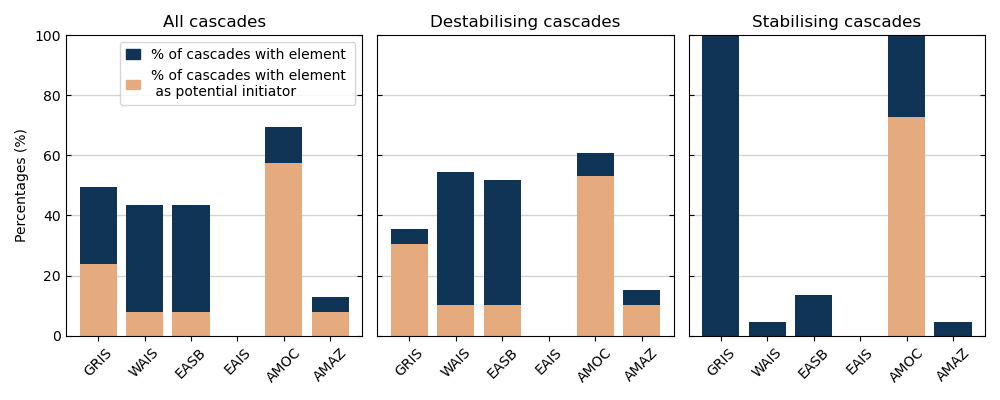

In [100]:
fig, axs = plt.subplots(1,3,figsize=(10,4),sharey=True)

for i in range(0,3):

    for value in [20,40,60,80] :
        axs[i].axhline(value,0,1,c='lightgray',lw=1,zorder=0)
        
    axs[i].bar(tipping_elements, table_roles[:,i,0], color=cmap(0.1))
    axs[i].bar(tipping_elements, table_roles[:,i,1], color=cmap(0.8))
    axs[i].tick_params(right=True)
    axs[i].yaxis.set_tick_params(direction='in')
    axs[i].set_xticks(np.arange(6))
    axs[i].set_xticklabels(tipping_elements,rotation = 45)
   
axs[0].set_ylim((0,100))
axs[0].fill_between([np.nan],[np.nan],[np.nan],color=cmap(0.1),label='% of cascades with element')
axs[0].fill_between([np.nan],[np.nan],[np.nan],color=cmap(0.8),label='% of cascades with element \n as potential initiator')
axs[0].legend(handlelength = 1,fontsize=10)

axs[0].set_ylabel('Percentages (%)')
axs[0].set_title('All cascades')
axs[1].set_title('Destabilising cascades')
axs[2].set_title('Stabilising cascades')

plt.tight_layout()

In [101]:
fig.savefig(os.path.join(figures_path, 'cascades_roles.pdf'))